### 「賃料」データの外れ値がRMSEの悪化に寄与している事実に対して、施策を練る

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy as sp
import lightgbm as lgb
import category_encoders as ce
# import mojimoji
import re
from cmath import nan
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
import optuna
from sklearn.metrics import mean_squared_error
import japanize_matplotlib
from sklearn.model_selection import KFold

###訓練データの読み込み
house_age = pd.read_csv('../data/handmade_data/house_age.csv')
area_size = pd.read_csv('../data/handmade_data/area_size.csv')
room_arrange = pd.read_csv('../data/handmade_data/room_arrange.csv')
contract_span = pd.read_csv('../data/handmade_data/contract_span.csv')#欠損値をゼロ埋めした契約期間
contract_span2 = pd.read_csv('../data/handmade_data/contract_span2.csv')#欠損値を欠損値のままにした契約期間
reg_rent = pd.read_csv('../data/handmade_data/reg_rent.csv')
floor_scores = pd.read_csv('../data/handmade_data/floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「所在階」
floor_scores2 = pd.read_csv('../data/handmade_data/floor_scores2.csv')#「所在階」と「全体の階数」が独立している「所在階」
Floor_scores = pd.read_csv('../data/handmade_data/capital_floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「全体の階数」
Floor_scores2 = pd.read_csv('../data/handmade_data/capital_floor_scores2.csv')#「所在階」と「全体の階数」が独立している「全体の階数」
stations = pd.read_csv('../data/handmade_data/stations.csv')
minits = pd.read_csv('../data/handmade_data/minits.csv')
addresses = pd.read_csv('../data/handmade_data/addresses.csv')
room_arrange = pd.read_csv('../data/handmade_data/room_arrange.csv')
buildings = pd.read_csv('../data/handmade_data/buildings.csv')
land_aveprice = pd.read_csv('../data/handmade_data/land_aveprice.csv')
land_aveprice.columns = ['平均地価']


rent = pd.read_csv('../data/handmade_data/rent.csv')


##テストデータの読み込み
test_house_age = pd.read_csv('../data/test_data/test_house_age.csv')
test_area_size = pd.read_csv('../data/test_data/test_area_size.csv')
test_room_arrange = pd.read_csv('../data/test_data/test_room_arrange.csv')
test_contract_span = pd.read_csv('../data/test_data/test_contract_span.csv')
test_contract_span2 = pd.read_csv('../data/test_data/test_contract_span2.csv')
test_reg_rent = pd.read_csv('../data/test_data/test_reg_rent.csv')
test_floor_scores = pd.read_csv('../data/test_data/test_floor_scores.csv')
test_floor_scores2 = pd.read_csv('../data/test_data/test_floor_scores2.csv')
test_Floor_scores = pd.read_csv('../data/test_data/test_capital_floor_scores.csv')
test_Floor_scores2 = pd.read_csv('../data/test_data/test_capital_floor_scores2.csv')
test_stations = pd.read_csv('../data/test_data/test_stations.csv')
test_minits = pd.read_csv('../data/test_data/test_minits.csv')
test_addresses = pd.read_csv('../data/test_data/test_addresses.csv')
test_room_arrange = pd.read_csv('../data/test_data/test_room_arrange.csv')
test_buildings = pd.read_csv('../data/test_data/test_buildings.csv')
test_land_aveprice = pd.read_csv('../data/test_data/test_land_aveprice.csv')
test_land_aveprice.columns = ['平均地価']

X_train = pd.concat([house_age, area_size, contract_span2, reg_rent, floor_scores2, Floor_scores2, stations, minits, land_aveprice, addresses, room_arrange[["部屋数","L","D","S"]]], axis=1)
y_train = rent
X_test = pd.concat([test_house_age, test_area_size, test_contract_span2, test_reg_rent, test_floor_scores2, test_Floor_scores2, test_stations, test_minits, test_land_aveprice, test_addresses, test_room_arrange[["部屋数","L","D","S"]]], axis=1)
category_lists = ['定期借家','最寄り駅', '所在地', 'L', 'D','S']

Duplicate key in file PosixPath('/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/matplotlib/mpl-data/matplotlibrc'), line 258 ('font.family : IPAexGothic')
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


「賃料」がわかりやすくなるように予測に用いる特徴量と合体させる

In [2]:
DATA = pd.concat([y_train, X_train],axis=1)

In [14]:
pd.set_option('display.max_rows', 150)
prime_place = DATA[DATA['賃料']>500000]
prime_place.to_csv('../data/handmade_data/over_500000yen.csv')
prime_place

賃料    築年数      面積      契約期間  定期借家   所在階  全体の階数  最寄り駅  所要時間  \
274     650000   25.0   79.91  4.000000     2  30.0   38.0   172   2.0   
666     505000   49.0  111.65  2.000000     1  53.0   53.0    23   1.0   
671     900000  175.0  231.52  2.000000     1   3.0    1.0   267   6.0   
1295    550000  544.0  214.78  2.000000     1   3.0    NaN   275   5.0   
1501   1200000  222.0  163.62  5.000000     2   3.0    3.0   235   9.0   
1712    515000  195.0   85.86  2.000000     1  13.0   34.0    13   8.0   
1771   1450000  109.0  232.01  4.000000     2   2.0    NaN   372   5.0   
1940    780000   23.0  112.30  2.000000     1   9.0   16.0    19   5.0   
2047    820000  202.0  164.88  2.000000     1   2.0    7.0   152   5.0   
2075    880000  250.0  256.68  5.000000     2   3.0    NaN    52   3.0   
2266    700000  413.0  152.07  2.000000     2   5.0    7.0    13   9.0   
2624    520000    6.0   75.95  2.000000     1  34.0   37.0   157   5.0   
2909    700000   20.0  103.04  3.000000     2   3.0    9.0   235   8.0   
3157    550000  207.0  133.13       NaN     3   9.0   20.0   348   2.0   
3561    728000  125.0  104.79  3.000000     2   6.0   18.0    89   9.0   
3740    530000   71.0  105.10  1.000000     2   3.0    7.0    89   7.0   
4218    600000    0.0  104.36       NaN     3  20.0   21.0   256   1.0   
4764    550000  119.0   83.60  2.000000     1   3.0    4.0    99  11.0   
4820    720000   53.0  122.70  2.000000     1   2.0    3.0   112   6.0   
5093   2500000   20.0  217.29  3.000000     2   9.0    9.0   235   8.0   
5599    950000   63.0   88.70  2.000000     1  43.0   52.0   402   5.0   
5612    700000   50.0   89.49  5.000000     2   3.0    NaN    30   4.0   
5762    680000  203.0  106.23  2.000000     1  37.0   49.0   397   3.0   
5775   1203500  149.0   20.53  2.000000     1  10.0   15.0    90   2.0   
5896    505000   49.0  111.65       NaN     3  53.0   53.0    23   1.0   
6030    950000  352.0  188.69  2.000000     1   5.0    6.0   317   5.0   
6215    558000  203.0  183.45  2.000000     1   4.0    NaN   345   6.0   
6351    900000    6.0  105.46  3.000000     2   3.0    7.0    13   8.0   
6387    680000   20.0   72.21  5.000000     2   7.0   26.0   348   3.0   
6563    700000  222.0  102.82  4.000000     2   3.0   14.0   257   3.0   
6972    530000  197.0  144.66  0.166667     1   3.0    9.0   169   6.0   
7656    550000  184.0  104.96  2.000000     2  10.0   11.0   256   7.0   
7874    510000    6.0   74.85  2.000000     1  10.0   37.0   157   5.0   
7960    565000  138.0  109.87  2.000000     1  24.0   25.0   172   7.0   
8314    648000  184.0  133.84       NaN     3  12.0   14.0   434   3.0   
8559    600000  137.0  113.00  5.000000     2  42.0   44.0   153   5.0   
8706   1390000  178.0  138.99  3.000000     2   7.0   24.0   317   1.0   
8878    850000    9.0  105.46  3.000000     2   3.0    7.0    13   8.0   
9008   1300000  365.0  223.71  3.000000     2   3.0    NaN   235   7.0   
9237    690000   53.0  108.53  2.000000     1   3.0   14.0   257   7.0   
9543    590000   21.0   73.36  2.000000     1   4.0    5.0    46   7.0   
9893    577000   91.0  100.35  2.000000     2  28.0   32.0   360   2.0   
10147   590000  220.0  182.41  2.000000     1   2.0    NaN   314  15.0   
10277   650000  294.0  166.03       NaN     3   2.0    NaN   132   6.0   
10334   690000  395.0  214.77  2.000000     2   2.0    1.0   334   7.0   
10719   950000  187.0  195.54  4.000000     2   3.0    1.0    13   7.0   
10908   565000  138.0  109.87  2.000000     1  24.0   27.0   172   7.0   
11000   505000   48.0  111.65  2.000000     1  53.0   53.0    23   1.0   
11367  1100000  301.0  192.43  2.000000     1   9.0   10.0   360   2.0   
11958  1120000  271.0  221.30  3.000000     2  11.0   13.0    76   6.0   
12571   520000  466.0  138.67  5.000000     2  13.0   14.0   218   5.0   
12832   540000   61.0   89.82  2.000000     1   6.0   15.0   257   5.0   
12863   526000   19.0   81.85       NaN     3  12.0   13.0   448   1.0   
13333   550000  

明らかな異常値を見つけたので修正を行う。レコードID:5775は、ワンルーム約20m^2で家賃月120万であり、これはあり得ない。12万の間違いとして修正を行う。

In [17]:
DATA = pd.concat([y_train, X_train],axis=1)
DATA.loc[[5775],'賃料'] = DATA.loc[[5775],'賃料']/10
DATA.loc[5775]

「賃料」は「面積」と強い相関がある。「L」「全体の階数」「D」「所在階」・・・というように相関は続く。

In [29]:
DATA.corr()['賃料']

賃料       1.000000
築年数     -0.251352
面積       0.752858
契約期間     0.191123
定期借家     0.013631
所在階      0.429444
全体の階数    0.495466
最寄り駅     0.059917
所要時間    -0.135984
平均地価     0.267642
所在地     -0.000540
部屋数      0.375435
L        0.565994
D        0.474419
S        0.196456
Name: 賃料, dtype: float64

「面積」が80m^2以下で賃料が500000以下の物件について調べた結果、やはりあまりない。

In [35]:
DATA[(DATA['賃料']>500000) & (DATA['面積']<80)]

賃料   築年数     面積  契約期間  定期借家   所在階  全体の階数  最寄り駅  所要時間          平均地価  \
274    650000  25.0  79.91   4.0     2  30.0   38.0   172   2.0  1.840000e+06   
2624   520000   6.0  75.95   2.0     1  34.0   37.0   157   5.0  2.930000e+06   
6387   680000  20.0  72.21   5.0     2   7.0   26.0   348   3.0  3.442222e+06   
7874   510000   6.0  74.85   2.0     1  10.0   37.0   157   5.0  2.930000e+06   
9543   590000  21.0  73.36   2.0     1   4.0    5.0    46   7.0  8.162222e+06   
28522  630000  25.0  75.55   2.0     1  36.0   38.0   172   2.0  1.840000e+06   
28524  535000  37.0  76.18   2.0     1  23.0   23.0   172   5.0  1.840000e+06   

       所在地  部屋数  L  D  S  
274    208    3  1  1  0  
2624   180    2  1  1  0  
6387    13    1  1  1  0  
7874   180    3  1  1  1  
9543   641    1  1  1  0  
28522  208    2  1  1  0  
28524  208    1  1  1  0

「面積」が80^2以上の物件はかなりの数ある。

In [37]:
DATA[DATA['面積']>=80]

賃料    築年数      面積  契約期間  定期借家   所在階  全体の階数  最寄り駅  所要時間  \
22     346000  364.0   81.20   NaN     3  10.0   42.0    23   6.0   
30     285000  158.0   92.17   5.0     2   4.0   11.0    31   7.0   
33     238000   52.0   80.30   2.0     2   3.0    7.0    34  10.0   
53     238000  365.0   93.15   2.0     1   2.0    3.0    51  12.0   
153    255000  180.0   90.24   2.0     1   2.0    7.0   121  11.0   
...       ...    ...     ...   ...   ...   ...    ...   ...   ...   
31358  220000  128.0  130.83   2.0     1   2.0    NaN   149   9.0   
31376  248000  191.0  105.27   3.0     2   2.0    1.0   131   5.0   
31406  280000   67.0   86.14   NaN     3   7.0    9.0   228  12.0   
31435  243000   50.0   93.25   4.0     2   2.0    NaN   258   8.0   
31443  226000   19.0   84.86   NaN     2   2.0    NaN   295   8.0   

               平均地価  所在地  部屋数  L  D  S  
22     1.232750e+06   23    2  1  1  0  
30     7.090000e+05   30    2  1  1  0  
33     7.990000e+05   33    3  1  1  0  
53     6.600000e+05   51    3  1  1  0  
153    6.180000e+05   60    3  1  1  0  
...             ...  ...  ... .. .. ..  
31358  3.510000e+05  168    4  1  1  0  
31376  7.496667e+05  140    2  1  1  0  
31406  5.116667e+05  580    4  1  1  0  
31435  4.855000e+05  510    3  1  1  0  
31443  5.908333e+05  417    3  1  1  0  

[833 rows x 15 columns]

「面積」が80^2以上かつリビング付きの物件の割合はほぼ１。つまり広い物件はリビングを必ず持っている。

In [47]:
len(DATA[(DATA['面積']>=80) & (DATA['L']==1)])/len(DATA[DATA['面積']>=80])

0.978391356542617

逆に80^2かつリビングなしの物件はどんなものかというと、単純に部屋の数が多い印象

In [50]:
DATA[(DATA['面積']>=80) & (DATA['L']==0)]

賃料    築年数      面積  契約期間  定期借家   所在階  全体の階数  最寄り駅  所要時間  \
3189   170000  346.0   86.09   2.0     1  10.0   11.0    56   9.0   
6733   148000  355.0  105.58   5.0     2   2.0    3.0   352  10.0   
9019   417600  197.0  100.41   2.0     1  29.0   41.0   370   6.0   
10432  100000  744.0   86.74   2.0     1   2.0    NaN   217  16.0   
11828  230000  531.0  108.89   2.0     1   3.0   11.0    72   1.0   
11994  150000  835.0   87.60   2.0     1   1.0    2.0   141  10.0   
12498  130000  454.0   98.33   2.0     1   2.0    NaN    36   5.0   
15259  238000  337.0  109.09   2.0     1   3.0    NaN   117   6.0   
16241  150000  356.0  112.61  10.0     2   2.0    NaN    97   NaN   
16667  205000  353.0   98.91   2.0     1   4.0    5.0    56  10.0   
20253  289000  102.0   81.81   2.0     1   8.0    9.0    56   4.0   
21271  125000  508.0   80.00   2.0     1   4.0    5.0    72   3.0   
24211  160000  260.0  107.65   NaN     3   2.0    NaN   234  23.0   
25838  486000    6.0  132.28  15.0     1   1.0   10.0   237   5.0   
26016  289000  102.0   81.81   2.0     1   8.0    9.0    56   4.0   
27697  110000  341.0   83.82   2.0     2   3.0    NaN   236  13.0   
30494  210000   73.0  103.26   NaN     3   2.0    NaN   151   9.0   
31197  140000  403.0   80.14   NaN     3   2.0    NaN    61  10.0   

                平均地価  所在地  部屋数  L  D  S  
3189   589500.000000  473    3  0  1  0  
6733   406500.000000  200    3  0  1  1  
9019             NaN  534    5  0  0  0  
10432  529333.333333  339    3  0  0  0  
11828  398000.000000   72    4  0  1  0  
11994  576666.666667  341    4  0  0  0  
12498  320500.000000  529    5  0  1  0  
15259  580000.000000  752    4  0  1  0  
16241  263000.000000  263    5  0  1  1  
16667  534600.000000   82    1  0  0  0  
20253  628000.000000  672    3  0  1  0  
21271  506500.000000  241    4  0  1  0  
24211  223000.000000  585    4  0  1  0  
25838  446750.000000  286    1  0  0  0  
26016  628000.000000  672    3  0  1  0  
27697  269333.333333  402    4  0  1  0  
30494  704500.000000  545    3  0  0  1  
31197  543888.888889   27    4  0  1  0

ひとまず、「面積」が80m^2以上の物件について目星をつけてみる

In [66]:
X_train['広い物件'] = 0
y_train.loc[[5775], '賃料'] = y_train.loc[[5775], '賃料']/10

for i in range(len(X_train)):
    if X_train.loc[i]['面積'] >= 80.0:
        #X_train.loc[i]['広い物件'] = 1#この代入方法だとエラーも出ずに代入に失敗する
        X_train.loc[i,'広い物件'] = 1

In [67]:
X_train[X_train['広い物件']==1]

築年数      面積  契約期間  定期借家   所在階  全体の階数  最寄り駅  所要時間          平均地価  所在地  \
22     364.0   81.20   NaN     3  10.0   42.0    23   6.0  1.232750e+06   23   
30     158.0   92.17   5.0     2   4.0   11.0    31   7.0  7.090000e+05   30   
33      52.0   80.30   2.0     2   3.0    7.0    34  10.0  7.990000e+05   33   
53     365.0   93.15   2.0     1   2.0    3.0    51  12.0  6.600000e+05   51   
153    180.0   90.24   2.0     1   2.0    7.0   121  11.0  6.180000e+05   60   
...      ...     ...   ...   ...   ...    ...   ...   ...           ...  ...   
31358  128.0  130.83   2.0     1   2.0    NaN   149   9.0  3.510000e+05  168   
31376  191.0  105.27   3.0     2   2.0    1.0   131   5.0  7.496667e+05  140   
31406   67.0   86.14   NaN     3   7.0    9.0   228  12.0  5.116667e+05  580   
31435   50.0   93.25   4.0     2   2.0    NaN   258   8.0  4.855000e+05  510   
31443   19.0   84.86   NaN     2   2.0    NaN   295   8.0  5.908333e+05  417   

       部屋数  L  D  S  広い物件  
22       2  1  1  0     1  
30       2  1  1  0     1  
33       3  1  1  0     1  
53       3  1  1  0     1  
153      3  1  1  0     1  
...    ... .. .. ..   ...  
31358    4  1  1  0     1  
31376    2  1  1  0     1  
31406    4  1  1  0     1  
31435    3  1  1  0     1  
31443    3  1  1  0     1  

[833 rows x 15 columns]

次に、「面積」が70m^2以上に限って、「賃料」の相関を調べてみると、依然として「面積」と「賃料」の相関は強い。

In [82]:
DATA['広い物件'] = 0

for i in range(len(DATA)):
    if DATA.loc[i]['面積'] >= 70.0:
        #X_train.loc[i]['広い物件'] = 1#この代入方法だとエラーも出ずに代入に失敗する
        DATA.loc[i,'広い物件'] = 1

In [83]:
DATA_over70m2 = DATA[DATA['面積']>70.0]
DATA_over70m2

賃料    築年数      面積  契約期間  定期借家   所在階  全体の階数  最寄り駅  所要時間  \
18     310000   72.0   70.82   2.0     1   5.0   11.0    19   5.0   
22     346000  364.0   81.20   NaN     3  10.0   42.0    23   6.0   
30     285000  158.0   92.17   5.0     2   4.0   11.0    31   7.0   
33     238000   52.0   80.30   2.0     2   3.0    7.0    34  10.0   
36     146000  260.0   70.04   2.0     1   2.0    3.0     7  10.0   
...       ...    ...     ...   ...   ...   ...    ...   ...   ...   
31376  248000  191.0  105.27   3.0     2   2.0    1.0   131   5.0   
31406  280000   67.0   86.14   NaN     3   7.0    9.0   228  12.0   
31429  308000  139.0   71.29   2.0     1  21.0   58.0     2   5.0   
31435  243000   50.0   93.25   4.0     2   2.0    NaN   258   8.0   
31443  226000   19.0   84.86   NaN     2   2.0    NaN   295   8.0   

               平均地価  所在地  部屋数  L  D  S  広い物件  
18     1.037000e+06   19    3  1  1  0     1  
22     1.232750e+06   23    2  1  1  0     1  
30     7.090000e+05   30    2  1  1  0     1  
33     7.990000e+05   33    3  1  1  0     1  
36     3.485000e+05   36    3  1  1  0     1  
...             ...  ...  ... .. .. ..   ...  
31376  7.496667e+05  140    2  1  1  0     1  
31406  5.116667e+05  580    4  1  1  0     1  
31429  1.580000e+06  169    1  1  1  0     1  
31435  4.855000e+05  510    3  1  1  0     1  
31443  5.908333e+05  417    3  1  1  0     1  

[1463 rows x 16 columns]

In [84]:
DATA_over70m2.corr()['賃料']

賃料       1.000000
築年数     -0.204320
面積       0.545984
契約期間     0.116142
定期借家     0.040640
所在階      0.265245
全体の階数    0.195074
最寄り駅     0.141049
所要時間    -0.294123
平均地価     0.466068
所在地      0.025937
部屋数     -0.097555
L        0.113633
D        0.041397
S        0.084708
広い物件          NaN
Name: 賃料, dtype: float64

「面積」が100m^2以上で、「賃料」が500000以上のもの

In [87]:
print(len(DATA[(DATA['賃料']>500000) & (DATA['面積']>100.0)]))
DATA[(DATA['賃料']>500000) & (DATA['面積']>100.0)]

88


賃料    築年数      面積      契約期間  定期借家   所在階  全体の階数  最寄り駅  所要時間  \
666     505000   49.0  111.65  2.000000     1  53.0   53.0    23   1.0   
671     900000  175.0  231.52  2.000000     1   3.0    1.0   267   6.0   
1295    550000  544.0  214.78  2.000000     1   3.0    NaN   275   5.0   
1501   1200000  222.0  163.62  5.000000     2   3.0    3.0   235   9.0   
1771   1450000  109.0  232.01  4.000000     2   2.0    NaN   372   5.0   
1940    780000   23.0  112.30  2.000000     1   9.0   16.0    19   5.0   
2047    820000  202.0  164.88  2.000000     1   2.0    7.0   152   5.0   
2075    880000  250.0  256.68  5.000000     2   3.0    NaN    52   3.0   
2266    700000  413.0  152.07  2.000000     2   5.0    7.0    13   9.0   
2909    700000   20.0  103.04  3.000000     2   3.0    9.0   235   8.0   
3157    550000  207.0  133.13       NaN     3   9.0   20.0   348   2.0   
3561    728000  125.0  104.79  3.000000     2   6.0   18.0    89   9.0   
3740    530000   71.0  105.10  1.000000     2   3.0    7.0    89   7.0   
4218    600000    0.0  104.36       NaN     3  20.0   21.0   256   1.0   
4820    720000   53.0  122.70  2.000000     1   2.0    3.0   112   6.0   
5093   2500000   20.0  217.29  3.000000     2   9.0    9.0   235   8.0   
5762    680000  203.0  106.23  2.000000     1  37.0   49.0   397   3.0   
5896    505000   49.0  111.65       NaN     3  53.0   53.0    23   1.0   
6030    950000  352.0  188.69  2.000000     1   5.0    6.0   317   5.0   
6215    558000  203.0  183.45  2.000000     1   4.0    NaN   345   6.0   
6351    900000    6.0  105.46  3.000000     2   3.0    7.0    13   8.0   
6563    700000  222.0  102.82  4.000000     2   3.0   14.0   257   3.0   
6972    530000  197.0  144.66  0.166667     1   3.0    9.0   169   6.0   
7656    550000  184.0  104.96  2.000000     2  10.0   11.0   256   7.0   
7960    565000  138.0  109.87  2.000000     1  24.0   25.0   172   7.0   
8314    648000  184.0  133.84       NaN     3  12.0   14.0   434   3.0   
8559    600000  137.0  113.00  5.000000     2  42.0   44.0   153   5.0   
8706   1390000  178.0  138.99  3.000000     2   7.0   24.0   317   1.0   
8878    850000    9.0  105.46  3.000000     2   3.0    7.0    13   8.0   
9008   1300000  365.0  223.71  3.000000     2   3.0    NaN   235   7.0   
9237    690000   53.0  108.53  2.000000     1   3.0   14.0   257   7.0   
9893    577000   91.0  100.35  2.000000     2  28.0   32.0   360   2.0   
10147   590000  220.0  182.41  2.000000     1   2.0    NaN   314  15.0   
10277   650000  294.0  166.03       NaN     3   2.0    NaN   132   6.0   
10334   690000  395.0  214.77  2.000000     2   2.0    1.0   334   7.0   
10719   950000  187.0  195.54  4.000000     2   3.0    1.0    13   7.0   
10908   565000  138.0  109.87  2.000000     1  24.0   27.0   172   7.0   
11000   505000   48.0  111.65  2.000000     1  53.0   53.0    23   1.0   
11367  1100000  301.0  192.43  2.000000     1   9.0   10.0   360   2.0   
11958  1120000  271.0  221.30  3.000000     2  11.0   13.0    76   6.0   
12571   520000  466.0  138.67  5.000000     2  13.0   14.0   218   5.0   
13383   575000  364.0  133.30       NaN     3  37.0   42.0    23   6.0   
15417  1300000   61.0  125.00  2.000000     2   7.0    7.0   235   7.0   
15538   540000  147.0  109.17  2.000000     1  19.0   22.0   332   4.0   
16117   600000  139.0  113.00  5.000000     2  42.0   44.0   153   5.0   
16602   542000  138.0  105.83  2.000000     1  22.0   25.0   172   7.0   
16613   650000  148.0  270.07  2.000000     2   3.0    1.0   165  25.0   
16847  1120000  271.0  221.30  3.000000     2  11.0   13.0    76   6.0   
17324  1100000   84.0  171.43  5.000000     2   3.0    4.0    89   5.0   
17338   600000   65.0  124.00  4.000000     2   3.0    NaN   384   5.0   
17399   850000  150.0  105.66  3.000000     2   1.0    6.0   187   6.0   
17458   650000  150.0  115.83  2.000000     1   3.0   14.0   257   2.0   
17563   840000  108.0  133.11       NaN     3  16.0   19.0    89   8.0   
17658   650000  

### 「面積」が100m^2以上という特徴量を作成し、モデルを動かしてみる。

In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy as sp
import lightgbm as lgb
import category_encoders as ce
# import mojimoji
import re
from cmath import nan
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
import optuna
from sklearn.metrics import mean_squared_error
import japanize_matplotlib
from sklearn.model_selection import KFold

###訓練データの読み込み
house_age = pd.read_csv('../data/handmade_data/house_age.csv')
area_size = pd.read_csv('../data/handmade_data/area_size.csv')
room_arrange = pd.read_csv('../data/handmade_data/room_arrange.csv')
contract_span = pd.read_csv('../data/handmade_data/contract_span.csv')#欠損値をゼロ埋めした契約期間
contract_span2 = pd.read_csv('../data/handmade_data/contract_span2.csv')#欠損値を欠損値のままにした契約期間
reg_rent = pd.read_csv('../data/handmade_data/reg_rent.csv')
floor_scores = pd.read_csv('../data/handmade_data/floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「所在階」
floor_scores2 = pd.read_csv('../data/handmade_data/floor_scores2.csv')#「所在階」と「全体の階数」が独立している「所在階」
Floor_scores = pd.read_csv('../data/handmade_data/capital_floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「全体の階数」
Floor_scores2 = pd.read_csv('../data/handmade_data/capital_floor_scores2.csv')#「所在階」と「全体の階数」が独立している「全体の階数」
stations = pd.read_csv('../data/handmade_data/stations.csv')
minits = pd.read_csv('../data/handmade_data/minits.csv')
addresses = pd.read_csv('../data/handmade_data/addresses.csv')
room_arrange = pd.read_csv('../data/handmade_data/room_arrange.csv')
buildings = pd.read_csv('../data/handmade_data/buildings.csv')
land_aveprice = pd.read_csv('../data/handmade_data/land_aveprice.csv')
land_aveprice.columns = ['平均地価']


rent = pd.read_csv('../data/handmade_data/rent.csv')


##テストデータの読み込み
test_house_age = pd.read_csv('../data/test_data/test_house_age.csv')
test_area_size = pd.read_csv('../data/test_data/test_area_size.csv')
test_room_arrange = pd.read_csv('../data/test_data/test_room_arrange.csv')
test_contract_span = pd.read_csv('../data/test_data/test_contract_span.csv')
test_contract_span2 = pd.read_csv('../data/test_data/test_contract_span2.csv')
test_contract_span2.columns = ['契約期間']
test_reg_rent = pd.read_csv('../data/test_data/test_reg_rent.csv')
test_floor_scores = pd.read_csv('../data/test_data/test_floor_scores.csv')
test_floor_scores2 = pd.read_csv('../data/test_data/test_floor_scores2.csv')
test_Floor_scores = pd.read_csv('../data/test_data/test_capital_floor_scores.csv')
test_Floor_scores2 = pd.read_csv('../data/test_data/test_capital_floor_scores2.csv')
test_stations = pd.read_csv('../data/test_data/test_stations.csv')
test_minits = pd.read_csv('../data/test_data/test_minits.csv')
test_addresses = pd.read_csv('../data/test_data/test_addresses.csv')
test_room_arrange = pd.read_csv('../data/test_data/test_room_arrange.csv')
test_buildings = pd.read_csv('../data/test_data/test_buildings.csv')
test_land_aveprice = pd.read_csv('../data/test_data/test_land_aveprice.csv')
test_land_aveprice.columns = ['平均地価']

X_train = pd.concat([house_age, area_size, contract_span2, reg_rent, floor_scores2, Floor_scores2, stations, minits, land_aveprice, addresses, room_arrange[["部屋数","L","D","S"]]], axis=1)
y_train = rent
X_test = pd.concat([test_house_age, test_area_size, test_contract_span2, test_reg_rent, test_floor_scores2, test_Floor_scores2, test_stations, test_minits, test_land_aveprice, test_addresses, test_room_arrange[["部屋数","L","D","S"]]], axis=1)
category_lists = ['定期借家','最寄り駅', '所在地', 'L', 'D','S']

In [129]:
X_train['100m^2以上'] = 0
X_test['100m^2以上'] = 0
y_train.loc[[5775], '賃料'] = y_train.loc[[5775], '賃料']/10

for i in range(len(X_train)):
    if X_train.loc[i]['面積'] >= 100.0:
        #X_train.loc[i]['広い物件'] = 1#この代入方法だとエラーも出ずに代入に失敗する
        X_train.loc[i,'100m^2以上'] = 1

for i in range(len(X_test)):
    if X_test.loc[i]['面積'] >= 100.0:
        X_test.loc[i, '100m^2以上'] = 1

over100m2 = X_train['100m^2以上']
over100m2.to_csv('../data/handmade_data/over100m2.csv')
test_over100m2 = X_test['100m^2以上']
test_over100m2.to_csv('../data/test_data/test_over100m2.csv')

In [131]:
X_test[X_test['面積']>90.0]

築年数      面積  契約期間  定期借家   所在階  全体の階数  最寄り駅  所要時間          平均地価  所在地  \
17     415.0  112.96   4.0     3   7.0   14.0    89   5.0  1.436667e+06   78   
38     139.0   91.38   NaN     1  23.0   58.0     2   5.0  1.580000e+06  169   
109     65.0  105.26   2.0     2   2.0    NaN   154  17.0  5.396667e+05  185   
132    376.0  102.70   2.0     2   4.0    4.0    77  10.0  5.270000e+05   79   
199    197.0   93.22   2.0     2  37.0   41.0   124   4.0           NaN  534   
...      ...     ...   ...   ...   ...    ...   ...   ...           ...  ...   
30828  476.0  120.00   2.0     2   2.0    NaN   292   7.0  4.091429e+05   76   
30923  184.0  104.96   2.0     3  10.0   11.0   290   6.0  1.645500e+06   26   
31119  301.0   93.97   2.0     2  29.0   33.0   120   9.0           NaN  506   
31158  197.0  118.38   2.0     2   5.0    6.0     8  12.0  7.816667e+05  254   
31163  251.0  159.59   NaN     1   3.0    NaN   166   8.0  1.431000e+06  109   

       部屋数  L  D  S  100m^2以上  
17       3  1  1  0         1  
38       2  1  1  0         0  
109      3  1  1  0         1  
132      3  1  1  0         1  
199      2  1  1  0         0  
...    ... .. .. ..       ...  
30828    6  1  1  0         1  
30923    1  1  1  0         1  
31119    2  1  1  0         0  
31158    3  1  1  1         1  
31163    4  1  1  0         1  

[462 rows x 15 columns]

GBDTを動かしてみる

In [132]:
category_lists = ['定期借家','最寄り駅', '所在地', 'L', 'D','S', '100m^2以上']

n_split = 5
cv = KFold(n_splits=n_split, shuffle=True, random_state=0)

for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index,:]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train.loc[train_index]
    y_val = y_train.loc[valid_index]

    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

    params = {
        'objective':'regression',
        'metrics':'rmse',
        'learning_rate':0.05,
        'reg_lambda':  2.903886846508796e-05,
        'max_bin': 288,
        'num_leaves': 116
    }

    model = lgb.train(
                        params,
                        lgb_train, 
                        valid_sets=[lgb_train, lgb_eval], 
                        verbose_eval=10, 
                        num_boost_round=1000, 
                        early_stopping_rounds=10,
                        categorical_feature = category_lists
                        )

y_pred = model.predict(X_test, num_iteration=model.best_iteration)
# feature importanceを表示
importance = pd.DataFrame(model.feature_importance(importance_type = "gain"), index=X_train.columns, columns=['importance'])
df_importance = pd.DataFrame(importance)
df_importance = df_importance.sort_values('importance', ascending=False) # 降順ソート
display(df_importance)

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001102 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2162
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48636.7	valid_1's rmse: 50260.4
[20]	training's rmse: 34353.3	valid_1's rmse: 38117.8
[30]	training's rmse: 25685	valid_1's rmse: 31116.3
[40]	training's rmse: 20777.4	valid_1's rmse: 27333.6
[50]	training's rmse: 17492.5	valid_1's rmse: 24937
[60]	training's rmse: 15587.3	valid_1's rmse: 23592.1
[70]	training's rmse: 14245.5	valid_1's rmse: 22738.5
[80]	training's rmse: 13253.4	valid_1's rmse: 22109.3
[90]	training's rmse: 12465	valid_1's rmse: 21659.5
[100]	training's rmse: 11831.9	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[20]	training's rmse: 34648.6	valid_1's rmse: 35830.6
[30]	training's rmse: 26543.7	valid_1's rmse: 28412.4
[40]	training's rmse: 21850.7	valid_1's rmse: 24414.9
[50]	training's rmse: 18820.8	valid_1's rmse: 21796.6
[60]	training's rmse: 17046.1	valid_1's rmse: 20286
[70]	training's rmse: 15755.4	valid_1's rmse: 19394.9
[80]	training's rmse: 14768.4	valid_1's rmse: 18770.8
[90]	training's rmse: 14000.9	valid_1's rmse: 18436.6
[100]	training's rmse: 13320.2	valid_1's rmse: 18105.8
[110]	training's rmse: 12743.5	valid_1's rmse: 17910.4
[120]	training's rmse: 12268.6	valid_1's rmse: 17755.3
[130]	training's rmse: 11781.2	valid_1's rmse: 17632.6
[140]	training's rmse: 11376.9	valid_1's rmse: 17525.9
[150]	training's rmse: 11004.6	valid_1's rmse: 17383.4
[160]	training's rmse: 10672.6	valid_1's rmse: 17319.9
[170]	training's rmse: 10356.6	valid_1's rmse: 17284.5
[180]	training's rmse: 10080.9	valid_1's rmse: 17223.4
[190]	training's rmse: 9806.02	valid_1's rmse: 17176.7
[200]	training's rms

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001345 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2161
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48874	valid_1's rmse: 48342.7
[20]	training's rmse: 34957.2	valid_1's rmse: 33955.1
[30]	training's rmse: 26775.7	valid_1's rmse: 26387.4
[40]	training's rmse: 22093.8	valid_1's rmse: 22495.4
[50]	training's rmse: 19043.8	valid_1's rmse: 20075.5
[60]	training's rmse: 17113.5	valid_1's rmse: 19000.5
[70]	training's rmse: 15862.9	valid_1's rmse: 18404.5
[80]	training's rmse: 14891.5	valid_1's rmse: 18085.2
[90]	training's rmse: 14138.3	valid_1's rmse: 17888
[100]	training's rmse: 13492.7	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[20]	training's rmse: 34691.6	valid_1's rmse: 35403.1
[30]	training's rmse: 26285.3	valid_1's rmse: 28519.4
[40]	training's rmse: 21569.9	valid_1's rmse: 24885.9
[50]	training's rmse: 18365.4	valid_1's rmse: 23033.9
[60]	training's rmse: 16484.4	valid_1's rmse: 22155.9
[70]	training's rmse: 15292.5	valid_1's rmse: 21654.4
[80]	training's rmse: 14403.6	valid_1's rmse: 21177.9
[90]	training's rmse: 13705	valid_1's rmse: 20731.3
[100]	training's rmse: 13134.7	valid_1's rmse: 20402.8
[110]	training's rmse: 12645.3	valid_1's rmse: 20060.5
[120]	training's rmse: 12209.6	valid_1's rmse: 19852.9
[130]	training's rmse: 11815.4	valid_1's rmse: 19681.8
[140]	training's rmse: 11466.9	valid_1's rmse: 19615.7
[150]	training's rmse: 11140.7	valid_1's rmse: 19530.3
[160]	training's rmse: 10836.2	valid_1's rmse: 19451.6
[170]	training's rmse: 10560	valid_1's rmse: 19424.5
[180]	training's rmse: 10288.6	valid_1's rmse: 19337
[190]	training's rmse: 10041.8	valid_1's rmse: 19315.8
[200]	training's rmse: 9

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[20]	training's rmse: 34811.1	valid_1's rmse: 37028.9
[30]	training's rmse: 26671.8	valid_1's rmse: 28598.4
[40]	training's rmse: 22117.3	valid_1's rmse: 24039.4
[50]	training's rmse: 19064.5	valid_1's rmse: 21442.4
[60]	training's rmse: 17221	valid_1's rmse: 20018.4
[70]	training's rmse: 16008	valid_1's rmse: 19188.4
[80]	training's rmse: 15044.6	valid_1's rmse: 18682.4
[90]	training's rmse: 14311.3	valid_1's rmse: 18345.9
[100]	training's rmse: 13730	valid_1's rmse: 17986.7
[110]	training's rmse: 13216.8	valid_1's rmse: 17744.9
[120]	training's rmse: 12786.2	valid_1's rmse: 17580.5
[130]	training's rmse: 12397.7	valid_1's rmse: 17364.3
[140]	training's rmse: 12035.9	valid_1's rmse: 17262.9
[150]	training's rmse: 11727.6	valid_1's rmse: 17138.9
[160]	training's rmse: 11460.5	valid_1's rmse: 17007.6
[170]	training's rmse: 11201.3	valid_1's rmse: 16906
[180]	training's rmse: 10970.9	valid_1's rmse: 16794.8
[190]	training's rmse: 10764.4	valid_1's rmse: 16700.7
[200]	training's rmse: 105

importance
面積        4.452362e+14
L         4.120082e+14
平均地価      2.082377e+14
最寄り駅      9.001409e+13
築年数       7.439839e+13
所在地       3.986304e+13
全体の階数     3.422603e+13
契約期間      1.907748e+13
所在階       9.622100e+12
所要時間      6.611033e+12
定期借家      1.826674e+12
部屋数       1.746341e+12
100m^2以上  1.582454e+12
D         4.373196e+11
S         1.302180e+11

チューニングを行ってみる

In [137]:
X_train = pd.concat([house_age, area_size, contract_span2, reg_rent, floor_scores2, Floor_scores2, stations, minits, land_aveprice, addresses, room_arrange[["部屋数","L","D",'S']], over100m2], axis=1)
y_train = rent
y_train.loc[[5775], '賃料'] = y_train.loc[[5775], '賃料']/10
X_test = pd.concat([test_house_age, test_area_size, test_contract_span2, test_reg_rent, test_floor_scores2, test_Floor_scores2, test_stations, test_minits, test_land_aveprice, test_addresses, test_room_arrange[["部屋数","L","D","S"]], test_over100m2], axis=1)
category_lists = ['定期借家', '最寄り駅', '所在地', 'L', 'D', 'S', '100m^2以上']

cv = KFold(n_splits=5, shuffle=True, random_state=0)
rmse_scores = []
X_train['KFold'] = -1
#foldはvalidの対象となる値で０から４
for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_train.loc[valid_index,'KFold'] = fold_id
    y_train.loc[valid_index,'KFold'] = fold_id

def objective(trial):
    #foldはvalidの対象となる値で０から４
    for fold in range(5):
        X_tr = X_train[X_train['KFold']!=fold].drop('KFold',axis=1)
        X_val = X_train[X_train['KFold']==fold].drop('KFold',axis=1)
        y_tr = y_train[y_train['KFold']!=fold].drop('KFold',axis=1)
        y_val = y_train[y_train['KFold']==fold].drop('KFold',axis=1)

        lgb_train = lgb.Dataset(X_tr, y_tr)
        lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
        params = {
            'objective':'regression',
            'metrics':'rmse',
            'learning_rate':0.05,
            'reg_lambda': trial.suggest_float('reg_lambda', 0.0000001, 0.0001, log=True),
            'max_bin': trial.suggest_int('max_bin', 255, 600),
            'num_leaves': trial.suggest_int('num_leaves', 50, 128),
        }

        model = lgb.train(
                            params,
                            lgb_train, 
                            valid_sets=[lgb_train, lgb_eval], 
                            verbose_eval=10, 
                            num_boost_round=1000, 
                            early_stopping_rounds=10,
                            categorical_feature = category_lists
                            )

        y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)
        rmse_score = mean_squared_error(y_val, y_pred_val, squared=False)
    loss = np.mean(rmse_score)
    return loss

In [138]:
study = optuna.create_study(sampler=optuna.samplers.RandomSampler(seed=0))
study.optimize(objective, n_trials=40)

[I 2022-09-15 11:37:14,654] A new study created in memory with name: no-name-ede1a129-7819-4bda-90f4-960bb7aee031
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001467 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2824
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48789.7	valid_1's rmse: 50223.2
[20]	training's rmse: 34455.9	valid_1's rmse: 37916.3
[30]	training's rmse: 26131.4	valid_1's rmse: 31215.8
[40]	training's rmse: 20982.9	valid_1's rmse: 27424.8
[50]	training's rmse: 17746.4	valid_1's rmse: 25091.9
[60]	training's rmse: 15751.7	valid_1's rmse: 23720.7
[70]	training's rmse: 14387.1	valid_1's rmse: 22944.3
[80]	training's rmse: 13389.1	valid_1's rmse: 22358.9
[90]	training's rmse: 12619.2	valid_1's rmse: 21933
[100]	training's rmse: 11986.4	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001192 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2823
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118431.054159
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48987.7	valid_1's rmse: 49549
[20]	training's rmse: 34969.4	valid_1's rmse: 35966.9
[30]	training's rmse: 27033.6	valid_1's rmse: 28626.7
[40]	training's rmse: 22331.9	valid_1's rmse: 24334.6
[50]	training's rmse: 19336	valid_1's rmse: 21539.5
[60]	training's rmse: 17574.9	valid_1's rmse: 20193.3
[70]	training's rmse: 16408.2	valid_1's rmse: 19332.1
[80]	training's rmse: 15560.3	valid_1's rmse: 18808.7
[90]	training's rmse: 14858.5	valid_1's rmse: 18599.4
[100]	training's rmse: 14277.5	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[10]	training's rmse: 49032.6	valid_1's rmse: 48347.9
[20]	training's rmse: 35415	valid_1's rmse: 33872.3
[30]	training's rmse: 27159.9	valid_1's rmse: 25911.9
[40]	training's rmse: 22383.8	valid_1's rmse: 21576.1
[50]	training's rmse: 19380.1	valid_1's rmse: 19159.1
[60]	training's rmse: 17425.8	valid_1's rmse: 17938.2
[70]	training's rmse: 16245	valid_1's rmse: 17267.7
[80]	training's rmse: 15418.2	valid_1's rmse: 16763
[90]	training's rmse: 14786.2	valid_1's rmse: 16467.8
[100]	training's rmse: 14252.5	valid_1's rmse: 16213.4
[110]	training's rmse: 13827.6	valid_1's rmse: 16066.1
[120]	training's rmse: 13436.6	valid_1's rmse: 15964.7
[130]	training's rmse: 13083.2	valid_1's rmse: 15866.5
[140]	training's rmse: 12775.9	valid_1's rmse: 15801.7
[150]	training's rmse: 12462.2	valid_1's rmse: 15738.6
[160]	training's rmse: 12195.3	valid_1's rmse: 15689.7
[170]	training's rmse: 11934	valid_1's rmse: 15631.2
[180]	training's rmse: 11699.8	valid_1's rmse: 15560
[190]	training's rmse: 11425.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000737 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2823
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118276.117989
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49205.1	valid_1's rmse: 48198.5
[20]	training's rmse: 35079.1	valid_1's rmse: 35200.4
[30]	training's rmse: 26712.3	valid_1's rmse: 28093
[40]	training's rmse: 21883.8	valid_1's rmse: 24323.8
[50]	training's rmse: 18707.5	valid_1's rmse: 22381.7
[60]	training's rmse: 16910.9	valid_1's rmse: 21344.6
[70]	training's rmse: 15807.7	valid_1's rmse: 20812
[80]	training's rmse: 14993	valid_1's rmse: 20395
[90]	training's rmse: 14392	valid_1's rmse: 20068.6
[100]	training's rmse: 13905	valid_1's rmse: 1981

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000804 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2823
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118149.950528
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48670.6	valid_1's rmse: 50986.4
[20]	training's rmse: 34908.1	valid_1's rmse: 36914.2
[30]	training's rmse: 26969.5	valid_1's rmse: 28656
[40]	training's rmse: 22205.9	valid_1's rmse: 23747
[50]	training's rmse: 19105	valid_1's rmse: 21028.8
[60]	training's rmse: 17227.4	valid_1's rmse: 19633.9
[70]	training's rmse: 15979.9	valid_1's rmse: 18739.1
[80]	training's rmse: 15071.8	valid_1's rmse: 18234.5
[90]	training's rmse: 14381.1	valid_1's rmse: 17955
[100]	training's rmse: 13851.6	valid_1's rmse: 

[I 2022-09-15 11:37:29,559] Trial 0 finished with value: 16251.1287277342 and parameters: {'reg_lambda': 4.430375245218262e-06, 'max_bin': 502, 'num_leaves': 97}. Best is trial 0 with value: 16251.1287277342.


[300]	training's rmse: 9631.17	valid_1's rmse: 16260.9
Early stopping, best iteration is:
[295]	training's rmse: 9699.85	valid_1's rmse: 16251.1
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001174 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2504
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[10]	training's rmse: 48703.2	valid_1's rmse: 50063.9
[20]	training's rmse: 34378.6	valid_1's rmse: 37804.9
[30]	training's rmse: 25953.6	valid_1's rmse: 31032.1
[40]	training's rmse: 21001.5	valid_1's rmse: 27257.2
[50]	training's rmse: 17733.5	valid_1's rmse: 24901.9
[60]	training's rmse: 15741.5	valid_1's rmse: 23531.9
[70]	training's rmse: 14336.6	valid_1's rmse: 22562.6
[80]	training's rmse: 13405.6	valid_1's rmse: 21895.2
[90]	training's rmse: 12670.7	valid_1's rmse: 21400.1
[100]	training's rmse: 12117.6	valid_1's rmse: 21015.5
[110]	training's rmse: 11608.7	valid_1's rmse: 20671.6
[120]	training's rmse: 11173.5	valid_1's rmse: 20398.4
[130]	training's rmse: 10835.9	valid_1's rmse: 20210.1
[140]	training's rmse: 10504.4	valid_1's rmse: 20032.5
[150]	training's rmse: 10209.1	valid_1's rmse: 19873.5
[160]	training's rmse: 9964.96	valid_1's rmse: 19735.9
[170]	training's rmse: 9719.63	valid_1's rmse: 19601.7
[180]	training's rmse: 9486.71	valid_1's rmse: 19480.3
[190]	training's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001010 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2500
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118431.054159
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48962.5	valid_1's rmse: 49779.1
[20]	training's rmse: 34864.7	valid_1's rmse: 36425.8
[30]	training's rmse: 26651.4	valid_1's rmse: 29054.1
[40]	training's rmse: 21868	valid_1's rmse: 24751.3
[50]	training's rmse: 18957.1	valid_1's rmse: 22118.7
[60]	training's rmse: 17093.5	valid_1's rmse: 20754.3
[70]	training's rmse: 15815.4	valid_1's rmse: 19871.2
[80]	training's rmse: 14879.9	valid_1's rmse: 19327.9
[90]	training's rmse: 14121.2	valid_1's rmse: 19040.4
[100]	training's rmse: 13516	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[10]	training's rmse: 48871.7	valid_1's rmse: 48665.9
[20]	training's rmse: 34950.3	valid_1's rmse: 34331.8
[30]	training's rmse: 26775.7	valid_1's rmse: 26582.9
[40]	training's rmse: 22150.1	valid_1's rmse: 22513.7
[50]	training's rmse: 19172.8	valid_1's rmse: 20328
[60]	training's rmse: 17331	valid_1's rmse: 19113.7
[70]	training's rmse: 16117.5	valid_1's rmse: 18448.9
[80]	training's rmse: 15208.3	valid_1's rmse: 18004.4
[90]	training's rmse: 14500	valid_1's rmse: 17765.1
[100]	training's rmse: 13923.4	valid_1's rmse: 17536.2
[110]	training's rmse: 13449.9	valid_1's rmse: 17462.8
[120]	training's rmse: 13032.1	valid_1's rmse: 17386.9
[130]	training's rmse: 12658.3	valid_1's rmse: 17349.3
[140]	training's rmse: 12304.6	valid_1's rmse: 17298.4
[150]	training's rmse: 11953	valid_1's rmse: 17240.6
[160]	training's rmse: 11651	valid_1's rmse: 17194.8
[170]	training's rmse: 11371.1	valid_1's rmse: 17124.1
[180]	training's rmse: 11094.4	valid_1's rmse: 17154.1
Early stopping, best iteratio

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000834 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2503
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118276.117989
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49172.2	valid_1's rmse: 48071.2
[20]	training's rmse: 34756.6	valid_1's rmse: 35396
[30]	training's rmse: 26369	valid_1's rmse: 28491.6
[40]	training's rmse: 21495.9	valid_1's rmse: 24669
[50]	training's rmse: 18564.6	valid_1's rmse: 22868
[60]	training's rmse: 16715	valid_1's rmse: 21832.2
[70]	training's rmse: 15485.5	valid_1's rmse: 21297.1
[80]	training's rmse: 14560.9	valid_1's rmse: 20840.2
[90]	training's rmse: 13892.5	valid_1's rmse: 20509.6
[100]	training's rmse: 13364.3	valid_1's rmse: 20

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000815 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2501
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118149.950528
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48673.3	valid_1's rmse: 51000.5
[20]	training's rmse: 34988.4	valid_1's rmse: 36952.1
[30]	training's rmse: 26809.6	valid_1's rmse: 28338
[40]	training's rmse: 22186.4	valid_1's rmse: 23482.7
[50]	training's rmse: 18995.9	valid_1's rmse: 20767.9
[60]	training's rmse: 17111.7	valid_1's rmse: 19498.1
[70]	training's rmse: 15863.8	valid_1's rmse: 18715.7
[80]	training's rmse: 14997.5	valid_1's rmse: 18230.7
[90]	training's rmse: 14322.5	valid_1's rmse: 17924.3
[100]	training's rmse: 13781.4	valid_1's 

[I 2022-09-15 11:37:44,287] Trial 1 finished with value: 16396.864871875554 and parameters: {'reg_lambda': 4.311710058685494e-06, 'max_bin': 401, 'num_leaves': 101}. Best is trial 0 with value: 16251.1287277342.


[300]	training's rmse: 9213.17	valid_1's rmse: 16411.5
[310]	training's rmse: 9083.93	valid_1's rmse: 16406.5
Early stopping, best iteration is:
[303]	training's rmse: 9174.02	valid_1's rmse: 16396.9


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001237 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2987
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48381.6	valid_1's rmse: 49976.9
[20]	training's rmse: 33954.4	valid_1's rmse: 37654.6
[30]	training's rmse: 25499	valid_1's rmse: 30853.5
[40]	training's rmse: 20542.3	valid_1's rmse: 27063.9
[50]	training's rmse: 17223.7	valid_1's rmse: 24648.2
[60]	training's rmse: 15206.1	valid_1's rmse: 23144.7
[70]	training's rmse: 13842.1	valid_1's rmse: 22141.2
[80]	training's rmse: 12876.3	valid_1's rmse: 21509.3
[90]	training's rmse: 12156.8	valid_1's rmse: 21070.3
[100]	training's rmse: 11594.2	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Info] Total Bins 2990
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118431.054159
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48773.8	valid_1's rmse: 49585.3
[20]	training's rmse: 34651.3	valid_1's rmse: 36105.5
[30]	training's rmse: 26650.1	valid_1's rmse: 28797.1
[40]	training's rmse: 22021	valid_1's rmse: 24427.5
[50]	training's rmse: 19116.3	valid_1's rmse: 21520
[60]	training's rmse: 17453	valid_1's rmse: 20111.8
[70]	training's rmse: 16078.1	valid_1's rmse: 18938
[80]	training's rmse: 15093.1	valid_1's rmse: 18309.4
[90]	training's rmse: 14311.4	valid_1's rmse: 17990
[100]	training's rmse: 13711.9	valid_1's rmse: 17719.1
[110]	training's rmse: 13224.8	valid_1's rmse: 17621.7
[120]	training's rmse: 12801.6	valid_1's rmse: 17583.4
[130]	training's rmse: 12374.5	valid_1's rmse: 17526.4
[140]	training's rmse: 12024.6	valid_1's rmse: 17488.9
[15

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001681 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2987
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 117887.316790
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48769.8	valid_1's rmse: 48278.7
[20]	training's rmse: 34800	valid_1's rmse: 33722.1
[30]	training's rmse: 26505.7	valid_1's rmse: 25955.9
[40]	training's rmse: 21840.2	valid_1's rmse: 21821.5
[50]	training's rmse: 18745.1	valid_1's rmse: 19560
[60]	training's rmse: 16918.4	valid_1's rmse: 18473.6
[70]	training's rmse: 15766.9	valid_1's rmse: 17707.3
[80]	training's rmse: 14902.5	valid_1's rmse: 17292.8
[90]	training's rmse: 14248.5	valid_1's rmse: 17078.7
[100]	training's rmse: 13706.3	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[20]	training's rmse: 34382.5	valid_1's rmse: 35401.6
[30]	training's rmse: 25973.7	valid_1's rmse: 28337
[40]	training's rmse: 21203.5	valid_1's rmse: 24736.9
[50]	training's rmse: 18074.2	valid_1's rmse: 22929.4
[60]	training's rmse: 16232.8	valid_1's rmse: 22083.5
[70]	training's rmse: 15072.6	valid_1's rmse: 21480.1
[80]	training's rmse: 14303.2	valid_1's rmse: 20964.9
[90]	training's rmse: 13739.5	valid_1's rmse: 20617.1
[100]	training's rmse: 13275.6	valid_1's rmse: 20323.6
[110]	training's rmse: 12891.2	valid_1's rmse: 20152.1
[120]	training's rmse: 12482.5	valid_1's rmse: 19986.7
[130]	training's rmse: 12042.7	valid_1's rmse: 19894.1
[140]	training's rmse: 11691.3	valid_1's rmse: 19783.6
[150]	training's rmse: 11431.7	valid_1's rmse: 19672.7
[160]	training's rmse: 11188.9	valid_1's rmse: 19601.5
[170]	training's rmse: 10943.4	valid_1's rmse: 19536.9
[180]	training's rmse: 10746.6	valid_1's rmse: 19495.2
[190]	training's rmse: 10567.8	valid_1's rmse: 19440.8
[200]	training's rms

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[10]	training's rmse: 48308.1	valid_1's rmse: 50775.8
[20]	training's rmse: 34446	valid_1's rmse: 36843.7
[30]	training's rmse: 26330.3	valid_1's rmse: 28727.1
[40]	training's rmse: 21701.4	valid_1's rmse: 23940
[50]	training's rmse: 18491	valid_1's rmse: 20967.1
[60]	training's rmse: 16757.3	valid_1's rmse: 19609.3
[70]	training's rmse: 15608.8	valid_1's rmse: 18819.8
[80]	training's rmse: 14673.7	valid_1's rmse: 18396.3
[90]	training's rmse: 14012.7	valid_1's rmse: 18179.6
[100]	training's rmse: 13502.3	valid_1's rmse: 18050.2
[110]	training's rmse: 13090.3	valid_1's rmse: 17960.7
[120]	training's rmse: 12726	valid_1's rmse: 17890.3
[130]	training's rmse: 12400.4	valid_1's rmse: 17825.7
[140]	training's rmse: 12091	valid_1's rmse: 17756.7
[150]	training's rmse: 11832.7	valid_1's rmse: 17720.2
[160]	training's rmse: 11589.3	valid_1's rmse: 17660.7
[170]	training's rmse: 11358.5	valid_1's rmse: 17628.6
[180]	training's rmse: 11164.6	valid_1's rmse: 17611.1
[190]	training's rmse: 10964.

[I 2022-09-15 11:38:01,570] Trial 2 finished with value: 17553.82355422091 and parameters: {'reg_lambda': 2.054762512591133e-06, 'max_bin': 563, 'num_leaves': 126}. Best is trial 0 with value: 16251.1287277342.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001499 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2898
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48780.2	valid_1's rmse: 50311.2
[20]	training's rmse: 34423.2	valid_1's rmse: 37961.1
[30]	training's rmse: 26167.1	valid_1's rmse: 31184
[40]	training's rmse: 20939.9	valid_1's rmse: 27234.5
[50]	training's rmse: 17664.8	valid_1's rmse: 24804.1
[60]	training's rmse: 15684.2	valid_1's rmse: 23326.9
[70]	training's rmse: 14366.5	valid_1's rmse: 22388.8
[80]	training's rmse: 13391	valid_1's rmse: 21767.8
[90]	training's rmse: 12637.7	valid_1's rmse: 21351.8
[100]	training's rmse: 12092.9	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000942 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2897
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118431.054159
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48949.3	valid_1's rmse: 49598.8
[20]	training's rmse: 34886	valid_1's rmse: 36629.7
[30]	training's rmse: 26921.4	valid_1's rmse: 29383
[40]	training's rmse: 22260	valid_1's rmse: 25055.6
[50]	training's rmse: 19242.2	valid_1's rmse: 21948.3
[60]	training's rmse: 17512.2	valid_1's rmse: 20215.4
[70]	training's rmse: 16321.8	valid_1's rmse: 19198.5
[80]	training's rmse: 15489.4	valid_1's rmse: 18551.8
[90]	training's rmse: 14786.7	valid_1's rmse: 18177.8
[100]	training's rmse: 14252	valid_1's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001324 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2894
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 117887.316790
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49063.3	valid_1's rmse: 48621.6
[20]	training's rmse: 35234.6	valid_1's rmse: 34000.8
[30]	training's rmse: 27062.6	valid_1's rmse: 26058.1
[40]	training's rmse: 22308.2	valid_1's rmse: 21702
[50]	training's rmse: 19359.7	valid_1's rmse: 19322
[60]	training's rmse: 17480.2	valid_1's rmse: 18137.8
[70]	training's rmse: 16245.3	valid_1's rmse: 17453.2
[80]	training's rmse: 15358.5	valid_1's rmse: 17034.9
[90]	training's rmse: 14697.2	valid_1's rmse: 16777.9
[100]	training's rmse: 14205.5	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001628 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2899
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118276.117989
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49229.8	valid_1's rmse: 48188.6
[20]	training's rmse: 34989.7	valid_1's rmse: 35354.4
[30]	training's rmse: 26573.8	valid_1's rmse: 28139
[40]	training's rmse: 21831.9	valid_1's rmse: 24425.6
[50]	training's rmse: 18725.8	valid_1's rmse: 22440.8
[60]	training's rmse: 16909.2	valid_1's rmse: 21413.1
[70]	training's rmse: 15757.1	valid_1's rmse: 20781
[80]	training's rmse: 14971.1	valid_1's rmse: 20245.2
[90]	training's rmse: 14357.8	valid_1's rmse: 19793.2
[100]	training's rmse: 13804.5	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Info] Start training from score 118149.950528
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48745	valid_1's rmse: 51070.6
[20]	training's rmse: 34971.8	valid_1's rmse: 37028
[30]	training's rmse: 27037.3	valid_1's rmse: 28833.7
[40]	training's rmse: 22362.8	valid_1's rmse: 24107.4
[50]	training's rmse: 19307.9	valid_1's rmse: 21488.1
[60]	training's rmse: 17507.8	valid_1's rmse: 20177.7
[70]	training's rmse: 16221.3	valid_1's rmse: 19388.9
[80]	training's rmse: 15278	valid_1's rmse: 18970.7
[90]	training's rmse: 14614	valid_1's rmse: 18763
[100]	training's rmse: 14096.1	valid_1's rmse: 18597.8
[110]	training's rmse: 13621.7	valid_1's rmse: 18471.1
[120]	training's rmse: 13267.3	valid_1's rmse: 18400.4
[130]	training's rmse: 12926.9	valid_1's rmse: 18347.2
[140]	training's rmse: 12603.4	valid_1's rmse: 18240.9
[150]	training's rmse: 12330.9	valid_1's rmse: 18209
[160]	training's rmse: 12098.9	valid_1's rmse: 18196.1
[170]	training's rmse:

[I 2022-09-15 11:38:11,846] Trial 3 finished with value: 18003.729006894668 and parameters: {'reg_lambda': 1.4135935551752292e-06, 'max_bin': 528, 'num_leaves': 91}. Best is trial 0 with value: 16251.1287277342.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001774 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3020
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49296.3	valid_1's rmse: 50784.2
[20]	training's rmse: 35136.4	valid_1's rmse: 38598.6
[30]	training's rmse: 26778.4	valid_1's rmse: 31824.8
[40]	training's rmse: 21772.1	valid_1's rmse: 27839.3
[50]	training's rmse: 18559.4	valid_1's rmse: 25389.4
[60]	training's rmse: 16590.9	valid_1's rmse: 23850.9
[70]	training's rmse: 15233.3	valid_1's rmse: 22860.5
[80]	training's rmse: 14273.2	valid_1's rmse: 22241.8
[90]	training's rmse: 13622.5	valid_1's rmse: 21825.2
[100]	training's rmse: 13046.8	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000968 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3019
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118431.054159
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49500.4	valid_1's rmse: 50021.2
[20]	training's rmse: 35564	valid_1's rmse: 36628.6
[30]	training's rmse: 27679.1	valid_1's rmse: 29219.4
[40]	training's rmse: 22938.8	valid_1's rmse: 24644.4
[50]	training's rmse: 20019.7	valid_1's rmse: 21722.9
[60]	training's rmse: 18252.6	valid_1's rmse: 20175.3
[70]	training's rmse: 17027.5	valid_1's rmse: 19175.7
[80]	training's rmse: 16152.6	valid_1's rmse: 18569.9
[90]	training's rmse: 15405.8	valid_1's rmse: 18187
[100]	training's rmse: 14840.7	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001622 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3018
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 117887.316790
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49543.8	valid_1's rmse: 49109.8
[20]	training's rmse: 35907	valid_1's rmse: 34782.6
[30]	training's rmse: 27747.1	valid_1's rmse: 27017.3
[40]	training's rmse: 22851.5	valid_1's rmse: 22587.6
[50]	training's rmse: 19924.8	valid_1's rmse: 20246.4
[60]	training's rmse: 18090.2	valid_1's rmse: 18922.8
[70]	training's rmse: 16902.4	valid_1's rmse: 18151.7
[80]	training's rmse: 16004.6	valid_1's rmse: 17676.3
[90]	training's rmse: 15316.5	valid_1's rmse: 17377.7
[100]	training's rmse: 14767.7	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001792 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3028
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118276.117989
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49518.9	valid_1's rmse: 48573.7
[20]	training's rmse: 35457.4	valid_1's rmse: 36193.6
[30]	training's rmse: 27124.5	valid_1's rmse: 29320.8
[40]	training's rmse: 22304.1	valid_1's rmse: 25624
[50]	training's rmse: 19373.9	valid_1's rmse: 23666.3
[60]	training's rmse: 17599.6	valid_1's rmse: 22382.2
[70]	training's rmse: 16442.6	valid_1's rmse: 21687.6
[80]	training's rmse: 15648.9	valid_1's rmse: 21175.6
[90]	training's rmse: 15025.8	valid_1's rmse: 20699.6
[100]	training's rmse: 14538	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[20]	training's rmse: 35596.9	valid_1's rmse: 37652.6
[30]	training's rmse: 27769.2	valid_1's rmse: 29461.4
[40]	training's rmse: 22998.3	valid_1's rmse: 24472.1
[50]	training's rmse: 19899.4	valid_1's rmse: 21716.1
[60]	training's rmse: 18011.5	valid_1's rmse: 20162.8
[70]	training's rmse: 16742.1	valid_1's rmse: 19325.3
[80]	training's rmse: 15880.7	valid_1's rmse: 18828.6
[90]	training's rmse: 15205.6	valid_1's rmse: 18494.8
[100]	training's rmse: 14726.1	valid_1's rmse: 18231.8
[110]	training's rmse: 14274.8	valid_1's rmse: 18098.1
[120]	training's rmse: 13880.4	valid_1's rmse: 17993.1
[130]	training's rmse: 13521.9	valid_1's rmse: 17948.5
[140]	training's rmse: 13219.5	valid_1's rmse: 17911.1
[150]	training's rmse: 12941.5	valid_1's rmse: 17855.4
[160]	training's rmse: 12696.4	valid_1's rmse: 17834.2
[170]	training's rmse: 12469.3	valid_1's rmse: 17816
[180]	training's rmse: 12258.9	valid_1's rmse: 17810.6
[190]	training's rmse: 12077.6	valid_1's rmse: 17779.6
[200]	training's rms

[I 2022-09-15 11:38:20,054] Trial 4 finished with value: 17700.48532967144 and parameters: {'reg_lambda': 5.059803874660429e-06, 'max_bin': 575, 'num_leaves': 55}. Best is trial 0 with value: 16251.1287277342.


[230]	training's rmse: 11390.4	valid_1's rmse: 17708.7
[240]	training's rmse: 11251.1	valid_1's rmse: 17708.4
Early stopping, best iteration is:
[236]	training's rmse: 11302.1	valid_1's rmse: 17700.5
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001291 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2083
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[10]	training's rmse: 48688.2	valid_1's rmse: 50315
[20]	training's rmse: 34499.8	valid_1's rmse: 38235.6
[30]	training's rmse: 25972.3	valid_1's rmse: 31492.4
[40]	training's rmse: 20948.8	valid_1's rmse: 27731.6
[50]	training's rmse: 17584.1	valid_1's rmse: 25357.2
[60]	training's rmse: 15612.7	valid_1's rmse: 23929.1
[70]	training's rmse: 14208.3	valid_1's rmse: 22948.3
[80]	training's rmse: 13213.3	valid_1's rmse: 22340.7
[90]	training's rmse: 12403.4	valid_1's rmse: 21846.2
[100]	training's rmse: 11736.3	valid_1's rmse: 21439.7
[110]	training's rmse: 11212	valid_1's rmse: 21102.5
[120]	training's rmse: 10773.9	valid_1's rmse: 20845.9
[130]	training's rmse: 10412	valid_1's rmse: 20617.7
[140]	training's rmse: 10072.2	valid_1's rmse: 20409.5
[150]	training's rmse: 9773.91	valid_1's rmse: 20180.3
[160]	training's rmse: 9485.08	valid_1's rmse: 19971.2
[170]	training's rmse: 9213.77	valid_1's rmse: 19792.8
[180]	training's rmse: 8975.46	valid_1's rmse: 19616.3
[190]	training's rmse: 87

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000852 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2081
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118431.054159
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48805.3	valid_1's rmse: 49292.9
[20]	training's rmse: 34762.1	valid_1's rmse: 35784.1
[30]	training's rmse: 26661.8	valid_1's rmse: 28166.3
[40]	training's rmse: 21974	valid_1's rmse: 23880.2
[50]	training's rmse: 18933.1	valid_1's rmse: 21238.3
[60]	training's rmse: 17032.5	valid_1's rmse: 19774.4
[70]	training's rmse: 15741.1	valid_1's rmse: 18863.7
[80]	training's rmse: 14707.1	valid_1's rmse: 18235
[90]	training's rmse: 13926.5	valid_1's rmse: 17912.2
[100]	training's rmse: 13282.5	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[10]	training's rmse: 48940.3	valid_1's rmse: 48889
[20]	training's rmse: 35013.4	valid_1's rmse: 34875.5
[30]	training's rmse: 26795.8	valid_1's rmse: 27203
[40]	training's rmse: 22082.8	valid_1's rmse: 23162.9
[50]	training's rmse: 19026.9	valid_1's rmse: 20717.6
[60]	training's rmse: 17122.6	valid_1's rmse: 19478.5
[70]	training's rmse: 15814.5	valid_1's rmse: 18869.5
[80]	training's rmse: 14788.4	valid_1's rmse: 18469.1
[90]	training's rmse: 13976.9	valid_1's rmse: 18206.6
[100]	training's rmse: 13306	valid_1's rmse: 18003.3
[110]	training's rmse: 12747.7	valid_1's rmse: 17919.5
[120]	training's rmse: 12247.5	valid_1's rmse: 17872.3
[130]	training's rmse: 11794	valid_1's rmse: 17799
[140]	training's rmse: 11392.9	valid_1's rmse: 17751
[150]	training's rmse: 11039.6	valid_1's rmse: 17730
[160]	training's rmse: 10731.3	valid_1's rmse: 17725.9
Early stopping, best iteration is:
[152]	training's rmse: 10974.7	valid_1's rmse: 17712.6
[LightGBM] [Warning] Auto-choosing row-wise multi-thr

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[10]	training's rmse: 49116.8	valid_1's rmse: 47849.1
[20]	training's rmse: 34973.1	valid_1's rmse: 35264.2
[30]	training's rmse: 26579.6	valid_1's rmse: 28243.2
[40]	training's rmse: 21759.5	valid_1's rmse: 24521.9
[50]	training's rmse: 18599.2	valid_1's rmse: 22621.5
[60]	training's rmse: 16619.8	valid_1's rmse: 21693.9
[70]	training's rmse: 15286.7	valid_1's rmse: 21139.4
[80]	training's rmse: 14300.7	valid_1's rmse: 20697.5
[90]	training's rmse: 13541.7	valid_1's rmse: 20399.5
[100]	training's rmse: 12938	valid_1's rmse: 20160.9
[110]	training's rmse: 12418.5	valid_1's rmse: 19870.5
[120]	training's rmse: 11951.6	valid_1's rmse: 19624.9
[130]	training's rmse: 11542.5	valid_1's rmse: 19460.8
[140]	training's rmse: 11179	valid_1's rmse: 19320.5
[150]	training's rmse: 10870.6	valid_1's rmse: 19252.7
[160]	training's rmse: 10572.2	valid_1's rmse: 19115
[170]	training's rmse: 10310	valid_1's rmse: 18999.7
[180]	training's rmse: 10070	valid_1's rmse: 18956.6
[190]	training's rmse: 9847.1

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001721 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2080
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118149.950528
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48471.8	valid_1's rmse: 50930.4
[20]	training's rmse: 34820.4	valid_1's rmse: 36843.5
[30]	training's rmse: 26734.5	valid_1's rmse: 28426.8
[40]	training's rmse: 22091.6	valid_1's rmse: 23666.2
[50]	training's rmse: 18991.6	valid_1's rmse: 20871.7
[60]	training's rmse: 17005.3	valid_1's rmse: 19480.1
[70]	training's rmse: 15674.6	valid_1's rmse: 18618.8
[80]	training's rmse: 14659.7	valid_1's rmse: 18180.7
[90]	training's rmse: 13937	valid_1's rmse: 17940.1
[100]	training's rmse: 13359.7	valid_1's 

[I 2022-09-15 11:38:32,760] Trial 5 finished with value: 16159.651129482367 and parameters: {'reg_lambda': 1.8255254802398994e-07, 'max_bin': 261, 'num_leaves': 115}. Best is trial 5 with value: 16159.651129482367.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightg

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001383 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2970
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48401.3	valid_1's rmse: 50040.5
[20]	training's rmse: 33939.4	valid_1's rmse: 37676.4
[30]	training's rmse: 25599.5	valid_1's rmse: 30874.4
[40]	training's rmse: 20547.4	valid_1's rmse: 27048.8
[50]	training's rmse: 17281.2	valid_1's rmse: 24612
[60]	training's rmse: 15234.9	valid_1's rmse: 23082.5
[70]	training's rmse: 13889.8	valid_1's rmse: 22094.8
[80]	training's rmse: 12923.5	valid_1's rmse: 21450.6
[90]	training's rmse: 12164.6	valid_1's rmse: 20959.3
[100]	training's rmse: 11595.5	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[10]	training's rmse: 48767.7	valid_1's rmse: 49594
[20]	training's rmse: 34596.5	valid_1's rmse: 35979.1
[30]	training's rmse: 26525.5	valid_1's rmse: 28575.2
[40]	training's rmse: 21901.4	valid_1's rmse: 24268.6
[50]	training's rmse: 18939.6	valid_1's rmse: 21292.1
[60]	training's rmse: 17264.8	valid_1's rmse: 19764.5
[70]	training's rmse: 16024.7	valid_1's rmse: 18786.1
[80]	training's rmse: 15018.2	valid_1's rmse: 18146.4
[90]	training's rmse: 14300.3	valid_1's rmse: 17787.9
[100]	training's rmse: 13747.5	valid_1's rmse: 17574.3
[110]	training's rmse: 13279.2	valid_1's rmse: 17500.2
[120]	training's rmse: 12880	valid_1's rmse: 17422.1
[130]	training's rmse: 12502.4	valid_1's rmse: 17403.3
[140]	training's rmse: 12180.7	valid_1's rmse: 17365
[150]	training's rmse: 11862.4	valid_1's rmse: 17316.1
[160]	training's rmse: 11577.6	valid_1's rmse: 17303.3
[170]	training's rmse: 11316.9	valid_1's rmse: 17285.7
[180]	training's rmse: 11085.9	valid_1's rmse: 17285.6
[190]	training's rmse: 10

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[20]	training's rmse: 34781.6	valid_1's rmse: 33734.4
[30]	training's rmse: 26544.4	valid_1's rmse: 26035.5
[40]	training's rmse: 21904.1	valid_1's rmse: 22004.2
[50]	training's rmse: 18721.5	valid_1's rmse: 19591.3
[60]	training's rmse: 16847.3	valid_1's rmse: 18388.4
[70]	training's rmse: 15686.6	valid_1's rmse: 17736.7
[80]	training's rmse: 14839.5	valid_1's rmse: 17385.1
[90]	training's rmse: 14175.6	valid_1's rmse: 17149.5
[100]	training's rmse: 13631.9	valid_1's rmse: 16970.8
[110]	training's rmse: 13176.2	valid_1's rmse: 16903.8
[120]	training's rmse: 12773.7	valid_1's rmse: 16817.9
[130]	training's rmse: 12364.1	valid_1's rmse: 16729.8
[140]	training's rmse: 12003.4	valid_1's rmse: 16679.5
[150]	training's rmse: 11702.3	valid_1's rmse: 16646.8
[160]	training's rmse: 11424	valid_1's rmse: 16600.2
[170]	training's rmse: 11181.9	valid_1's rmse: 16567.1
[180]	training's rmse: 10962.5	valid_1's rmse: 16533.4
[190]	training's rmse: 10738.7	valid_1's rmse: 16523.9
[200]	training's rms

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000998 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2971
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118276.117989
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48785.4	valid_1's rmse: 47829.2
[20]	training's rmse: 34369	valid_1's rmse: 35159
[30]	training's rmse: 25951	valid_1's rmse: 28098.4
[40]	training's rmse: 21184.7	valid_1's rmse: 24521.9
[50]	training's rmse: 18057.8	valid_1's rmse: 22719.4
[60]	training's rmse: 16271.7	valid_1's rmse: 21746.7
[70]	training's rmse: 15185.1	valid_1's rmse: 21140.2
[80]	training's rmse: 14411.6	valid_1's rmse: 20693
[90]	training's rmse: 13833.2	valid_1's rmse: 20366.8
[100]	training's rmse: 13361.9	valid_1's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000953 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2972
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118149.950528
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48301.7	valid_1's rmse: 50769.9
[20]	training's rmse: 34369.1	valid_1's rmse: 36777.3
[30]	training's rmse: 26256.8	valid_1's rmse: 28491
[40]	training's rmse: 21679.9	valid_1's rmse: 23754.2
[50]	training's rmse: 18519.5	valid_1's rmse: 20900.8
[60]	training's rmse: 16663.2	valid_1's rmse: 19476.7
[70]	training's rmse: 15512.5	valid_1's rmse: 18735.1
[80]	training's rmse: 14639	valid_1's rmse: 18294.9
[90]	training's rmse: 13986.1	valid_1's rmse: 18062.8
[100]	training's rmse: 13459.4	valid_1's rm

[I 2022-09-15 11:38:45,432] Trial 6 finished with value: 17340.582344305833 and parameters: {'reg_lambda': 2.1600820741402023e-05, 'max_bin': 556, 'num_leaves': 127}. Best is trial 5 with value: 16159.651129482367.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightg

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001515 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2554
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48728.3	valid_1's rmse: 50408.4
[20]	training's rmse: 34317.3	valid_1's rmse: 38070.6
[30]	training's rmse: 25819.4	valid_1's rmse: 31152.3
[40]	training's rmse: 20825	valid_1's rmse: 27261.5
[50]	training's rmse: 17542	valid_1's rmse: 24803.9
[60]	training's rmse: 15548.4	valid_1's rmse: 23338.4
[70]	training's rmse: 14180.3	valid_1's rmse: 22314.1
[80]	training's rmse: 13198.6	valid_1's rmse: 21594.2
[90]	training's rmse: 12476.8	valid_1's rmse: 21066.7
[100]	training's rmse: 11892.8	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000884 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2552
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118431.054159
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48869.1	valid_1's rmse: 49600.1
[20]	training's rmse: 34696.2	valid_1's rmse: 36078.6
[30]	training's rmse: 26538.5	valid_1's rmse: 28676.6
[40]	training's rmse: 21757.7	valid_1's rmse: 24469.9
[50]	training's rmse: 18726.5	valid_1's rmse: 21444.1
[60]	training's rmse: 16939.7	valid_1's rmse: 20048.3
[70]	training's rmse: 15656.9	valid_1's rmse: 19136.2
[80]	training's rmse: 14685.2	valid_1's rmse: 18607.7
[90]	training's rmse: 13955.4	valid_1's rmse: 18281.7
[100]	training's rmse: 13322.1	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[20]	training's rmse: 34860.8	valid_1's rmse: 34253.2
[30]	training's rmse: 26683	valid_1's rmse: 26477.8
[40]	training's rmse: 22100.6	valid_1's rmse: 22488.8
[50]	training's rmse: 19175.2	valid_1's rmse: 20290.3
[60]	training's rmse: 17193.4	valid_1's rmse: 19040.9
[70]	training's rmse: 16004.7	valid_1's rmse: 18385.1
[80]	training's rmse: 15097.6	valid_1's rmse: 17937.1
[90]	training's rmse: 14398.6	valid_1's rmse: 17631.6
[100]	training's rmse: 13807.8	valid_1's rmse: 17424
[110]	training's rmse: 13316.3	valid_1's rmse: 17312.9
[120]	training's rmse: 12911.9	valid_1's rmse: 17255.7
[130]	training's rmse: 12537.8	valid_1's rmse: 17186.1
[140]	training's rmse: 12162.4	valid_1's rmse: 17119.6
[150]	training's rmse: 11837.8	valid_1's rmse: 17088.2
[160]	training's rmse: 11517.6	valid_1's rmse: 17069
[170]	training's rmse: 11225.4	valid_1's rmse: 17020.2
[180]	training's rmse: 10956.8	valid_1's rmse: 17003.6
Early stopping, best iteration is:
[176]	training's rmse: 11068	valid_1's rmse:

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[20]	training's rmse: 34694.3	valid_1's rmse: 35249.2
[30]	training's rmse: 26269.7	valid_1's rmse: 28380.1
[40]	training's rmse: 21411.1	valid_1's rmse: 24751.5
[50]	training's rmse: 18394.5	valid_1's rmse: 22784.7
[60]	training's rmse: 16617.4	valid_1's rmse: 21708.4
[70]	training's rmse: 15433.6	valid_1's rmse: 21205.9
[80]	training's rmse: 14557.2	valid_1's rmse: 20866.7
[90]	training's rmse: 13862.6	valid_1's rmse: 20635.5
[100]	training's rmse: 13292.2	valid_1's rmse: 20424.2
[110]	training's rmse: 12842.8	valid_1's rmse: 20255.2
[120]	training's rmse: 12384.1	valid_1's rmse: 20078.7
[130]	training's rmse: 11991.2	valid_1's rmse: 19942.2
[140]	training's rmse: 11661.6	valid_1's rmse: 19812.2
[150]	training's rmse: 11345.7	valid_1's rmse: 19738.6
[160]	training's rmse: 11083.6	valid_1's rmse: 19707.1
[170]	training's rmse: 10829.2	valid_1's rmse: 19650
[180]	training's rmse: 10609.8	valid_1's rmse: 19637
[190]	training's rmse: 10393.1	valid_1's rmse: 19586
[200]	training's rmse: 1

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001475 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2553
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118149.950528
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48609.7	valid_1's rmse: 50935.1
[20]	training's rmse: 34960.2	valid_1's rmse: 36897.7
[30]	training's rmse: 26846.8	valid_1's rmse: 28685.5
[40]	training's rmse: 22279.9	valid_1's rmse: 24037.4
[50]	training's rmse: 19049	valid_1's rmse: 21475.9
[60]	training's rmse: 17148.6	valid_1's rmse: 20206.4
[70]	training's rmse: 15875.5	valid_1's rmse: 19286.3
[80]	training's rmse: 14973.3	valid_1's rmse: 18714
[90]	training's rmse: 14303.5	valid_1's rmse: 18392.4
[100]	training's rmse: 13722.5	valid_1's rm

[I 2022-09-15 11:38:58,697] Trial 7 finished with value: 16921.766547041727 and parameters: {'reg_lambda': 2.4973286104060585e-05, 'max_bin': 414, 'num_leaves': 111}. Best is trial 5 with value: 16159.651129482367.


[220]	training's rmse: 10284.9	valid_1's rmse: 16938.5
Early stopping, best iteration is:
[214]	training's rmse: 10414.2	valid_1's rmse: 16921.8
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001291 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2751
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49226.8	valid_1's rmse: 50644.3


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[20]	training's rmse: 35094.4	valid_1's rmse: 38350.3
[30]	training's rmse: 26919.8	valid_1's rmse: 31711.8
[40]	training's rmse: 21789.6	valid_1's rmse: 27806.4
[50]	training's rmse: 18508.6	valid_1's rmse: 25420.3
[60]	training's rmse: 16527.1	valid_1's rmse: 23958.9
[70]	training's rmse: 15137.8	valid_1's rmse: 23003.9
[80]	training's rmse: 14197.9	valid_1's rmse: 22418.8
[90]	training's rmse: 13505.4	valid_1's rmse: 21977.3
[100]	training's rmse: 12931.1	valid_1's rmse: 21632
[110]	training's rmse: 12470.7	valid_1's rmse: 21325.2
[120]	training's rmse: 12100.3	valid_1's rmse: 21103.7
[130]	training's rmse: 11775.6	valid_1's rmse: 20896.4
[140]	training's rmse: 11409.6	valid_1's rmse: 20601.1
[150]	training's rmse: 11101.4	valid_1's rmse: 20367.9
[160]	training's rmse: 10816	valid_1's rmse: 20159.3
[170]	training's rmse: 10558.5	valid_1's rmse: 19972.3
[180]	training's rmse: 10344	valid_1's rmse: 19839.7
[190]	training's rmse: 10148.3	valid_1's rmse: 19725.5
[200]	training's rmse: 9

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000900 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2752
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118431.054159
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49364.6	valid_1's rmse: 50040.6
[20]	training's rmse: 35509.5	valid_1's rmse: 36651.7
[30]	training's rmse: 27569.5	valid_1's rmse: 29153.7
[40]	training's rmse: 22815	valid_1's rmse: 24651
[50]	training's rmse: 19854.9	valid_1's rmse: 21820.8
[60]	training's rmse: 18163.2	valid_1's rmse: 20320.3
[70]	training's rmse: 16986.1	valid_1's rmse: 19463.9
[80]	training's rmse: 16105.6	valid_1's rmse: 18949.1
[90]	training's rmse: 15449.5	valid_1's rmse: 18674.7
[100]	training's rmse: 14863.4	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000938 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2751
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 117887.316790
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49477.5	valid_1's rmse: 48826
[20]	training's rmse: 35859.3	valid_1's rmse: 34527.5
[30]	training's rmse: 27815.2	valid_1's rmse: 26585.1
[40]	training's rmse: 22944.3	valid_1's rmse: 22356.2
[50]	training's rmse: 19940.5	valid_1's rmse: 19960.5
[60]	training's rmse: 18020.3	valid_1's rmse: 18695.5
[70]	training's rmse: 16823.6	valid_1's rmse: 17897.8
[80]	training's rmse: 16031.1	valid_1's rmse: 17393.3
[90]	training's rmse: 15389.5	valid_1's rmse: 17077.3
[100]	training's rmse: 14884.7	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001369 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2750
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118276.117989
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49637.1	valid_1's rmse: 48638.9
[20]	training's rmse: 35753.8	valid_1's rmse: 35995.2
[30]	training's rmse: 27437.2	valid_1's rmse: 29073.7
[40]	training's rmse: 22404.5	valid_1's rmse: 25298.2
[50]	training's rmse: 19429.3	valid_1's rmse: 23324.1
[60]	training's rmse: 17634.7	valid_1's rmse: 22128.6
[70]	training's rmse: 16529.8	valid_1's rmse: 21487.9
[80]	training's rmse: 15707.6	valid_1's rmse: 20992.1
[90]	training's rmse: 15073.8	valid_1's rmse: 20633.3
[100]	training's rmse: 14578.8	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001227 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2750
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118149.950528
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49205.3	valid_1's rmse: 51529.7
[20]	training's rmse: 35637	valid_1's rmse: 37561.8
[30]	training's rmse: 27868.4	valid_1's rmse: 29371.8
[40]	training's rmse: 23242.7	valid_1's rmse: 24584
[50]	training's rmse: 20105.8	valid_1's rmse: 21874.4
[60]	training's rmse: 18120.5	valid_1's rmse: 20422.2
[70]	training's rmse: 16909.6	valid_1's rmse: 19540
[80]	training's rmse: 16023.8	valid_1's rmse: 19030.6
[90]	training's rmse: 15372.5	valid_1's rmse: 18733.6
[100]	training's rmse: 14829.5	valid_1's rmse

[I 2022-09-15 11:39:08,893] Trial 8 finished with value: 17247.375139263702 and parameters: {'reg_lambda': 2.263722969739546e-07, 'max_bin': 476, 'num_leaves': 61}. Best is trial 5 with value: 16159.651129482367.


[330]	training's rmse: 10194.1	valid_1's rmse: 17259.4
Early stopping, best iteration is:
[324]	training's rmse: 10265	valid_1's rmse: 17247.4
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001589 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2632
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48961.8	valid_1's rmse: 50534.5


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[20]	training's rmse: 34683.3	valid_1's rmse: 38258.2
[30]	training's rmse: 26331	valid_1's rmse: 31385.1
[40]	training's rmse: 21315.4	valid_1's rmse: 27481
[50]	training's rmse: 18017	valid_1's rmse: 25061.4
[60]	training's rmse: 16059.1	valid_1's rmse: 23621.8
[70]	training's rmse: 14653.4	valid_1's rmse: 22648.9
[80]	training's rmse: 13689.3	valid_1's rmse: 21938.1
[90]	training's rmse: 12976	valid_1's rmse: 21395
[100]	training's rmse: 12379.1	valid_1's rmse: 20940.4
[110]	training's rmse: 11864.8	valid_1's rmse: 20598.1
[120]	training's rmse: 11433	valid_1's rmse: 20264.1
[130]	training's rmse: 11099	valid_1's rmse: 20013.2
[140]	training's rmse: 10775.9	valid_1's rmse: 19751.8
[150]	training's rmse: 10475.1	valid_1's rmse: 19498.4
[160]	training's rmse: 10208.7	valid_1's rmse: 19286.2
[170]	training's rmse: 9980.11	valid_1's rmse: 19107.5
[180]	training's rmse: 9788.7	valid_1's rmse: 18978.4
[190]	training's rmse: 9577.54	valid_1's rmse: 18842.9
[200]	training's rmse: 9381.18	va

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000905 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2634
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118431.054159
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49075.7	valid_1's rmse: 49659.8
[20]	training's rmse: 34974.2	valid_1's rmse: 36272.6
[30]	training's rmse: 26795.4	valid_1's rmse: 28550.6
[40]	training's rmse: 22034.4	valid_1's rmse: 24326.8
[50]	training's rmse: 19157.1	valid_1's rmse: 21644.2
[60]	training's rmse: 17380.1	valid_1's rmse: 20386.4
[70]	training's rmse: 16152.1	valid_1's rmse: 19498.5
[80]	training's rmse: 15223.8	valid_1's rmse: 19039
[90]	training's rmse: 14536.3	valid_1's rmse: 18690
[100]	training's rmse: 13977.2	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[30]	training's rmse: 27351.1	valid_1's rmse: 26652.2
[40]	training's rmse: 22658.3	valid_1's rmse: 22529.1
[50]	training's rmse: 19618.6	valid_1's rmse: 20176.8
[60]	training's rmse: 17672.6	valid_1's rmse: 18868.2
[70]	training's rmse: 16474.9	valid_1's rmse: 18041
[80]	training's rmse: 15679.6	valid_1's rmse: 17582.8
[90]	training's rmse: 15031.5	valid_1's rmse: 17244.8
[100]	training's rmse: 14497.2	valid_1's rmse: 16999.2
[110]	training's rmse: 14044.3	valid_1's rmse: 16804.6
[120]	training's rmse: 13654.2	valid_1's rmse: 16696.3
[130]	training's rmse: 13304.4	valid_1's rmse: 16606.9
[140]	training's rmse: 12982.9	valid_1's rmse: 16528.4
[150]	training's rmse: 12701.2	valid_1's rmse: 16466.2
[160]	training's rmse: 12404.7	valid_1's rmse: 16415.8
[170]	training's rmse: 12168.6	valid_1's rmse: 16369.5
[180]	training's rmse: 11928.3	valid_1's rmse: 16335.2
[190]	training's rmse: 11702	valid_1's rmse: 16305
[200]	training's rmse: 11459.3	valid_1's rmse: 16301.4
[210]	training's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000904 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2636
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118276.117989
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49436.7	valid_1's rmse: 48110.9
[20]	training's rmse: 35135.7	valid_1's rmse: 35527.6
[30]	training's rmse: 26721.5	valid_1's rmse: 28607.7
[40]	training's rmse: 21855	valid_1's rmse: 24936.4
[50]	training's rmse: 18862.5	valid_1's rmse: 22997.4
[60]	training's rmse: 17031	valid_1's rmse: 21841.1
[70]	training's rmse: 15794.8	valid_1's rmse: 21093
[80]	training's rmse: 14912	valid_1's rmse: 20681.6
[90]	training's rmse: 14238	valid_1's rmse: 20287.1
[100]	training's rmse: 13705.5	valid_1's rmse: 19

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000920 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2633
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118149.950528
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48806.7	valid_1's rmse: 50913.8
[20]	training's rmse: 35243.4	valid_1's rmse: 36843.6
[30]	training's rmse: 27193	valid_1's rmse: 28486.7
[40]	training's rmse: 22649	valid_1's rmse: 23966.8
[50]	training's rmse: 19542.5	valid_1's rmse: 21272.2
[60]	training's rmse: 17587.7	valid_1's rmse: 19889.4
[70]	training's rmse: 16235.8	valid_1's rmse: 18996.2
[80]	training's rmse: 15262.9	valid_1's rmse: 18534.4
[90]	training's rmse: 14577.5	valid_1's rmse: 18166
[100]	training's rmse: 14010.5	valid_1's rmse

[I 2022-09-15 11:39:19,283] Trial 9 finished with value: 17394.514418223363 and parameters: {'reg_lambda': 6.823493012435797e-05, 'max_bin': 435, 'num_leaves': 82}. Best is trial 5 with value: 16159.651129482367.


[160]	training's rmse: 11980.4	valid_1's rmse: 17412.2
Early stopping, best iteration is:
[152]	training's rmse: 12210.4	valid_1's rmse: 17394.5
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001828 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2881
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48827.4	valid_1's rmse: 50309.6
[20]	training's rmse: 34482	valid_1's rmse: 37949.8


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[30]	training's rmse: 26191.2	valid_1's rmse: 31121.8
[40]	training's rmse: 21111	valid_1's rmse: 27291.2
[50]	training's rmse: 17810.1	valid_1's rmse: 24875.6
[60]	training's rmse: 15817.3	valid_1's rmse: 23391.7
[70]	training's rmse: 14463.4	valid_1's rmse: 22445
[80]	training's rmse: 13447.7	valid_1's rmse: 21771.6
[90]	training's rmse: 12700.2	valid_1's rmse: 21311
[100]	training's rmse: 12161.9	valid_1's rmse: 21013.2
[110]	training's rmse: 11697.7	valid_1's rmse: 20711.9
[120]	training's rmse: 11306.3	valid_1's rmse: 20476.8
[130]	training's rmse: 10964.4	valid_1's rmse: 20238.9
[140]	training's rmse: 10642.8	valid_1's rmse: 20040.6
[150]	training's rmse: 10314	valid_1's rmse: 19844.8
[160]	training's rmse: 10042.4	valid_1's rmse: 19744.1
[170]	training's rmse: 9789.91	valid_1's rmse: 19610.1
[180]	training's rmse: 9556.91	valid_1's rmse: 19517.3
[190]	training's rmse: 9348.12	valid_1's rmse: 19387.4
[200]	training's rmse: 9150.64	valid_1's rmse: 19295.8
[210]	training's rmse: 89

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001042 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2881
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118431.054159
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48983.4	valid_1's rmse: 49630.6
[20]	training's rmse: 34949.5	valid_1's rmse: 36566.8
[30]	training's rmse: 26949.1	valid_1's rmse: 29205.4
[40]	training's rmse: 22166.9	valid_1's rmse: 24677.3
[50]	training's rmse: 19230.9	valid_1's rmse: 21699.1
[60]	training's rmse: 17549.8	valid_1's rmse: 20115.1
[70]	training's rmse: 16351.7	valid_1's rmse: 19127.5
[80]	training's rmse: 15510.3	valid_1's rmse: 18521.1
[90]	training's rmse: 14838.4	valid_1's rmse: 18184.9
[100]	training's rmse: 14249.9	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[10]	training's rmse: 49108.7	valid_1's rmse: 48691
[20]	training's rmse: 35319.7	valid_1's rmse: 34132.1
[30]	training's rmse: 27085.8	valid_1's rmse: 26203.4
[40]	training's rmse: 22446.5	valid_1's rmse: 21932.9
[50]	training's rmse: 19519.5	valid_1's rmse: 19532.6
[60]	training's rmse: 17675.6	valid_1's rmse: 18350.1
[70]	training's rmse: 16409.2	valid_1's rmse: 17640.5
[80]	training's rmse: 15520.5	valid_1's rmse: 17199.1
[90]	training's rmse: 14831.5	valid_1's rmse: 16989.4
[100]	training's rmse: 14318.3	valid_1's rmse: 16781.7
[110]	training's rmse: 13885	valid_1's rmse: 16581.9
[120]	training's rmse: 13499.4	valid_1's rmse: 16480.5
[130]	training's rmse: 13101.8	valid_1's rmse: 16377.9
[140]	training's rmse: 12774	valid_1's rmse: 16290
[150]	training's rmse: 12482.4	valid_1's rmse: 16246.7
[160]	training's rmse: 12222.1	valid_1's rmse: 16180.1
[170]	training's rmse: 11965.8	valid_1's rmse: 16181.2
[180]	training's rmse: 11738.3	valid_1's rmse: 16115.2
[190]	training's rmse: 1150

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001331 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2880
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118276.117989
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49303.2	valid_1's rmse: 48258.1
[20]	training's rmse: 35105.9	valid_1's rmse: 35498.6
[30]	training's rmse: 26746.7	valid_1's rmse: 28337.6
[40]	training's rmse: 21822.2	valid_1's rmse: 24481.9
[50]	training's rmse: 18786.5	valid_1's rmse: 22514
[60]	training's rmse: 17008	valid_1's rmse: 21418.9
[70]	training's rmse: 15793	valid_1's rmse: 20781.1
[80]	training's rmse: 14921.9	valid_1's rmse: 20245.7
[90]	training's rmse: 14337.4	valid_1's rmse: 19866.1
[100]	training's rmse: 13810.4	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001624 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2879
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118149.950528
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48770.1	valid_1's rmse: 51075
[20]	training's rmse: 35103.4	valid_1's rmse: 37205.1
[30]	training's rmse: 27141.6	valid_1's rmse: 28938.4
[40]	training's rmse: 22511.9	valid_1's rmse: 24219.3
[50]	training's rmse: 19347.9	valid_1's rmse: 21425.4
[60]	training's rmse: 17460.8	valid_1's rmse: 20011.8
[70]	training's rmse: 16179.9	valid_1's rmse: 19261.9
[80]	training's rmse: 15244.9	valid_1's rmse: 18815.4
[90]	training's rmse: 14597.6	valid_1's rmse: 18619.5
[100]	training's rmse: 14050.6	valid_1's 

[I 2022-09-15 11:39:27,399] Trial 10 finished with value: 18094.193470771475 and parameters: {'reg_lambda': 6.218230782016849e-07, 'max_bin': 522, 'num_leaves': 86}. Best is trial 5 with value: 16159.651129482367.


[160]	training's rmse: 12124.5	valid_1's rmse: 18108.8
[170]	training's rmse: 11893.2	valid_1's rmse: 18103.7
Early stopping, best iteration is:
[164]	training's rmse: 12026.9	valid_1's rmse: 18094.2
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001957 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2083
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[10]	training's rmse: 48819.9	valid_1's rmse: 50396.8
[20]	training's rmse: 34669	valid_1's rmse: 38306.8
[30]	training's rmse: 26261.8	valid_1's rmse: 31588
[40]	training's rmse: 21261.1	valid_1's rmse: 27772.6
[50]	training's rmse: 17887.2	valid_1's rmse: 25368
[60]	training's rmse: 15897.5	valid_1's rmse: 23866.6
[70]	training's rmse: 14479.4	valid_1's rmse: 22839.2
[80]	training's rmse: 13470.8	valid_1's rmse: 22181.2
[90]	training's rmse: 12665.4	valid_1's rmse: 21688.8
[100]	training's rmse: 12036.3	valid_1's rmse: 21260
[110]	training's rmse: 11511.6	valid_1's rmse: 20898.1
[120]	training's rmse: 11067.1	valid_1's rmse: 20600.4
[130]	training's rmse: 10677	valid_1's rmse: 20350.1
[140]	training's rmse: 10322.8	valid_1's rmse: 20101.3
[150]	training's rmse: 10017.4	valid_1's rmse: 19864.6
[160]	training's rmse: 9723.09	valid_1's rmse: 19643.9
[170]	training's rmse: 9468.22	valid_1's rmse: 19459.2
[180]	training's rmse: 9223.22	valid_1's rmse: 19287.4
[190]	training's rmse: 8997.5

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001061 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2081
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118431.054159
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48935.8	valid_1's rmse: 49383.4
[20]	training's rmse: 34965.7	valid_1's rmse: 35922.9
[30]	training's rmse: 26844.6	valid_1's rmse: 28256.9
[40]	training's rmse: 22148.1	valid_1's rmse: 24091
[50]	training's rmse: 19024.4	valid_1's rmse: 21384.1
[60]	training's rmse: 17170.7	valid_1's rmse: 19931.8
[70]	training's rmse: 15875.6	valid_1's rmse: 19064.4
[80]	training's rmse: 14875.4	valid_1's rmse: 18458.6
[90]	training's rmse: 14076.2	valid_1's rmse: 18106.4
[100]	training's rmse: 13459	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001197 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2081
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 117887.316790
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49075.3	valid_1's rmse: 48968
[20]	training's rmse: 35294.2	valid_1's rmse: 35024.5
[30]	training's rmse: 27097.8	valid_1's rmse: 27383.5
[40]	training's rmse: 22302.4	valid_1's rmse: 23247.5
[50]	training's rmse: 19345	valid_1's rmse: 20837.4
[60]	training's rmse: 17374.4	valid_1's rmse: 19654.4
[70]	training's rmse: 16043.2	valid_1's rmse: 18940.5
[80]	training's rmse: 15036	valid_1's rmse: 18612.6
[90]	training's rmse: 14238.6	valid_1's rmse: 18240.8
[100]	training's rmse: 13565.8	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000936 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2082
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118276.117989
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49247.8	valid_1's rmse: 47949.9
[20]	training's rmse: 35110.7	valid_1's rmse: 35344.8
[30]	training's rmse: 26753.5	valid_1's rmse: 28392.8
[40]	training's rmse: 21930.9	valid_1's rmse: 24678.1
[50]	training's rmse: 18782.6	valid_1's rmse: 22621
[60]	training's rmse: 16829.7	valid_1's rmse: 21722.2
[70]	training's rmse: 15462.2	valid_1's rmse: 21061.8
[80]	training's rmse: 14457.3	valid_1's rmse: 20586.8
[90]	training's rmse: 13695.6	valid_1's rmse: 20268.1
[100]	training's rmse: 13114.1	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[10]	training's rmse: 48609.9	valid_1's rmse: 51027.2
[20]	training's rmse: 34950.4	valid_1's rmse: 36983.8
[30]	training's rmse: 26884.8	valid_1's rmse: 28477.2
[40]	training's rmse: 22254.2	valid_1's rmse: 23607.5
[50]	training's rmse: 19127.6	valid_1's rmse: 20830.2
[60]	training's rmse: 17196.2	valid_1's rmse: 19468.4
[70]	training's rmse: 15862.8	valid_1's rmse: 18691.5
[80]	training's rmse: 14855	valid_1's rmse: 18218.7
[90]	training's rmse: 14128.7	valid_1's rmse: 17937.2
[100]	training's rmse: 13513.7	valid_1's rmse: 17675.9
[110]	training's rmse: 13043.8	valid_1's rmse: 17470.4
[120]	training's rmse: 12645	valid_1's rmse: 17279.5
[130]	training's rmse: 12258	valid_1's rmse: 17181
[140]	training's rmse: 11910	valid_1's rmse: 17117
[150]	training's rmse: 11575.2	valid_1's rmse: 17044.8
[160]	training's rmse: 11295.7	valid_1's rmse: 16969.2
[170]	training's rmse: 11038.3	valid_1's rmse: 16852.9
[180]	training's rmse: 10775.7	valid_1's rmse: 16755.2
[190]	training's rmse: 10548.7	

[I 2022-09-15 11:39:38,640] Trial 11 finished with value: 16174.56313041326 and parameters: {'reg_lambda': 5.073432032394335e-06, 'max_bin': 261, 'num_leaves': 98}. Best is trial 5 with value: 16159.651129482367.


[290]	training's rmse: 8937.24	valid_1's rmse: 16208.5
[300]	training's rmse: 8799.89	valid_1's rmse: 16183.5
Early stopping, best iteration is:
[297]	training's rmse: 8858.23	valid_1's rmse: 16174.6


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001588 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2730
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48569.7	valid_1's rmse: 50068.3
[20]	training's rmse: 34166.4	valid_1's rmse: 37632.5
[30]	training's rmse: 25957.2	valid_1's rmse: 31080.9
[40]	training's rmse: 20799	valid_1's rmse: 27171.6
[50]	training's rmse: 17437.3	valid_1's rmse: 24835.6
[60]	training's rmse: 15409.1	valid_1's rmse: 23425.2
[70]	training's rmse: 14015.2	valid_1's rmse: 22482
[80]	training's rmse: 13149	valid_1's rmse: 21924.1
[90]	training's rmse: 12474	valid_1's rmse: 21552.3
[100]	training's rmse: 11879.8	valid_1's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000971 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2728
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118431.054159
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48759.4	valid_1's rmse: 49522.2
[20]	training's rmse: 34673.2	valid_1's rmse: 36067.4
[30]	training's rmse: 26739	valid_1's rmse: 28795.4
[40]	training's rmse: 21948.8	valid_1's rmse: 24480.6
[50]	training's rmse: 19041.4	valid_1's rmse: 21779.5
[60]	training's rmse: 17396.8	valid_1's rmse: 20425.3
[70]	training's rmse: 16259.5	valid_1's rmse: 19668.3
[80]	training's rmse: 15325.1	valid_1's rmse: 19207.5
[90]	training's rmse: 14659.9	valid_1's rmse: 19017.4
[100]	training's rmse: 14096.1	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000835 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2725
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 117887.316790
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48817.2	valid_1's rmse: 48316.8
[20]	training's rmse: 35069.6	valid_1's rmse: 33881.8
[30]	training's rmse: 26976.7	valid_1's rmse: 26227.2
[40]	training's rmse: 22297.5	valid_1's rmse: 22043.2
[50]	training's rmse: 19177.5	valid_1's rmse: 19598.1
[60]	training's rmse: 17378.2	valid_1's rmse: 18339.4
[70]	training's rmse: 16166.9	valid_1's rmse: 17647.3
[80]	training's rmse: 15373.3	valid_1's rmse: 17234.6
[90]	training's rmse: 14685.6	valid_1's rmse: 16909.1
[100]	training's rmse: 14158	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000901 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2729
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118276.117989
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49034.1	valid_1's rmse: 47686.9
[20]	training's rmse: 34884.1	valid_1's rmse: 34886.4
[30]	training's rmse: 26412.8	valid_1's rmse: 27720.2
[40]	training's rmse: 21674.9	valid_1's rmse: 23942.9
[50]	training's rmse: 18621.8	valid_1's rmse: 21969.3
[60]	training's rmse: 16845.2	valid_1's rmse: 20929.3
[70]	training's rmse: 15692.6	valid_1's rmse: 20285.1
[80]	training's rmse: 14910.9	valid_1's rmse: 19836.5
[90]	training's rmse: 14291.6	valid_1's rmse: 19575.5
[100]	training's rmse: 13770.1	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001474 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2727
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118149.950528
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48507.7	valid_1's rmse: 51094.5
[20]	training's rmse: 34762.5	valid_1's rmse: 36962
[30]	training's rmse: 26698.6	valid_1's rmse: 28738.3
[40]	training's rmse: 22126.8	valid_1's rmse: 23966.5
[50]	training's rmse: 18955.3	valid_1's rmse: 21041.9
[60]	training's rmse: 17122.8	valid_1's rmse: 19598.3
[70]	training's rmse: 15858.5	valid_1's rmse: 18751
[80]	training's rmse: 14906.4	valid_1's rmse: 18273
[90]	training's rmse: 14226.5	valid_1's rmse: 17963.4
[100]	training's rmse: 13710.2	valid_1's rmse

[I 2022-09-15 11:39:54,330] Trial 12 finished with value: 16487.31112612673 and parameters: {'reg_lambda': 6.8594164113286965e-06, 'max_bin': 468, 'num_leaves': 124}. Best is trial 5 with value: 16159.651129482367.


Early stopping, best iteration is:
[295]	training's rmse: 9586.14	valid_1's rmse: 16487.3
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001726 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2434
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48873.8	valid_1's rmse: 50320.4


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[20]	training's rmse: 34627.4	valid_1's rmse: 38061.5
[30]	training's rmse: 26224.8	valid_1's rmse: 31284.6
[40]	training's rmse: 21221.9	valid_1's rmse: 27509.6
[50]	training's rmse: 18036.1	valid_1's rmse: 25196.2
[60]	training's rmse: 16074.2	valid_1's rmse: 23793.6
[70]	training's rmse: 14725	valid_1's rmse: 22807.4
[80]	training's rmse: 13794.4	valid_1's rmse: 22166.9
[90]	training's rmse: 13020	valid_1's rmse: 21665
[100]	training's rmse: 12464.4	valid_1's rmse: 21252.3
[110]	training's rmse: 12009	valid_1's rmse: 20917.1
[120]	training's rmse: 11600.2	valid_1's rmse: 20611.4
[130]	training's rmse: 11253.4	valid_1's rmse: 20380.7
[140]	training's rmse: 10921.8	valid_1's rmse: 20153.2
[150]	training's rmse: 10633.9	valid_1's rmse: 19969.9
[160]	training's rmse: 10348.6	valid_1's rmse: 19774.6
[170]	training's rmse: 10093.9	valid_1's rmse: 19616.5
[180]	training's rmse: 9871.53	valid_1's rmse: 19482.1
[190]	training's rmse: 9656.9	valid_1's rmse: 19362.3
[200]	training's rmse: 9470

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000814 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2430
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118431.054159
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49156.2	valid_1's rmse: 49737
[20]	training's rmse: 35277.4	valid_1's rmse: 36393.9
[30]	training's rmse: 27143.5	valid_1's rmse: 29083.6
[40]	training's rmse: 22290.3	valid_1's rmse: 24940.4
[50]	training's rmse: 19329.4	valid_1's rmse: 22420.6
[60]	training's rmse: 17506.8	valid_1's rmse: 21023
[70]	training's rmse: 16231	valid_1's rmse: 20402.2
[80]	training's rmse: 15237.9	valid_1's rmse: 19959.9
[90]	training's rmse: 14456.3	valid_1's rmse: 19611.3
[100]	training's rmse: 13859.7	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49031.5	valid_1's rmse: 48694.8
[20]	training's rmse: 35249.1	valid_1's rmse: 34399.6
[30]	training's rmse: 27040.6	valid_1's rmse: 26381.5
[40]	training's rmse: 22344.4	valid_1's rmse: 22268
[50]	training's rmse: 19355.3	valid_1's rmse: 20010.1
[60]	training's rmse: 17481.6	valid_1's rmse: 18786.8
[70]	training's rmse: 16268.8	valid_1's rmse: 18144.8
[80]	training's rmse: 15318.9	valid_1's rmse: 17762
[90]	training's rmse: 14589.6	valid_1's rmse: 17498.8
[100]	training's rmse: 14010.2	valid_1's rmse: 17280.8
[110]	training's rmse: 13526.3	valid_1's rmse: 17147.1
[120]	training's rmse: 13080.6	valid_1's rmse: 17069.7
[130]	training's rmse: 12693.6	valid_1's rmse: 17020.3
[140]	training's rmse: 12326.6	valid_1's rmse: 16984.8
[150]	training's rmse: 12009.6	valid_1's rmse: 16934.2
[160]	training's rmse: 11713.9	valid_1's rmse: 16928.6
Early stopping, best iteration is:
[155]	training's rmse: 11861.8	valid_

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[20]	training's rmse: 35095	valid_1's rmse: 35801.8
[30]	training's rmse: 26636.3	valid_1's rmse: 28866.9
[40]	training's rmse: 21781.3	valid_1's rmse: 24978.5
[50]	training's rmse: 18748.6	valid_1's rmse: 22940.3
[60]	training's rmse: 16896.6	valid_1's rmse: 21918.5
[70]	training's rmse: 15647	valid_1's rmse: 21325.7
[80]	training's rmse: 14728.4	valid_1's rmse: 20890.2
[90]	training's rmse: 14050.6	valid_1's rmse: 20559.7
[100]	training's rmse: 13511.7	valid_1's rmse: 20316.5
[110]	training's rmse: 13083	valid_1's rmse: 20144.6
[120]	training's rmse: 12709.8	valid_1's rmse: 20055.1
[130]	training's rmse: 12358.7	valid_1's rmse: 19944.4
[140]	training's rmse: 12042.2	valid_1's rmse: 19935.6
[150]	training's rmse: 11743.9	valid_1's rmse: 19869.6
[160]	training's rmse: 11475.2	valid_1's rmse: 19791.8
[170]	training's rmse: 11238.9	valid_1's rmse: 19810
[180]	training's rmse: 11005.8	valid_1's rmse: 19786.6
[190]	training's rmse: 10794.8	valid_1's rmse: 19754.8
Early stopping, best itera

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[10]	training's rmse: 48876.4	valid_1's rmse: 51168
[20]	training's rmse: 35294.4	valid_1's rmse: 37164.1
[30]	training's rmse: 27284.6	valid_1's rmse: 28931.7
[40]	training's rmse: 22748.5	valid_1's rmse: 24192.6
[50]	training's rmse: 19589.3	valid_1's rmse: 21477.1
[60]	training's rmse: 17601.5	valid_1's rmse: 20022.5
[70]	training's rmse: 16274.5	valid_1's rmse: 19054.2
[80]	training's rmse: 15281.8	valid_1's rmse: 18535.2
[90]	training's rmse: 14562.4	valid_1's rmse: 18178.3
[100]	training's rmse: 13960.1	valid_1's rmse: 17933.6
[110]	training's rmse: 13498.4	valid_1's rmse: 17700.5
[120]	training's rmse: 13106.4	valid_1's rmse: 17552.2
[130]	training's rmse: 12736.8	valid_1's rmse: 17495.5
[140]	training's rmse: 12418.4	valid_1's rmse: 17405.2
[150]	training's rmse: 12126.7	valid_1's rmse: 17316.2
[160]	training's rmse: 11840.9	valid_1's rmse: 17232.4
[170]	training's rmse: 11610.5	valid_1's rmse: 17174.2
[180]	training's rmse: 11391	valid_1's rmse: 17114.5
[190]	training's rmse: 

[I 2022-09-15 11:40:02,886] Trial 13 finished with value: 16843.544491933393 and parameters: {'reg_lambda': 1.1103525577197591e-05, 'max_bin': 379, 'num_leaves': 84}. Best is trial 5 with value: 16159.651129482367.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightg

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006352 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2123
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48727.4	valid_1's rmse: 50209.3
[20]	training's rmse: 34459.5	valid_1's rmse: 37947.3
[30]	training's rmse: 25873.5	valid_1's rmse: 30952.4
[40]	training's rmse: 20912	valid_1's rmse: 27113.4
[50]	training's rmse: 17699.5	valid_1's rmse: 24730
[60]	training's rmse: 15812.1	valid_1's rmse: 23418.3
[70]	training's rmse: 14453.2	valid_1's rmse: 22532.7
[80]	training's rmse: 13476.1	valid_1's rmse: 21958.8
[90]	training's rmse: 12702.1	valid_1's rmse: 21507.5
[100]	training's rmse: 12005.2	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001054 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2120
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118431.054159
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48824.2	valid_1's rmse: 49232.7
[20]	training's rmse: 34693.7	valid_1's rmse: 35584.1
[30]	training's rmse: 26598.1	valid_1's rmse: 28228
[40]	training's rmse: 21847.2	valid_1's rmse: 24428.4
[50]	training's rmse: 18817	valid_1's rmse: 21833.8
[60]	training's rmse: 16964.8	valid_1's rmse: 20265.3
[70]	training's rmse: 15722	valid_1's rmse: 19446.3
[80]	training's rmse: 14764.2	valid_1's rmse: 18797.2
[90]	training's rmse: 13945.1	valid_1's rmse: 18428.7
[100]	training's rmse: 13305.8	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[20]	training's rmse: 35194.2	valid_1's rmse: 34275.9
[30]	training's rmse: 27021.6	valid_1's rmse: 26794.6
[40]	training's rmse: 22273	valid_1's rmse: 22635.7
[50]	training's rmse: 19236.6	valid_1's rmse: 20197.8
[60]	training's rmse: 17364.2	valid_1's rmse: 19205.7
[70]	training's rmse: 16075.3	valid_1's rmse: 18754.9
[80]	training's rmse: 15041.8	valid_1's rmse: 18464.4
[90]	training's rmse: 14240.2	valid_1's rmse: 18128.2
[100]	training's rmse: 13554.7	valid_1's rmse: 18056.5
[110]	training's rmse: 12985.1	valid_1's rmse: 17940.3
[120]	training's rmse: 12507.5	valid_1's rmse: 17981.7
Early stopping, best iteration is:
[110]	training's rmse: 12985.1	valid_1's rmse: 17940.3
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001544 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2120
[LightGBM] [Info] Number of data points in the train

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[10]	training's rmse: 49188	valid_1's rmse: 48148.3
[20]	training's rmse: 34878.2	valid_1's rmse: 35597.3
[30]	training's rmse: 26495.7	valid_1's rmse: 28681.4
[40]	training's rmse: 21700.7	valid_1's rmse: 24889
[50]	training's rmse: 18624.2	valid_1's rmse: 23053.6
[60]	training's rmse: 16759.9	valid_1's rmse: 22104.4
[70]	training's rmse: 15514.6	valid_1's rmse: 21482.8
[80]	training's rmse: 14595.9	valid_1's rmse: 21076.9
[90]	training's rmse: 13869.9	valid_1's rmse: 20645.8
[100]	training's rmse: 13275.5	valid_1's rmse: 20299.8
[110]	training's rmse: 12785.7	valid_1's rmse: 20009
[120]	training's rmse: 12352.5	valid_1's rmse: 19797.3
[130]	training's rmse: 11957.6	valid_1's rmse: 19629.3
[140]	training's rmse: 11627.2	valid_1's rmse: 19556.1
[150]	training's rmse: 11307.6	valid_1's rmse: 19440.5
[160]	training's rmse: 10986.6	valid_1's rmse: 19351.3
[170]	training's rmse: 10721.5	valid_1's rmse: 19378.8
Early stopping, best iteration is:
[167]	training's rmse: 10797.6	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[20]	training's rmse: 34889.6	valid_1's rmse: 37142.3
[30]	training's rmse: 26808.2	valid_1's rmse: 28804
[40]	training's rmse: 22143.9	valid_1's rmse: 24035.8
[50]	training's rmse: 19037.9	valid_1's rmse: 21299.1
[60]	training's rmse: 17226.5	valid_1's rmse: 19908.8
[70]	training's rmse: 15943.3	valid_1's rmse: 19096.9
[80]	training's rmse: 14975.8	valid_1's rmse: 18595.7
[90]	training's rmse: 14254	valid_1's rmse: 18306.3
[100]	training's rmse: 13662.3	valid_1's rmse: 18050.8
[110]	training's rmse: 13200.6	valid_1's rmse: 17755.7
[120]	training's rmse: 12811.9	valid_1's rmse: 17606.4
[130]	training's rmse: 12434.7	valid_1's rmse: 17432.5
[140]	training's rmse: 12078.9	valid_1's rmse: 17313
[150]	training's rmse: 11789.3	valid_1's rmse: 17191
[160]	training's rmse: 11525.4	valid_1's rmse: 17065.4
[170]	training's rmse: 11267.4	valid_1's rmse: 16951.4
[180]	training's rmse: 11035.4	valid_1's rmse: 16854.6
[190]	training's rmse: 10826.1	valid_1's rmse: 16745.8
[200]	training's rmse: 106

[I 2022-09-15 11:40:14,108] Trial 14 finished with value: 16250.788584762908 and parameters: {'reg_lambda': 1.2384930898256412e-05, 'max_bin': 275, 'num_leaves': 102}. Best is trial 5 with value: 16159.651129482367.


[300]	training's rmse: 9045.93	valid_1's rmse: 16266.8
[310]	training's rmse: 8912.99	valid_1's rmse: 16276
Early stopping, best iteration is:
[303]	training's rmse: 9008.91	valid_1's rmse: 16250.8


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001403 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49127.1	valid_1's rmse: 50530.1
[20]	training's rmse: 35054.9	valid_1's rmse: 38245.8
[30]	training's rmse: 26808.3	valid_1's rmse: 31377.1
[40]	training's rmse: 21822.8	valid_1's rmse: 27395.4
[50]	training's rmse: 18671.3	valid_1's rmse: 24940.2
[60]	training's rmse: 16805.9	valid_1's rmse: 23447.4
[70]	training's rmse: 15405	valid_1's rmse: 22394.3
[80]	training's rmse: 14495.3	valid_1's rmse: 21739.7
[90]	training's rmse: 13815.3	valid_1's rmse: 21239.4
[100]	training's rmse: 13190.7	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001317 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118431.054159
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49356.5	valid_1's rmse: 49828.4
[20]	training's rmse: 35413.8	valid_1's rmse: 36487.1
[30]	training's rmse: 27415.9	valid_1's rmse: 28988.7
[40]	training's rmse: 22682.4	valid_1's rmse: 24770.5
[50]	training's rmse: 19796.5	valid_1's rmse: 22412.9
[60]	training's rmse: 17942.1	valid_1's rmse: 21048.8
[70]	training's rmse: 16721.4	valid_1's rmse: 20319.6
[80]	training's rmse: 15732	valid_1's rmse: 19780.9
[90]	training's rmse: 15007.5	valid_1's rmse: 19520
[100]	training's rmse: 14429.5	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001414 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2277
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 117887.316790
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49444.8	valid_1's rmse: 49003.8
[20]	training's rmse: 35695.4	valid_1's rmse: 34834.5
[30]	training's rmse: 27639	valid_1's rmse: 27114.4
[40]	training's rmse: 22853.3	valid_1's rmse: 22915.4
[50]	training's rmse: 19917.6	valid_1's rmse: 20529.9
[60]	training's rmse: 18070.1	valid_1's rmse: 19337.5
[70]	training's rmse: 16814.1	valid_1's rmse: 18543.6
[80]	training's rmse: 15901	valid_1's rmse: 18167.1
[90]	training's rmse: 15166.7	valid_1's rmse: 17897.6
[100]	training's rmse: 14571.5	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001051 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118276.117989
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49379.8	valid_1's rmse: 48390.1
[20]	training's rmse: 35073.5	valid_1's rmse: 36069.4
[30]	training's rmse: 26763.8	valid_1's rmse: 29461
[40]	training's rmse: 22035.5	valid_1's rmse: 26143.3
[50]	training's rmse: 19027.2	valid_1's rmse: 24320.4
[60]	training's rmse: 17186.9	valid_1's rmse: 23314.4
[70]	training's rmse: 15993.1	valid_1's rmse: 22681.1
[80]	training's rmse: 15141.5	valid_1's rmse: 22293.4
[90]	training's rmse: 14512.7	valid_1's rmse: 22037.5
[100]	training's rmse: 13971.1	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[20]	training's rmse: 35507.8	valid_1's rmse: 37628.3
[30]	training's rmse: 27714	valid_1's rmse: 29367
[40]	training's rmse: 23059.3	valid_1's rmse: 24492.3
[50]	training's rmse: 19991.3	valid_1's rmse: 21535.1
[60]	training's rmse: 18083.1	valid_1's rmse: 19960.6
[70]	training's rmse: 16761	valid_1's rmse: 19092.4
[80]	training's rmse: 15839.5	valid_1's rmse: 18550.7
[90]	training's rmse: 15119.9	valid_1's rmse: 18187.3
[100]	training's rmse: 14560.6	valid_1's rmse: 17947.1
[110]	training's rmse: 14098	valid_1's rmse: 17733.7
[120]	training's rmse: 13700.8	valid_1's rmse: 17550.2
[130]	training's rmse: 13357.2	valid_1's rmse: 17403.9
[140]	training's rmse: 13032.5	valid_1's rmse: 17267.6
[150]	training's rmse: 12723.6	valid_1's rmse: 17162.3
[160]	training's rmse: 12459.5	valid_1's rmse: 17040.1
[170]	training's rmse: 12193.2	valid_1's rmse: 16967
[180]	training's rmse: 11950.8	valid_1's rmse: 16897.1
[190]	training's rmse: 11727.7	valid_1's rmse: 16860.9
[200]	training's rmse: 11519

[I 2022-09-15 11:40:23,225] Trial 15 finished with value: 16307.559625820511 and parameters: {'reg_lambda': 1.0278118224157019e-05, 'max_bin': 327, 'num_leaves': 60}. Best is trial 5 with value: 16159.651129482367.


[330]	training's rmse: 9555.27	valid_1's rmse: 16314.2
Early stopping, best iteration is:
[326]	training's rmse: 9601.25	valid_1's rmse: 16307.6
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001859 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2437
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[10]	training's rmse: 48772.5	valid_1's rmse: 50249.1
[20]	training's rmse: 34496.4	valid_1's rmse: 37997.6
[30]	training's rmse: 26084.9	valid_1's rmse: 31192.4
[40]	training's rmse: 21071.8	valid_1's rmse: 27376.2
[50]	training's rmse: 17846.4	valid_1's rmse: 25029.5
[60]	training's rmse: 15823.1	valid_1's rmse: 23614.5
[70]	training's rmse: 14444.7	valid_1's rmse: 22673.5
[80]	training's rmse: 13527.9	valid_1's rmse: 22059.3
[90]	training's rmse: 12801.8	valid_1's rmse: 21608.8
[100]	training's rmse: 12261.1	valid_1's rmse: 21201
[110]	training's rmse: 11788.2	valid_1's rmse: 20874.6
[120]	training's rmse: 11377.3	valid_1's rmse: 20588.3
[130]	training's rmse: 11045.4	valid_1's rmse: 20366.1
[140]	training's rmse: 10720.1	valid_1's rmse: 20157.6
[150]	training's rmse: 10434.8	valid_1's rmse: 19972.1
[160]	training's rmse: 10163.4	valid_1's rmse: 19782.9
[170]	training's rmse: 9924.96	valid_1's rmse: 19626.8
[180]	training's rmse: 9701.21	valid_1's rmse: 19487.2
[190]	training's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000874 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2433
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118431.054159
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49035.1	valid_1's rmse: 49668.8
[20]	training's rmse: 35116	valid_1's rmse: 36284.9
[30]	training's rmse: 26904.1	valid_1's rmse: 28939.4
[40]	training's rmse: 22137.9	valid_1's rmse: 24962.6
[50]	training's rmse: 19100.2	valid_1's rmse: 22295.4
[60]	training's rmse: 17321.5	valid_1's rmse: 21016.5
[70]	training's rmse: 16104.2	valid_1's rmse: 20233.2
[80]	training's rmse: 15096.7	valid_1's rmse: 19793.2
[90]	training's rmse: 14327.4	valid_1's rmse: 19546.9
[100]	training's rmse: 13712.5	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000912 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2435
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 117887.316790
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48921	valid_1's rmse: 48623
[20]	training's rmse: 35070.2	valid_1's rmse: 34224
[30]	training's rmse: 26859	valid_1's rmse: 26317.5
[40]	training's rmse: 22193.1	valid_1's rmse: 22263.6
[50]	training's rmse: 19240	valid_1's rmse: 19891.6
[60]	training's rmse: 17352.9	valid_1's rmse: 18686.4
[70]	training's rmse: 16112.3	valid_1's rmse: 18074.3
[80]	training's rmse: 15161.6	valid_1's rmse: 17704
[90]	training's rmse: 14422.5	valid_1's rmse: 17398.1
[100]	training's rmse: 13802.4	valid_1's rmse: 1721

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001247 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2431
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118276.117989
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49244.4	valid_1's rmse: 48213.8
[20]	training's rmse: 34916.4	valid_1's rmse: 35641.7
[30]	training's rmse: 26493.6	valid_1's rmse: 28751.6
[40]	training's rmse: 21619.4	valid_1's rmse: 24954.7
[50]	training's rmse: 18587.2	valid_1's rmse: 22938.5
[60]	training's rmse: 16684.8	valid_1's rmse: 22011.4
[70]	training's rmse: 15446.9	valid_1's rmse: 21365.3
[80]	training's rmse: 14527.6	valid_1's rmse: 20857.8
[90]	training's rmse: 13852	valid_1's rmse: 20495
[100]	training's rmse: 13316.7	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001133 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2435
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118149.950528
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48765.5	valid_1's rmse: 51153.8
[20]	training's rmse: 35131.5	valid_1's rmse: 37156.8
[30]	training's rmse: 27085.2	valid_1's rmse: 28691.6
[40]	training's rmse: 22511.9	valid_1's rmse: 23864
[50]	training's rmse: 19404.7	valid_1's rmse: 21151.7
[60]	training's rmse: 17453.9	valid_1's rmse: 19693.1
[70]	training's rmse: 16112.1	valid_1's rmse: 18805.9
[80]	training's rmse: 15121.8	valid_1's rmse: 18254.3
[90]	training's rmse: 14405.5	valid_1's rmse: 17923.7
[100]	training's rmse: 13813.9	valid_1's 

[I 2022-09-15 11:40:33,447] Trial 16 finished with value: 16288.186210047083 and parameters: {'reg_lambda': 8.836597074694347e-07, 'max_bin': 380, 'num_leaves': 95}. Best is trial 5 with value: 16159.651129482367.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgb

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001641 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3075
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49214.9	valid_1's rmse: 50591.9
[20]	training's rmse: 35046.6	valid_1's rmse: 38349.3
[30]	training's rmse: 26768.9	valid_1's rmse: 31536.4
[40]	training's rmse: 21758.8	valid_1's rmse: 27605.4
[50]	training's rmse: 18504.7	valid_1's rmse: 25168.3
[60]	training's rmse: 16498.5	valid_1's rmse: 23678.8
[70]	training's rmse: 15076.7	valid_1's rmse: 22686.3
[80]	training's rmse: 14112.8	valid_1's rmse: 22060
[90]	training's rmse: 13439.7	valid_1's rmse: 21657.4
[100]	training's rmse: 12837.6	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001418 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3075
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118431.054159
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49422.2	valid_1's rmse: 50061.6
[20]	training's rmse: 35493.8	valid_1's rmse: 36898.3
[30]	training's rmse: 27537.7	valid_1's rmse: 29388.7
[40]	training's rmse: 22733.5	valid_1's rmse: 24798.6
[50]	training's rmse: 19818.7	valid_1's rmse: 21877.8
[60]	training's rmse: 18114.7	valid_1's rmse: 20269.8
[70]	training's rmse: 16868.5	valid_1's rmse: 19298.3
[80]	training's rmse: 15941.4	valid_1's rmse: 18662.1
[90]	training's rmse: 15213.5	valid_1's rmse: 18262.3
[100]	training's rmse: 14682.2	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[30]	training's rmse: 27418.2	valid_1's rmse: 26834.8
[40]	training's rmse: 22573.8	valid_1's rmse: 22524.6
[50]	training's rmse: 19577.1	valid_1's rmse: 20173.7
[60]	training's rmse: 17646.6	valid_1's rmse: 18849.2
[70]	training's rmse: 16515.3	valid_1's rmse: 18177.5
[80]	training's rmse: 15641.3	valid_1's rmse: 17727.6
[90]	training's rmse: 14967.5	valid_1's rmse: 17472.3
[100]	training's rmse: 14442.6	valid_1's rmse: 17263.3
[110]	training's rmse: 13985.9	valid_1's rmse: 17075.2
[120]	training's rmse: 13617.3	valid_1's rmse: 16947.6
[130]	training's rmse: 13255.7	valid_1's rmse: 16840.6
[140]	training's rmse: 12960.9	valid_1's rmse: 16719.6
[150]	training's rmse: 12664.6	valid_1's rmse: 16653.6
[160]	training's rmse: 12415.9	valid_1's rmse: 16625.1
[170]	training's rmse: 12188.1	valid_1's rmse: 16604.4
[180]	training's rmse: 11973.4	valid_1's rmse: 16592.1
[190]	training's rmse: 11781.1	valid_1's rmse: 16582.3
[200]	training's rmse: 11576.2	valid_1's rmse: 16579.1
[210]	training's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001550 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3083
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118276.117989
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49360.7	valid_1's rmse: 48366.3
[20]	training's rmse: 35110.4	valid_1's rmse: 36043.4
[30]	training's rmse: 26864	valid_1's rmse: 29229.4
[40]	training's rmse: 22004.5	valid_1's rmse: 25609.8
[50]	training's rmse: 19047.6	valid_1's rmse: 23741.1
[60]	training's rmse: 17262.7	valid_1's rmse: 22609
[70]	training's rmse: 16147.6	valid_1's rmse: 21955.3
[80]	training's rmse: 15351.3	valid_1's rmse: 21500.6
[90]	training's rmse: 14726.3	valid_1's rmse: 21134.5
[100]	training's rmse: 14240.9	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[20]	training's rmse: 35428.8	valid_1's rmse: 37457.3
[30]	training's rmse: 27632	valid_1's rmse: 29307.3
[40]	training's rmse: 22903.7	valid_1's rmse: 24422.2
[50]	training's rmse: 19798.7	valid_1's rmse: 21579.5
[60]	training's rmse: 17794.3	valid_1's rmse: 20101.8
[70]	training's rmse: 16542.1	valid_1's rmse: 19319.8
[80]	training's rmse: 15665.6	valid_1's rmse: 18935.9
[90]	training's rmse: 15005.6	valid_1's rmse: 18693.5
[100]	training's rmse: 14515.1	valid_1's rmse: 18464.2
[110]	training's rmse: 14085.4	valid_1's rmse: 18336.4
[120]	training's rmse: 13717.7	valid_1's rmse: 18273.3
[130]	training's rmse: 13405.8	valid_1's rmse: 18216.2
[140]	training's rmse: 13112.6	valid_1's rmse: 18153.4
[150]	training's rmse: 12844.6	valid_1's rmse: 18095.7
[160]	training's rmse: 12586.4	valid_1's rmse: 18085.7


[I 2022-09-15 11:40:40,549] Trial 17 finished with value: 18085.664929445735 and parameters: {'reg_lambda': 2.0692098656538333e-06, 'max_bin': 596, 'num_leaves': 58}. Best is trial 5 with value: 16159.651129482367.


[170]	training's rmse: 12362.4	valid_1's rmse: 18100.4
Early stopping, best iteration is:
[160]	training's rmse: 12586.4	valid_1's rmse: 18085.7
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001373 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48733.4	valid_1's rmse: 50271.5
[20]	training's rmse: 34512.7	valid_1's rmse: 37983.9


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[30]	training's rmse: 25909.1	valid_1's rmse: 30926.8
[40]	training's rmse: 20964.2	valid_1's rmse: 27015.1
[50]	training's rmse: 17816.8	valid_1's rmse: 24532.6
[60]	training's rmse: 15932.8	valid_1's rmse: 23045
[70]	training's rmse: 14589.2	valid_1's rmse: 22023.5
[80]	training's rmse: 13636.2	valid_1's rmse: 21300.2
[90]	training's rmse: 12865.5	valid_1's rmse: 20766.1
[100]	training's rmse: 12191	valid_1's rmse: 20337.6
[110]	training's rmse: 11670.2	valid_1's rmse: 20021.1
[120]	training's rmse: 11227.6	valid_1's rmse: 19728.7
[130]	training's rmse: 10852.4	valid_1's rmse: 19503.9
[140]	training's rmse: 10522.1	valid_1's rmse: 19301.3
[150]	training's rmse: 10224.3	valid_1's rmse: 19102.3
[160]	training's rmse: 9949.53	valid_1's rmse: 18936.9
[170]	training's rmse: 9674.68	valid_1's rmse: 18761.2
[180]	training's rmse: 9434.76	valid_1's rmse: 18636.1
[190]	training's rmse: 9202.27	valid_1's rmse: 18487.9
[200]	training's rmse: 8982.14	valid_1's rmse: 18353.2
[210]	training's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001124 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2228
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118431.054159
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48824.9	valid_1's rmse: 49223.6
[20]	training's rmse: 34791.9	valid_1's rmse: 35820.4
[30]	training's rmse: 26654.1	valid_1's rmse: 28421.3
[40]	training's rmse: 21907.2	valid_1's rmse: 24205.6
[50]	training's rmse: 18902	valid_1's rmse: 21747.1
[60]	training's rmse: 17119.4	valid_1's rmse: 20204.7
[70]	training's rmse: 15898.5	valid_1's rmse: 19312.5
[80]	training's rmse: 14874.2	valid_1's rmse: 18821.8
[90]	training's rmse: 14111.2	valid_1's rmse: 18599.4
[100]	training's rmse: 13461.4	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001159 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2226
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 117887.316790
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49032.6	valid_1's rmse: 48611.6
[20]	training's rmse: 35227.4	valid_1's rmse: 34257.9
[30]	training's rmse: 26984.2	valid_1's rmse: 26522.7
[40]	training's rmse: 22273.8	valid_1's rmse: 22600.4
[50]	training's rmse: 19310.8	valid_1's rmse: 20095
[60]	training's rmse: 17418	valid_1's rmse: 18992.8
[70]	training's rmse: 16135.8	valid_1's rmse: 18362.1
[80]	training's rmse: 15205.8	valid_1's rmse: 18070.9
[90]	training's rmse: 14447.5	valid_1's rmse: 17839.9
[100]	training's rmse: 13850.8	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001402 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2227
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118276.117989
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49171.8	valid_1's rmse: 48115.4
[20]	training's rmse: 34900.9	valid_1's rmse: 35705.6
[30]	training's rmse: 26525.3	valid_1's rmse: 28896.4
[40]	training's rmse: 21824.9	valid_1's rmse: 25158.7
[50]	training's rmse: 18705.1	valid_1's rmse: 23209.1
[60]	training's rmse: 16789.3	valid_1's rmse: 22319.9
[70]	training's rmse: 15630.8	valid_1's rmse: 21646.8
[80]	training's rmse: 14688.8	valid_1's rmse: 21096.5
[90]	training's rmse: 13995.8	valid_1's rmse: 20636.4
[100]	training's rmse: 13424.9	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001723 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2226
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118149.950528
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48577.4	valid_1's rmse: 51042.8
[20]	training's rmse: 34928.8	valid_1's rmse: 37028.7
[30]	training's rmse: 26868.6	valid_1's rmse: 28819.3
[40]	training's rmse: 22328.5	valid_1's rmse: 24220.2
[50]	training's rmse: 19210.6	valid_1's rmse: 21614.3
[60]	training's rmse: 17321.3	valid_1's rmse: 20132.1
[70]	training's rmse: 16056.1	valid_1's rmse: 19262.1
[80]	training's rmse: 15046.1	valid_1's rmse: 18816.2
[90]	training's rmse: 14354.7	valid_1's rmse: 18571.4
[100]	training's rmse: 13800.6	valid_1'

[I 2022-09-15 11:40:51,964] Trial 18 finished with value: 16470.491950671927 and parameters: {'reg_lambda': 4.232824558620119e-07, 'max_bin': 310, 'num_leaves': 101}. Best is trial 5 with value: 16159.651129482367.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightg

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001495 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2561
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49154.5	valid_1's rmse: 50686.5
[20]	training's rmse: 34873.8	valid_1's rmse: 38410.7
[30]	training's rmse: 26495.8	valid_1's rmse: 31557
[40]	training's rmse: 21507	valid_1's rmse: 27595.8
[50]	training's rmse: 18309.3	valid_1's rmse: 25213.1
[60]	training's rmse: 16319	valid_1's rmse: 23731.4
[70]	training's rmse: 14946.9	valid_1's rmse: 22717.7
[80]	training's rmse: 14024.9	valid_1's rmse: 21957.5
[90]	training's rmse: 13337.6	valid_1's rmse: 21448.7
[100]	training's rmse: 12689.3	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001034 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2559
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118431.054159
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49308.1	valid_1's rmse: 50033.5
[20]	training's rmse: 35431.7	valid_1's rmse: 36905
[30]	training's rmse: 27238.5	valid_1's rmse: 29311
[40]	training's rmse: 22408.6	valid_1's rmse: 24996.2
[50]	training's rmse: 19419.6	valid_1's rmse: 22233.8
[60]	training's rmse: 17583.5	valid_1's rmse: 20797.8
[70]	training's rmse: 16313.1	valid_1's rmse: 19869.5
[80]	training's rmse: 15331.2	valid_1's rmse: 19173.2
[90]	training's rmse: 14590.3	valid_1's rmse: 18770.5
[100]	training's rmse: 13966.8	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[30]	training's rmse: 27296.9	valid_1's rmse: 26953.7
[40]	training's rmse: 22514.8	valid_1's rmse: 22819.3
[50]	training's rmse: 19544.4	valid_1's rmse: 20503.3
[60]	training's rmse: 17595.1	valid_1's rmse: 19295.4
[70]	training's rmse: 16392.7	valid_1's rmse: 18660.1
[80]	training's rmse: 15499	valid_1's rmse: 18272.8
[90]	training's rmse: 14778.2	valid_1's rmse: 17971.7
[100]	training's rmse: 14225.3	valid_1's rmse: 17747.3
[110]	training's rmse: 13777	valid_1's rmse: 17651.8
[120]	training's rmse: 13376.6	valid_1's rmse: 17603.4
[130]	training's rmse: 13025.5	valid_1's rmse: 17546
[140]	training's rmse: 12702.7	valid_1's rmse: 17503.8
[150]	training's rmse: 12407.4	valid_1's rmse: 17470
[160]	training's rmse: 12124.3	valid_1's rmse: 17445.9
[170]	training's rmse: 11865.3	valid_1's rmse: 17433.7
[180]	training's rmse: 11625.3	valid_1's rmse: 17427.4
[190]	training's rmse: 11379.6	valid_1's rmse: 17405.7
[200]	training's rmse: 11146.1	valid_1's rmse: 17405.4
[210]	training's rmse: 10

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001323 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2562
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118276.117989
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49622.9	valid_1's rmse: 48352.1
[20]	training's rmse: 35388.6	valid_1's rmse: 35796.8
[30]	training's rmse: 27015.5	valid_1's rmse: 28921.3
[40]	training's rmse: 22099.9	valid_1's rmse: 25159.3
[50]	training's rmse: 19154.8	valid_1's rmse: 23083.7
[60]	training's rmse: 17298.4	valid_1's rmse: 21924.9
[70]	training's rmse: 16045.3	valid_1's rmse: 21317.2
[80]	training's rmse: 15152.3	valid_1's rmse: 20908.9
[90]	training's rmse: 14487.8	valid_1's rmse: 20686.5
[100]	training's rmse: 13974.3	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[20]	training's rmse: 35563.7	valid_1's rmse: 37365.8
[30]	training's rmse: 27579.9	valid_1's rmse: 29089.5
[40]	training's rmse: 22857.1	valid_1's rmse: 24387.1
[50]	training's rmse: 19784.5	valid_1's rmse: 21668.6
[60]	training's rmse: 17807.5	valid_1's rmse: 20185
[70]	training's rmse: 16449.3	valid_1's rmse: 19357.2
[80]	training's rmse: 15536	valid_1's rmse: 18716.6
[90]	training's rmse: 14828.1	valid_1's rmse: 18409.3
[100]	training's rmse: 14274	valid_1's rmse: 18146.3
[110]	training's rmse: 13847.5	valid_1's rmse: 17967.2
[120]	training's rmse: 13450.4	valid_1's rmse: 17888.1
[130]	training's rmse: 13112.5	valid_1's rmse: 17769.7
[140]	training's rmse: 12805.3	valid_1's rmse: 17649.9
[150]	training's rmse: 12520.2	valid_1's rmse: 17567.4
[160]	training's rmse: 12258.1	valid_1's rmse: 17480.8
[170]	training's rmse: 11984.1	valid_1's rmse: 17425
[180]	training's rmse: 11722.5	valid_1's rmse: 17362.8
[190]	training's rmse: 11435	valid_1's rmse: 17295.9
[200]	training's rmse: 11247

[I 2022-09-15 11:41:02,044] Trial 19 finished with value: 16981.451132144088 and parameters: {'reg_lambda': 5.752740814116687e-07, 'max_bin': 416, 'num_leaves': 69}. Best is trial 5 with value: 16159.651129482367.


[270]	training's rmse: 10000.1	valid_1's rmse: 16990.2
Early stopping, best iteration is:
[268]	training's rmse: 10030.9	valid_1's rmse: 16981.5
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001643 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2177
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[10]	training's rmse: 48741.4	valid_1's rmse: 50367.9
[20]	training's rmse: 34504.3	valid_1's rmse: 38224.1
[30]	training's rmse: 25885.2	valid_1's rmse: 31245.8
[40]	training's rmse: 20865.4	valid_1's rmse: 27390.7
[50]	training's rmse: 17610.9	valid_1's rmse: 25024.9
[60]	training's rmse: 15731.7	valid_1's rmse: 23676.8
[70]	training's rmse: 14405.7	valid_1's rmse: 22837.3
[80]	training's rmse: 13429	valid_1's rmse: 22210.1
[90]	training's rmse: 12660.3	valid_1's rmse: 21781.9
[100]	training's rmse: 12029.5	valid_1's rmse: 21370.3
[110]	training's rmse: 11468.9	valid_1's rmse: 21063.6
[120]	training's rmse: 11041	valid_1's rmse: 20792.7
[130]	training's rmse: 10647.6	valid_1's rmse: 20583.1
[140]	training's rmse: 10324.4	valid_1's rmse: 20352.5
[150]	training's rmse: 9996.35	valid_1's rmse: 20145.5
[160]	training's rmse: 9710.49	valid_1's rmse: 19939
[170]	training's rmse: 9442.96	valid_1's rmse: 19763.1
[180]	training's rmse: 9221.84	valid_1's rmse: 19583.4
[190]	training's rmse: 89

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001206 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2176
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118431.054159
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48816.3	valid_1's rmse: 49101.2
[20]	training's rmse: 34863	valid_1's rmse: 35974.4
[30]	training's rmse: 26653.2	valid_1's rmse: 28236.2
[40]	training's rmse: 22021.3	valid_1's rmse: 24182.5
[50]	training's rmse: 18939.9	valid_1's rmse: 21647.3
[60]	training's rmse: 17100.1	valid_1's rmse: 20112.6
[70]	training's rmse: 15862.6	valid_1's rmse: 19149.6
[80]	training's rmse: 14840.8	valid_1's rmse: 18663.2
[90]	training's rmse: 14086.4	valid_1's rmse: 18364.8
[100]	training's rmse: 13467.9	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[10]	training's rmse: 48981.7	valid_1's rmse: 48571.2
[20]	training's rmse: 35045.3	valid_1's rmse: 34172.4
[30]	training's rmse: 26820.3	valid_1's rmse: 26449
[40]	training's rmse: 22194.2	valid_1's rmse: 22618.8
[50]	training's rmse: 19238.9	valid_1's rmse: 20107.9
[60]	training's rmse: 17360.5	valid_1's rmse: 19124.2
[70]	training's rmse: 16084.3	valid_1's rmse: 18585.7
[80]	training's rmse: 15157.8	valid_1's rmse: 18301.8
[90]	training's rmse: 14383.7	valid_1's rmse: 18009.2
[100]	training's rmse: 13784	valid_1's rmse: 17799.1
[110]	training's rmse: 13270.9	valid_1's rmse: 17671.7
[120]	training's rmse: 12827.3	valid_1's rmse: 17545.5
[130]	training's rmse: 12393.5	valid_1's rmse: 17481
[140]	training's rmse: 11990.1	valid_1's rmse: 17363.5
[150]	training's rmse: 11642.5	valid_1's rmse: 17251.4
[160]	training's rmse: 11310.4	valid_1's rmse: 17171.6
[170]	training's rmse: 11021.2	valid_1's rmse: 17085.4
[180]	training's rmse: 10769.8	valid_1's rmse: 17006.9
[190]	training's rmse: 10

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000915 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2175
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118276.117989
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49177.4	valid_1's rmse: 48015.4
[20]	training's rmse: 34907.9	valid_1's rmse: 35563.6
[30]	training's rmse: 26565.8	valid_1's rmse: 28702.3
[40]	training's rmse: 21858.4	valid_1's rmse: 25153.9
[50]	training's rmse: 18719.2	valid_1's rmse: 23344.2
[60]	training's rmse: 16877.9	valid_1's rmse: 22447.5
[70]	training's rmse: 15683.8	valid_1's rmse: 21885.1
[80]	training's rmse: 14769.8	valid_1's rmse: 21435
[90]	training's rmse: 14072.3	valid_1's rmse: 20979.5
[100]	training's rmse: 13501.8	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[20]	training's rmse: 34980.9	valid_1's rmse: 37156.3
[30]	training's rmse: 26913.7	valid_1's rmse: 28841.6
[40]	training's rmse: 22399.5	valid_1's rmse: 24257.7
[50]	training's rmse: 19325	valid_1's rmse: 21519.6
[60]	training's rmse: 17459.2	valid_1's rmse: 20061.5
[70]	training's rmse: 16122.4	valid_1's rmse: 19253.9
[80]	training's rmse: 15170.4	valid_1's rmse: 18760
[90]	training's rmse: 14476.7	valid_1's rmse: 18505.4
[100]	training's rmse: 13914.8	valid_1's rmse: 18284.3
[110]	training's rmse: 13447.1	valid_1's rmse: 18081.7
[120]	training's rmse: 13046.1	valid_1's rmse: 17953.9
[130]	training's rmse: 12679.3	valid_1's rmse: 17764.9
[140]	training's rmse: 12335.3	valid_1's rmse: 17666.6
[150]	training's rmse: 12030.5	valid_1's rmse: 17522.5
[160]	training's rmse: 11734.9	valid_1's rmse: 17422.1
[170]	training's rmse: 11474.6	valid_1's rmse: 17300.1
[180]	training's rmse: 11247.7	valid_1's rmse: 17182.4
[190]	training's rmse: 11018.1	valid_1's rmse: 17136.5
[200]	training's rmse:

[I 2022-09-15 11:41:14,575] Trial 20 finished with value: 16375.29719281852 and parameters: {'reg_lambda': 2.9985324349454393e-07, 'max_bin': 293, 'num_leaves': 101}. Best is trial 5 with value: 16159.651129482367.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightg

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001386 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2269
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48930.3	valid_1's rmse: 50443.6
[20]	training's rmse: 34818.6	valid_1's rmse: 38205.6
[30]	training's rmse: 26529.2	valid_1's rmse: 31308.9
[40]	training's rmse: 21539.8	valid_1's rmse: 27362.1
[50]	training's rmse: 18336.4	valid_1's rmse: 24925.8
[60]	training's rmse: 16367.3	valid_1's rmse: 23389.8
[70]	training's rmse: 15029	valid_1's rmse: 22394.1
[80]	training's rmse: 14107.1	valid_1's rmse: 21690
[90]	training's rmse: 13378.3	valid_1's rmse: 21094.4
[100]	training's rmse: 12790.8	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000959 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2266
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118431.054159
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49164.3	valid_1's rmse: 49794.5
[20]	training's rmse: 35260.6	valid_1's rmse: 36355
[30]	training's rmse: 27115.7	valid_1's rmse: 28611.5
[40]	training's rmse: 22539.9	valid_1's rmse: 24358.8
[50]	training's rmse: 19603.8	valid_1's rmse: 21729.9
[60]	training's rmse: 17823.9	valid_1's rmse: 20111.9
[70]	training's rmse: 16548.9	valid_1's rmse: 19335.1
[80]	training's rmse: 15516.6	valid_1's rmse: 18788.6
[90]	training's rmse: 14755.1	valid_1's rmse: 18542.2
[100]	training's rmse: 14094.5	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49160.5	valid_1's rmse: 48635.9
[20]	training's rmse: 35445.3	valid_1's rmse: 34498.6
[30]	training's rmse: 27255.3	valid_1's rmse: 26819.2
[40]	training's rmse: 22554.6	valid_1's rmse: 22639.2
[50]	training's rmse: 19612.4	valid_1's rmse: 20228.9
[60]	training's rmse: 17758.2	valid_1's rmse: 18968.6
[70]	training's rmse: 16510.5	valid_1's rmse: 18208.7
[80]	training's rmse: 15594.9	valid_1's rmse: 17892.7
[90]	training's rmse: 14819.4	valid_1's rmse: 17623.2
[100]	training's rmse: 14217.9	valid_1's rmse: 17454.2
[110]	training's rmse: 13682.8	valid_1's rmse: 17333.1
[120]	training's rmse: 13217.4	valid_1's rmse: 17218.1
[130]	training's rmse: 12809.9	valid_1's rmse: 17134.9
[140]	training's rmse: 12424.5	valid_1's rmse: 17035.9
[150]	training's rmse: 12063.8	valid_1's rmse: 16982.9
[160]	training's rmse: 11746.5	valid_1's rmse: 16911.3
[170]	training's rmse: 11460.4	valid_1's rmse: 16891.8
[180]	trainin

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000902 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2266
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118276.117989
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49306.1	valid_1's rmse: 48245.4
[20]	training's rmse: 35062.9	valid_1's rmse: 35845.2
[30]	training's rmse: 26674	valid_1's rmse: 29072.7
[40]	training's rmse: 21818.9	valid_1's rmse: 25474.6
[50]	training's rmse: 18852.7	valid_1's rmse: 23566.6
[60]	training's rmse: 17051.4	valid_1's rmse: 22611.6
[70]	training's rmse: 15850.1	valid_1's rmse: 22088.3
[80]	training's rmse: 14970	valid_1's rmse: 21701.7
[90]	training's rmse: 14303.9	valid_1's rmse: 21375.1
[100]	training's rmse: 13754.9	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[10]	training's rmse: 48782.3	valid_1's rmse: 51178.1
[20]	training's rmse: 35228	valid_1's rmse: 37286.9
[30]	training's rmse: 27210.6	valid_1's rmse: 28994.2
[40]	training's rmse: 22587.9	valid_1's rmse: 24187.8
[50]	training's rmse: 19512.9	valid_1's rmse: 21405.7
[60]	training's rmse: 17671.7	valid_1's rmse: 19977.4
[70]	training's rmse: 16375.5	valid_1's rmse: 19152.6
[80]	training's rmse: 15429.7	valid_1's rmse: 18616.2
[90]	training's rmse: 14697.2	valid_1's rmse: 18260
[100]	training's rmse: 14160.5	valid_1's rmse: 17986.4
[110]	training's rmse: 13706.7	valid_1's rmse: 17825.9
[120]	training's rmse: 13299.7	valid_1's rmse: 17655.6
[130]	training's rmse: 12932.6	valid_1's rmse: 17562.1
[140]	training's rmse: 12605.2	valid_1's rmse: 17423
[150]	training's rmse: 12314.2	valid_1's rmse: 17293.2
[160]	training's rmse: 12017.9	valid_1's rmse: 17235.1
[170]	training's rmse: 11771.9	valid_1's rmse: 17132.8
[180]	training's rmse: 11548.2	valid_1's rmse: 17033.8
[190]	training's rmse: 11

[I 2022-09-15 11:41:25,198] Trial 21 finished with value: 16395.909875907895 and parameters: {'reg_lambda': 2.5974599147866054e-07, 'max_bin': 323, 'num_leaves': 79}. Best is trial 5 with value: 16159.651129482367.


Early stopping, best iteration is:
[316]	training's rmse: 9274.82	valid_1's rmse: 16395.9
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001598 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2162
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48636.7	valid_1's rmse: 50279.5


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[20]	training's rmse: 34353.3	valid_1's rmse: 38141.9
[30]	training's rmse: 25685	valid_1's rmse: 31147.9
[40]	training's rmse: 20777.4	valid_1's rmse: 27371.3
[50]	training's rmse: 17492.5	valid_1's rmse: 24979.2
[60]	training's rmse: 15587.3	valid_1's rmse: 23638.2
[70]	training's rmse: 14245.5	valid_1's rmse: 22787.2
[80]	training's rmse: 13253.4	valid_1's rmse: 22160.4
[90]	training's rmse: 12465	valid_1's rmse: 21712.1
[100]	training's rmse: 11831.9	valid_1's rmse: 21335.2
[110]	training's rmse: 11321.2	valid_1's rmse: 21075.6
[120]	training's rmse: 10872.3	valid_1's rmse: 20838.9
[130]	training's rmse: 10474.7	valid_1's rmse: 20618.5
[140]	training's rmse: 10146.5	valid_1's rmse: 20380.5
[150]	training's rmse: 9831.88	valid_1's rmse: 20180.8
[160]	training's rmse: 9553.19	valid_1's rmse: 19982.3
[170]	training's rmse: 9299.36	valid_1's rmse: 19819.2
[180]	training's rmse: 9045.29	valid_1's rmse: 19641.2
[190]	training's rmse: 8814.53	valid_1's rmse: 19484.1
[200]	training's rmse:

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000996 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2161
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118431.054159
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48700	valid_1's rmse: 49227.9
[20]	training's rmse: 34637.9	valid_1's rmse: 35847.3
[30]	training's rmse: 26514.9	valid_1's rmse: 28461.5
[40]	training's rmse: 21834.5	valid_1's rmse: 24546.4
[50]	training's rmse: 18838.1	valid_1's rmse: 21878.7
[60]	training's rmse: 17022	valid_1's rmse: 20226.6
[70]	training's rmse: 15770.8	valid_1's rmse: 19256.9
[80]	training's rmse: 14813.2	valid_1's rmse: 18655.5
[90]	training's rmse: 14026.1	valid_1's rmse: 18242.9
[100]	training's rmse: 13385.7	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001708 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2161
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 117887.316790
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48877.8	valid_1's rmse: 48385.8
[20]	training's rmse: 34958.8	valid_1's rmse: 34006.2
[30]	training's rmse: 26763.3	valid_1's rmse: 26482
[40]	training's rmse: 22077	valid_1's rmse: 22506.1
[50]	training's rmse: 19092.8	valid_1's rmse: 20087.1
[60]	training's rmse: 17215.3	valid_1's rmse: 18995.9
[70]	training's rmse: 15988.8	valid_1's rmse: 18437.1
[80]	training's rmse: 15039.2	valid_1's rmse: 18102.2
[90]	training's rmse: 14252.2	valid_1's rmse: 17899.4
[100]	training's rmse: 13603.7	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001284 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2159
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118276.117989
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49092.9	valid_1's rmse: 48058.8
[20]	training's rmse: 34747.6	valid_1's rmse: 35455.6
[30]	training's rmse: 26314	valid_1's rmse: 28589.6
[40]	training's rmse: 21545.2	valid_1's rmse: 24909.7
[50]	training's rmse: 18404.7	valid_1's rmse: 22983
[60]	training's rmse: 16482.2	valid_1's rmse: 22062.1
[70]	training's rmse: 15252.9	valid_1's rmse: 21469.3
[80]	training's rmse: 14358.7	valid_1's rmse: 20986.7
[90]	training's rmse: 13685.4	valid_1's rmse: 20662.9
[100]	training's rmse: 13119.4	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001856 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2161
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118149.950528
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48500.6	valid_1's rmse: 51086.3
[20]	training's rmse: 34827.6	valid_1's rmse: 37049.2
[30]	training's rmse: 26654	valid_1's rmse: 28618.6
[40]	training's rmse: 22119.9	valid_1's rmse: 23935.4
[50]	training's rmse: 19075.2	valid_1's rmse: 21289.2
[60]	training's rmse: 17275.7	valid_1's rmse: 19861.9
[70]	training's rmse: 16031.5	valid_1's rmse: 19071
[80]	training's rmse: 15051.8	valid_1's rmse: 18508
[90]	training's rmse: 14324.6	valid_1's rmse: 18154.8
[100]	training's rmse: 13743.4	valid_1's rmse

[I 2022-09-15 11:41:38,701] Trial 22 finished with value: 15882.106756402674 and parameters: {'reg_lambda': 2.903886846508796e-05, 'max_bin': 288, 'num_leaves': 116}. Best is trial 22 with value: 15882.106756402674.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/light

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001759 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3065
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48844.9	valid_1's rmse: 50346.8
[20]	training's rmse: 34577.1	valid_1's rmse: 38124.2
[30]	training's rmse: 26286.6	valid_1's rmse: 31302.6
[40]	training's rmse: 21175.4	valid_1's rmse: 27459.8
[50]	training's rmse: 17819.9	valid_1's rmse: 25049.1
[60]	training's rmse: 15791.8	valid_1's rmse: 23575.7
[70]	training's rmse: 14375.3	valid_1's rmse: 22553
[80]	training's rmse: 13465.1	valid_1's rmse: 22000.6
[90]	training's rmse: 12718.8	valid_1's rmse: 21581.8
[100]	training's rmse: 12216.4	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001334 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3064
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118431.054159
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49013.5	valid_1's rmse: 49707.2
[20]	training's rmse: 34988.9	valid_1's rmse: 36386.9
[30]	training's rmse: 26900.2	valid_1's rmse: 28864.7
[40]	training's rmse: 22200.8	valid_1's rmse: 24392.6
[50]	training's rmse: 19255.1	valid_1's rmse: 21440.2
[60]	training's rmse: 17575.8	valid_1's rmse: 19905.9
[70]	training's rmse: 16309.5	valid_1's rmse: 18860.7
[80]	training's rmse: 15327.2	valid_1's rmse: 18349.3
[90]	training's rmse: 14641.6	valid_1's rmse: 18021
[100]	training's rmse: 14091.8	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[30]	training's rmse: 26796.9	valid_1's rmse: 26324.4
[40]	training's rmse: 21967.5	valid_1's rmse: 22060.2
[50]	training's rmse: 18981.9	valid_1's rmse: 19718.6
[60]	training's rmse: 17111.8	valid_1's rmse: 18495.1
[70]	training's rmse: 15959.7	valid_1's rmse: 17807.1
[80]	training's rmse: 15089.1	valid_1's rmse: 17369.8
[90]	training's rmse: 14436.6	valid_1's rmse: 17109.1
[100]	training's rmse: 13894.8	valid_1's rmse: 16971.7
[110]	training's rmse: 13449.7	valid_1's rmse: 16824.5
[120]	training's rmse: 13056	valid_1's rmse: 16757.8
[130]	training's rmse: 12694.1	valid_1's rmse: 16707.2
[140]	training's rmse: 12347.5	valid_1's rmse: 16637.2
[150]	training's rmse: 12057.5	valid_1's rmse: 16626.1
[160]	training's rmse: 11821.9	valid_1's rmse: 16592.4
[170]	training's rmse: 11583.1	valid_1's rmse: 16562.9
[180]	training's rmse: 11355.5	valid_1's rmse: 16543
[190]	training's rmse: 11157.4	valid_1's rmse: 16491.5
[200]	training's rmse: 10958.4	valid_1's rmse: 16468.7
[210]	training's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48956.8	valid_1's rmse: 48068.9
[20]	training's rmse: 34638.5	valid_1's rmse: 35749.4
[30]	training's rmse: 26325.6	valid_1's rmse: 28894.4
[40]	training's rmse: 21522.9	valid_1's rmse: 25296.3
[50]	training's rmse: 18496.8	valid_1's rmse: 23398
[60]	training's rmse: 16815.9	valid_1's rmse: 22376
[70]	training's rmse: 15720.9	valid_1's rmse: 21741.6
[80]	training's rmse: 14930.1	valid_1's rmse: 21268.2
[90]	training's rmse: 14322.5	valid_1's rmse: 20932.1
[100]	training's rmse: 13842.9	valid_1's rmse: 20703.9
[110]	training's rmse: 13384.8	valid_1's rmse: 20463.7
[120]	training's rmse: 13039.6	valid_1's rmse: 20324.2
[130]	training's rmse: 12706.5	valid_1's rmse: 20196.8
[140]	training's rmse: 12401.4	valid_1's rmse: 20067.8
[150]	training's rmse: 12102.3	valid_1's rmse: 19961.9
[160]	training's rmse: 11837.8	valid_1's rmse: 19869.6
[170]	training's rmse: 11615.5	valid_1's rmse: 19814.8
[180]	training's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001158 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3067
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118149.950528
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48618.6	valid_1's rmse: 50881
[20]	training's rmse: 34852.7	valid_1's rmse: 36887
[30]	training's rmse: 26811.3	valid_1's rmse: 28671.3
[40]	training's rmse: 22201	valid_1's rmse: 23996.9
[50]	training's rmse: 19054.5	valid_1's rmse: 21147.5
[60]	training's rmse: 17269.8	valid_1's rmse: 19820.3
[70]	training's rmse: 16015.6	valid_1's rmse: 19014.6
[80]	training's rmse: 15139	valid_1's rmse: 18570
[90]	training's rmse: 14481.7	valid_1's rmse: 18307.6
[100]	training's rmse: 13964.7	valid_1's rmse: 18

[I 2022-09-15 11:41:48,334] Trial 23 finished with value: 17078.584382001514 and parameters: {'reg_lambda': 1.94220569697269e-07, 'max_bin': 592, 'num_leaves': 87}. Best is trial 22 with value: 15882.106756402674.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgb

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001898 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2717
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48670.8	valid_1's rmse: 50136.2
[20]	training's rmse: 34284.2	valid_1's rmse: 37718.5
[30]	training's rmse: 26124	valid_1's rmse: 31139.9
[40]	training's rmse: 20874	valid_1's rmse: 27191.3
[50]	training's rmse: 17538.8	valid_1's rmse: 24836.1
[60]	training's rmse: 15550.7	valid_1's rmse: 23458.2
[70]	training's rmse: 14174.7	valid_1's rmse: 22489.8
[80]	training's rmse: 13213.9	valid_1's rmse: 21879.8
[90]	training's rmse: 12507.9	valid_1's rmse: 21467.8
[100]	training's rmse: 11944.3	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001046 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2718
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118431.054159
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48851.6	valid_1's rmse: 49517.6
[20]	training's rmse: 34803.4	valid_1's rmse: 36178.5
[30]	training's rmse: 26854.7	valid_1's rmse: 28768.3
[40]	training's rmse: 22166.7	valid_1's rmse: 24435.3
[50]	training's rmse: 19177.8	valid_1's rmse: 21647.9
[60]	training's rmse: 17496.3	valid_1's rmse: 20360.6
[70]	training's rmse: 16315.6	valid_1's rmse: 19613.4
[80]	training's rmse: 15449.5	valid_1's rmse: 19009.1
[90]	training's rmse: 14780	valid_1's rmse: 18772.7
[100]	training's rmse: 14208.5	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001326 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2714
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 117887.316790
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48914.2	valid_1's rmse: 48364.1
[20]	training's rmse: 35227.1	valid_1's rmse: 34033.6
[30]	training's rmse: 27168	valid_1's rmse: 26327.8
[40]	training's rmse: 22374.4	valid_1's rmse: 22045.8
[50]	training's rmse: 19315.2	valid_1's rmse: 19627.1
[60]	training's rmse: 17374.4	valid_1's rmse: 18327.1
[70]	training's rmse: 16158.2	valid_1's rmse: 17609.1
[80]	training's rmse: 15345.1	valid_1's rmse: 17218.3
[90]	training's rmse: 14722.1	valid_1's rmse: 16862.3
[100]	training's rmse: 14175.8	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000954 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2717
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118276.117989
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49149.3	valid_1's rmse: 47792.2
[20]	training's rmse: 34948.2	valid_1's rmse: 34926.3
[30]	training's rmse: 26724.4	valid_1's rmse: 27851
[40]	training's rmse: 21863.2	valid_1's rmse: 23995.8
[50]	training's rmse: 18782.3	valid_1's rmse: 21973.7
[60]	training's rmse: 16978.9	valid_1's rmse: 20970.6
[70]	training's rmse: 15895.5	valid_1's rmse: 20299.8
[80]	training's rmse: 15034.9	valid_1's rmse: 19830.7
[90]	training's rmse: 14411.3	valid_1's rmse: 19536.7
[100]	training's rmse: 13914.7	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001005 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2715
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118149.950528
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48620.7	valid_1's rmse: 51129.9
[20]	training's rmse: 34879.6	valid_1's rmse: 37072.7
[30]	training's rmse: 26912.3	valid_1's rmse: 28897.8
[40]	training's rmse: 22275.2	valid_1's rmse: 24084.8
[50]	training's rmse: 19149	valid_1's rmse: 21190.7
[60]	training's rmse: 17353.8	valid_1's rmse: 19736.2
[70]	training's rmse: 16068.8	valid_1's rmse: 18823.6
[80]	training's rmse: 15139	valid_1's rmse: 18342.5
[90]	training's rmse: 14473.4	valid_1's rmse: 17979.5
[100]	training's rmse: 13944.2	valid_1's rm

[I 2022-09-15 11:42:04,469] Trial 24 finished with value: 16450.926437206715 and parameters: {'reg_lambda': 8.516933662232e-05, 'max_bin': 464, 'num_leaves': 108}. Best is trial 22 with value: 15882.106756402674.


Early stopping, best iteration is:
[288]	training's rmse: 9824.05	valid_1's rmse: 16450.9
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001785 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2353
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49262.3	valid_1's rmse: 50531.5


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[20]	training's rmse: 35153.6	valid_1's rmse: 38304.7
[30]	training's rmse: 26876.5	valid_1's rmse: 31572
[40]	training's rmse: 21955.2	valid_1's rmse: 27763
[50]	training's rmse: 18751.3	valid_1's rmse: 25376.9
[60]	training's rmse: 16766.6	valid_1's rmse: 23931.1
[70]	training's rmse: 15383.6	valid_1's rmse: 22921.1
[80]	training's rmse: 14454.6	valid_1's rmse: 22235.8
[90]	training's rmse: 13707.1	valid_1's rmse: 21765.5
[100]	training's rmse: 13163.3	valid_1's rmse: 21366.2
[110]	training's rmse: 12674.8	valid_1's rmse: 20985.4
[120]	training's rmse: 12254.6	valid_1's rmse: 20661.7
[130]	training's rmse: 11869.5	valid_1's rmse: 20377.8
[140]	training's rmse: 11524.3	valid_1's rmse: 20143.3
[150]	training's rmse: 11209	valid_1's rmse: 19937.9
[160]	training's rmse: 10937.8	valid_1's rmse: 19746.1
[170]	training's rmse: 10707.2	valid_1's rmse: 19598.3
[180]	training's rmse: 10489.4	valid_1's rmse: 19493.6
[190]	training's rmse: 10276.8	valid_1's rmse: 19387.3
[200]	training's rmse: 1

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000937 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2349
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118431.054159
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49388.6	valid_1's rmse: 49801.2
[20]	training's rmse: 35470.1	valid_1's rmse: 36132.6
[30]	training's rmse: 27536.1	valid_1's rmse: 28612.9
[40]	training's rmse: 22826.1	valid_1's rmse: 24249.9
[50]	training's rmse: 19913	valid_1's rmse: 21535.8
[60]	training's rmse: 18056.2	valid_1's rmse: 20150.7
[70]	training's rmse: 16788.5	valid_1's rmse: 19358.7
[80]	training's rmse: 15799.5	valid_1's rmse: 18773
[90]	training's rmse: 15042.5	valid_1's rmse: 18515.7
[100]	training's rmse: 14468	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[20]	training's rmse: 35462.2	valid_1's rmse: 35100.9
[30]	training's rmse: 27374.9	valid_1's rmse: 27319.2
[40]	training's rmse: 22726.6	valid_1's rmse: 23120.3
[50]	training's rmse: 19747.2	valid_1's rmse: 20668.4
[60]	training's rmse: 17868.1	valid_1's rmse: 19408.4
[70]	training's rmse: 16629.5	valid_1's rmse: 18651.1
[80]	training's rmse: 15692.8	valid_1's rmse: 18228.5
[90]	training's rmse: 14941.1	valid_1's rmse: 17928.7
[100]	training's rmse: 14326.3	valid_1's rmse: 17728.2
[110]	training's rmse: 13818.5	valid_1's rmse: 17608.2
[120]	training's rmse: 13395.1	valid_1's rmse: 17546.9
[130]	training's rmse: 13016.2	valid_1's rmse: 17483.6
[140]	training's rmse: 12669.7	valid_1's rmse: 17396
[150]	training's rmse: 12349.8	valid_1's rmse: 17371.7
[160]	training's rmse: 12079.9	valid_1's rmse: 17330.8
[170]	training's rmse: 11800.9	valid_1's rmse: 17320
[180]	training's rmse: 11555.1	valid_1's rmse: 17286.6
[190]	training's rmse: 11306.6	valid_1's rmse: 17250.5
[200]	training's rmse:

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001010 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2350
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118276.117989
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49492.1	valid_1's rmse: 48490.3
[20]	training's rmse: 35387.7	valid_1's rmse: 36226.5
[30]	training's rmse: 27064.6	valid_1's rmse: 29581.1
[40]	training's rmse: 22230.4	valid_1's rmse: 26226
[50]	training's rmse: 19151.2	valid_1's rmse: 24386.1
[60]	training's rmse: 17223.4	valid_1's rmse: 23356.5
[70]	training's rmse: 15985.4	valid_1's rmse: 22835.2
[80]	training's rmse: 15113.1	valid_1's rmse: 22466.7
[90]	training's rmse: 14407.6	valid_1's rmse: 22052.1
[100]	training's rmse: 13862.5	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000944 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2351
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118149.950528
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49178.2	valid_1's rmse: 51653.8
[20]	training's rmse: 35568.5	valid_1's rmse: 37434.9
[30]	training's rmse: 27781	valid_1's rmse: 29149
[40]	training's rmse: 23081.7	valid_1's rmse: 24186.3
[50]	training's rmse: 19998	valid_1's rmse: 21393.7
[60]	training's rmse: 18037.2	valid_1's rmse: 19744
[70]	training's rmse: 16801.6	valid_1's rmse: 18849.7
[80]	training's rmse: 15856	valid_1's rmse: 18255.5
[90]	training's rmse: 15158.3	valid_1's rmse: 17899.9
[100]	training's rmse: 14587.1	valid_1's rmse: 17

[I 2022-09-15 11:42:14,329] Trial 25 finished with value: 16067.439818036923 and parameters: {'reg_lambda': 1.3108813258313487e-07, 'max_bin': 352, 'num_leaves': 59}. Best is trial 22 with value: 15882.106756402674.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/light

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002020 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2186
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48997	valid_1's rmse: 50460.6
[20]	training's rmse: 34805.8	valid_1's rmse: 38338.2
[30]	training's rmse: 26428.4	valid_1's rmse: 31534.5
[40]	training's rmse: 21464.4	valid_1's rmse: 27646.5
[50]	training's rmse: 18262.1	valid_1's rmse: 25292.2
[60]	training's rmse: 16343.7	valid_1's rmse: 23832.9
[70]	training's rmse: 14996.2	valid_1's rmse: 22961.1
[80]	training's rmse: 14043.6	valid_1's rmse: 22353.7
[90]	training's rmse: 13266.3	valid_1's rmse: 21901.7
[100]	training's rmse: 12649.9	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001274 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2187
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118431.054159
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49128.3	valid_1's rmse: 49623.9
[20]	training's rmse: 35221.7	valid_1's rmse: 36426
[30]	training's rmse: 27071.3	valid_1's rmse: 28786.5
[40]	training's rmse: 22348.6	valid_1's rmse: 24589.5
[50]	training's rmse: 19325.5	valid_1's rmse: 22086.3
[60]	training's rmse: 17523.9	valid_1's rmse: 20431.9
[70]	training's rmse: 16291	valid_1's rmse: 19491.9
[80]	training's rmse: 15297.8	valid_1's rmse: 18929.1
[90]	training's rmse: 14549.4	valid_1's rmse: 18548.9
[100]	training's rmse: 13922.7	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[30]	training's rmse: 27338.1	valid_1's rmse: 26763.5
[40]	training's rmse: 22576.6	valid_1's rmse: 22608
[50]	training's rmse: 19660.5	valid_1's rmse: 20314.3
[60]	training's rmse: 17876.2	valid_1's rmse: 19088.8
[70]	training's rmse: 16598.3	valid_1's rmse: 18445.3
[80]	training's rmse: 15645.5	valid_1's rmse: 18151.9
[90]	training's rmse: 14875.5	valid_1's rmse: 17897.8
[100]	training's rmse: 14265.9	valid_1's rmse: 17686.6
[110]	training's rmse: 13775.9	valid_1's rmse: 17568
[120]	training's rmse: 13301.5	valid_1's rmse: 17437.2
[130]	training's rmse: 12916.4	valid_1's rmse: 17319.6
[140]	training's rmse: 12538.8	valid_1's rmse: 17254.5
[150]	training's rmse: 12173	valid_1's rmse: 17154.2
[160]	training's rmse: 11873.4	valid_1's rmse: 17095.1
[170]	training's rmse: 11572.1	valid_1's rmse: 17037.5
[180]	training's rmse: 11319.6	valid_1's rmse: 17016.8
[190]	training's rmse: 11079.2	valid_1's rmse: 16967.4
[200]	training's rmse: 10854.8	valid_1's rmse: 16932.1
[210]	training's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000948 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2186
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118276.117989
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49373.5	valid_1's rmse: 48124
[20]	training's rmse: 35350.6	valid_1's rmse: 35793.7
[30]	training's rmse: 26998.2	valid_1's rmse: 28907.1
[40]	training's rmse: 22280.7	valid_1's rmse: 25363.9
[50]	training's rmse: 19198.1	valid_1's rmse: 23604.5
[60]	training's rmse: 17329.7	valid_1's rmse: 22601.2
[70]	training's rmse: 16104.7	valid_1's rmse: 22112.8
[80]	training's rmse: 15179.5	valid_1's rmse: 21572.6
[90]	training's rmse: 14483.7	valid_1's rmse: 21190
[100]	training's rmse: 13903.1	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001695 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2186
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118149.950528
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48945.7	valid_1's rmse: 51271.6
[20]	training's rmse: 35286.6	valid_1's rmse: 37179.3
[30]	training's rmse: 27386.2	valid_1's rmse: 28998.3
[40]	training's rmse: 22864.3	valid_1's rmse: 24390.4
[50]	training's rmse: 19816.2	valid_1's rmse: 21696.4
[60]	training's rmse: 17917.4	valid_1's rmse: 20239.6
[70]	training's rmse: 16628.5	valid_1's rmse: 19408.9
[80]	training's rmse: 15683	valid_1's rmse: 18930.7
[90]	training's rmse: 14967.8	valid_1's rmse: 18657.4
[100]	training's rmse: 14416.5	valid_1's 

[I 2022-09-15 11:42:25,389] Trial 26 finished with value: 16670.57317168891 and parameters: {'reg_lambda': 7.73429250206464e-07, 'max_bin': 296, 'num_leaves': 75}. Best is trial 22 with value: 15882.106756402674.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001512 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2129
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48709.1	valid_1's rmse: 50190.8
[20]	training's rmse: 34441.8	valid_1's rmse: 37928.2
[30]	training's rmse: 25856.7	valid_1's rmse: 30980.7
[40]	training's rmse: 20934.3	valid_1's rmse: 27119.6
[50]	training's rmse: 17728.5	valid_1's rmse: 24752.8
[60]	training's rmse: 15789.5	valid_1's rmse: 23374.8
[70]	training's rmse: 14483.8	valid_1's rmse: 22503.8
[80]	training's rmse: 13524.1	valid_1's rmse: 21901
[90]	training's rmse: 12736.2	valid_1's rmse: 21431
[100]	training's rmse: 12025.2	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001062 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2126
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118431.054159
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48798.4	valid_1's rmse: 49216
[20]	training's rmse: 34691.7	valid_1's rmse: 35495.1
[30]	training's rmse: 26622.9	valid_1's rmse: 28131.3
[40]	training's rmse: 21826.4	valid_1's rmse: 24063.6
[50]	training's rmse: 18799	valid_1's rmse: 21664.1
[60]	training's rmse: 16975.3	valid_1's rmse: 20024.6
[70]	training's rmse: 15700.3	valid_1's rmse: 19169.5
[80]	training's rmse: 14741.1	valid_1's rmse: 18560.3
[90]	training's rmse: 13986.6	valid_1's rmse: 18220.8
[100]	training's rmse: 13345	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001255 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2128
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 117887.316790
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49000.8	valid_1's rmse: 48434.3
[20]	training's rmse: 35176.1	valid_1's rmse: 34205.9
[30]	training's rmse: 26977.7	valid_1's rmse: 26619.1
[40]	training's rmse: 22264.8	valid_1's rmse: 22586.1
[50]	training's rmse: 19247	valid_1's rmse: 20126.9
[60]	training's rmse: 17305.7	valid_1's rmse: 19129.6
[70]	training's rmse: 15995.3	valid_1's rmse: 18623.5
[80]	training's rmse: 14962.8	valid_1's rmse: 18308
[90]	training's rmse: 14177.9	valid_1's rmse: 18067.2
[100]	training's rmse: 13519.9	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[10]	training's rmse: 49180.6	valid_1's rmse: 48120.2
[20]	training's rmse: 34975.1	valid_1's rmse: 35686
[30]	training's rmse: 26508.7	valid_1's rmse: 28678
[40]	training's rmse: 21728.3	valid_1's rmse: 24946.3
[50]	training's rmse: 18557.7	valid_1's rmse: 23192.3
[60]	training's rmse: 16689.2	valid_1's rmse: 22208.7
[70]	training's rmse: 15461.1	valid_1's rmse: 21649.3
[80]	training's rmse: 14544.9	valid_1's rmse: 21291.7
[90]	training's rmse: 13839.2	valid_1's rmse: 20848.9
[100]	training's rmse: 13243.9	valid_1's rmse: 20493.8
[110]	training's rmse: 12721.4	valid_1's rmse: 20180.4
[120]	training's rmse: 12273.5	valid_1's rmse: 19898.4
[130]	training's rmse: 11899.5	valid_1's rmse: 19759.6
[140]	training's rmse: 11558.2	valid_1's rmse: 19639.2
[150]	training's rmse: 11213	valid_1's rmse: 19507.4
[160]	training's rmse: 10917.9	valid_1's rmse: 19441.4
[170]	training's rmse: 10664.4	valid_1's rmse: 19447.6
[180]	training's rmse: 10395.4	valid_1's rmse: 19361.6
[190]	training's rmse: 10

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001314 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2127
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118149.950528
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48545.6	valid_1's rmse: 51153.7
[20]	training's rmse: 34871.5	valid_1's rmse: 37167
[30]	training's rmse: 26742.3	valid_1's rmse: 28698.8
[40]	training's rmse: 22099.1	valid_1's rmse: 24073.5
[50]	training's rmse: 19018.9	valid_1's rmse: 21480.9
[60]	training's rmse: 17208.6	valid_1's rmse: 20065.8
[70]	training's rmse: 15913.7	valid_1's rmse: 19243.2
[80]	training's rmse: 14924.2	valid_1's rmse: 18767
[90]	training's rmse: 14188.1	valid_1's rmse: 18410.9
[100]	training's rmse: 13583.6	valid_1's rm

[I 2022-09-15 11:42:37,734] Trial 27 finished with value: 16365.949205276816 and parameters: {'reg_lambda': 1.7489966737814578e-06, 'max_bin': 277, 'num_leaves': 104}. Best is trial 22 with value: 15882.106756402674.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/ligh

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001677 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2335
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48847.8	valid_1's rmse: 50216.4
[20]	training's rmse: 34623.3	valid_1's rmse: 37927.4
[30]	training's rmse: 26239.4	valid_1's rmse: 31169.6
[40]	training's rmse: 21374.7	valid_1's rmse: 27390.7
[50]	training's rmse: 18156	valid_1's rmse: 24962
[60]	training's rmse: 16149.9	valid_1's rmse: 23453.8
[70]	training's rmse: 14781	valid_1's rmse: 22518.3
[80]	training's rmse: 13854.7	valid_1's rmse: 21844.4
[90]	training's rmse: 13097.6	valid_1's rmse: 21329.1
[100]	training's rmse: 12547.5	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000862 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2331
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118431.054159
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48975.4	valid_1's rmse: 49334.5
[20]	training's rmse: 34891.9	valid_1's rmse: 35640.9
[30]	training's rmse: 26804.3	valid_1's rmse: 28128.4
[40]	training's rmse: 22145.8	valid_1's rmse: 23985.6
[50]	training's rmse: 19196.1	valid_1's rmse: 21333.3
[60]	training's rmse: 17372.9	valid_1's rmse: 20130.6
[70]	training's rmse: 16110.9	valid_1's rmse: 19350.4
[80]	training's rmse: 15167.8	valid_1's rmse: 18823.6
[90]	training's rmse: 14402.6	valid_1's rmse: 18567.7
[100]	training's rmse: 13840.7	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001517 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2333
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 117887.316790
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48921.3	valid_1's rmse: 48848.8
[20]	training's rmse: 35071.5	valid_1's rmse: 34588.4
[30]	training's rmse: 26859	valid_1's rmse: 26838.7
[40]	training's rmse: 22165.6	valid_1's rmse: 22696.1
[50]	training's rmse: 19152.6	valid_1's rmse: 20232.7
[60]	training's rmse: 17359.9	valid_1's rmse: 18957.6
[70]	training's rmse: 16121.5	valid_1's rmse: 18220.9
[80]	training's rmse: 15192	valid_1's rmse: 17827.9
[90]	training's rmse: 14432.2	valid_1's rmse: 17579.3
[100]	training's rmse: 13823.5	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[20]	training's rmse: 34821.2	valid_1's rmse: 35766.2
[30]	training's rmse: 26292.6	valid_1's rmse: 29140.4
[40]	training's rmse: 21468.9	valid_1's rmse: 25870.1
[50]	training's rmse: 18461.9	valid_1's rmse: 24064.8
[60]	training's rmse: 16553.5	valid_1's rmse: 23107.5
[70]	training's rmse: 15361.3	valid_1's rmse: 22540.1
[80]	training's rmse: 14493.7	valid_1's rmse: 22134.4
[90]	training's rmse: 13802.3	valid_1's rmse: 21788.7
[100]	training's rmse: 13259.5	valid_1's rmse: 21643.6
[110]	training's rmse: 12815.9	valid_1's rmse: 21447.2
[120]	training's rmse: 12412.2	valid_1's rmse: 21284.5
[130]	training's rmse: 12064	valid_1's rmse: 21151.4
[140]	training's rmse: 11713.3	valid_1's rmse: 21019.8
[150]	training's rmse: 11377.4	valid_1's rmse: 20900.6
[160]	training's rmse: 11083.9	valid_1's rmse: 20804.5
[170]	training's rmse: 10831.8	valid_1's rmse: 20764.3
[180]	training's rmse: 10579.3	valid_1's rmse: 20724
[190]	training's rmse: 10345.2	valid_1's rmse: 20672.9
[200]	training's rmse:

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[20]	training's rmse: 35104.1	valid_1's rmse: 37118
[30]	training's rmse: 27096.9	valid_1's rmse: 28912.3
[40]	training's rmse: 22446.9	valid_1's rmse: 24026.8
[50]	training's rmse: 19321	valid_1's rmse: 21172.8
[60]	training's rmse: 17401.5	valid_1's rmse: 19659.5
[70]	training's rmse: 16116.5	valid_1's rmse: 18744
[80]	training's rmse: 15181.7	valid_1's rmse: 18199
[90]	training's rmse: 14472	valid_1's rmse: 17848.7
[100]	training's rmse: 13909.7	valid_1's rmse: 17603.1
[110]	training's rmse: 13435.7	valid_1's rmse: 17440.2
[120]	training's rmse: 13033.5	valid_1's rmse: 17287.2
[130]	training's rmse: 12672.6	valid_1's rmse: 17159
[140]	training's rmse: 12349.3	valid_1's rmse: 17040.1
[150]	training's rmse: 12055.5	valid_1's rmse: 16980.4
[160]	training's rmse: 11777.9	valid_1's rmse: 16919.6
[170]	training's rmse: 11502	valid_1's rmse: 16753.9
[180]	training's rmse: 11266	valid_1's rmse: 16685
[190]	training's rmse: 11031.6	valid_1's rmse: 16565.5
[200]	training's rmse: 10819	valid_1

[I 2022-09-15 11:42:49,419] Trial 28 finished with value: 16175.064858792479 and parameters: {'reg_lambda': 5.009615137983937e-06, 'max_bin': 346, 'num_leaves': 91}. Best is trial 22 with value: 15882.106756402674.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightg

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001503 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2687
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48616.6	valid_1's rmse: 50128.3
[20]	training's rmse: 34305.1	valid_1's rmse: 37835.6
[30]	training's rmse: 26035.1	valid_1's rmse: 31184.4
[40]	training's rmse: 20984.4	valid_1's rmse: 27431.8
[50]	training's rmse: 17645.6	valid_1's rmse: 25086.1
[60]	training's rmse: 15606	valid_1's rmse: 23671.9
[70]	training's rmse: 14198.7	valid_1's rmse: 22715.9
[80]	training's rmse: 13236.2	valid_1's rmse: 22139.2
[90]	training's rmse: 12557.7	valid_1's rmse: 21699.1
[100]	training's rmse: 11959.4	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001314 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2690
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118431.054159
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48744.1	valid_1's rmse: 49562.3
[20]	training's rmse: 34526.5	valid_1's rmse: 35896.1
[30]	training's rmse: 26310.6	valid_1's rmse: 28330.1
[40]	training's rmse: 21671.5	valid_1's rmse: 24227.6
[50]	training's rmse: 18689.2	valid_1's rmse: 21552.9
[60]	training's rmse: 16941.1	valid_1's rmse: 20145.8
[70]	training's rmse: 15655	valid_1's rmse: 19247
[80]	training's rmse: 14746	valid_1's rmse: 18780.9
[90]	training's rmse: 14056.5	valid_1's rmse: 18568.1
[100]	training's rmse: 13511.7	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Info] Start training from score 117887.316790
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48819.6	valid_1's rmse: 48610.2
[20]	training's rmse: 35065.4	valid_1's rmse: 34062.2
[30]	training's rmse: 26876.8	valid_1's rmse: 26454.7
[40]	training's rmse: 22268.5	valid_1's rmse: 22314.7
[50]	training's rmse: 19185.7	valid_1's rmse: 19904.7
[60]	training's rmse: 17280.9	valid_1's rmse: 18622.4
[70]	training's rmse: 16118	valid_1's rmse: 18027.4
[80]	training's rmse: 15263.2	valid_1's rmse: 17563
[90]	training's rmse: 14595.8	valid_1's rmse: 17304.6
[100]	training's rmse: 14041.5	valid_1's rmse: 17090
[110]	training's rmse: 13615.7	valid_1's rmse: 16983
[120]	training's rmse: 13221.7	valid_1's rmse: 16874.4
[130]	training's rmse: 12857.2	valid_1's rmse: 16819.2
[140]	training's rmse: 12510.1	valid_1's rmse: 16729.9
[150]	training's rmse: 12219.3	valid_1's rmse: 16677
[160]	training's rmse: 11903.2	valid_1's rmse: 16576.7
[170]	training's rms

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[10]	training's rmse: 49060.9	valid_1's rmse: 47752.6
[20]	training's rmse: 34505.7	valid_1's rmse: 35201.3
[30]	training's rmse: 26030.7	valid_1's rmse: 28307.2
[40]	training's rmse: 21228.9	valid_1's rmse: 24809.8
[50]	training's rmse: 18187.8	valid_1's rmse: 23002.4
[60]	training's rmse: 16422.9	valid_1's rmse: 22045.7
[70]	training's rmse: 15221.1	valid_1's rmse: 21458.6
[80]	training's rmse: 14422.1	valid_1's rmse: 21032.3
[90]	training's rmse: 13754.4	valid_1's rmse: 20622.1
[100]	training's rmse: 13201.7	valid_1's rmse: 20376.9
[110]	training's rmse: 12728.7	valid_1's rmse: 20152.9
[120]	training's rmse: 12380.5	valid_1's rmse: 19990
[130]	training's rmse: 12009.3	valid_1's rmse: 19836.8
[140]	training's rmse: 11733.2	valid_1's rmse: 19713.3
[150]	training's rmse: 11448.9	valid_1's rmse: 19631.1
[160]	training's rmse: 11206	valid_1's rmse: 19549.7
[170]	training's rmse: 10984.9	valid_1's rmse: 19480.1
[180]	training's rmse: 10791	valid_1's rmse: 19435
[190]	training's rmse: 1050

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[10]	training's rmse: 48501.7	valid_1's rmse: 51015.6
[20]	training's rmse: 34789.7	valid_1's rmse: 36917.6
[30]	training's rmse: 26693.4	valid_1's rmse: 28708.8
[40]	training's rmse: 22227.4	valid_1's rmse: 24047.3
[50]	training's rmse: 19013.4	valid_1's rmse: 21115.4
[60]	training's rmse: 17188.5	valid_1's rmse: 19643
[70]	training's rmse: 15948.4	valid_1's rmse: 18789.8
[80]	training's rmse: 15028.3	valid_1's rmse: 18278.9
[90]	training's rmse: 14336	valid_1's rmse: 17998.7
[100]	training's rmse: 13799	valid_1's rmse: 17790.4
[110]	training's rmse: 13408.9	valid_1's rmse: 17593.9
[120]	training's rmse: 13038.7	valid_1's rmse: 17443.6
[130]	training's rmse: 12708	valid_1's rmse: 17279.9
[140]	training's rmse: 12399.8	valid_1's rmse: 17210.8
[150]	training's rmse: 12133.6	valid_1's rmse: 17129.9
[160]	training's rmse: 11885.6	valid_1's rmse: 17076.2
[170]	training's rmse: 11651.9	valid_1's rmse: 17023.8
[180]	training's rmse: 11444.1	valid_1's rmse: 16988
[190]	training's rmse: 11255.

[I 2022-09-15 11:43:05,406] Trial 29 finished with value: 16528.375763139684 and parameters: {'reg_lambda': 1.9134694478070961e-07, 'max_bin': 454, 'num_leaves': 123}. Best is trial 22 with value: 15882.106756402674.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/ligh

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001948 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2778
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49317.1	valid_1's rmse: 50675.7
[20]	training's rmse: 35092.7	valid_1's rmse: 38331
[30]	training's rmse: 26699.3	valid_1's rmse: 31491.8
[40]	training's rmse: 21557.4	valid_1's rmse: 27498.2
[50]	training's rmse: 18331.5	valid_1's rmse: 25166.6
[60]	training's rmse: 16387.3	valid_1's rmse: 23816.9
[70]	training's rmse: 14998.9	valid_1's rmse: 22881.9
[80]	training's rmse: 14019	valid_1's rmse: 22266.4
[90]	training's rmse: 13275.9	valid_1's rmse: 21768.6
[100]	training's rmse: 12651.5	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001218 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2776
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118431.054159
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49392.5	valid_1's rmse: 50063
[20]	training's rmse: 35535.7	valid_1's rmse: 36769.7
[30]	training's rmse: 27687.7	valid_1's rmse: 29405.7
[40]	training's rmse: 22866.3	valid_1's rmse: 24784.9
[50]	training's rmse: 19877	valid_1's rmse: 21889.8
[60]	training's rmse: 18200.5	valid_1's rmse: 20422.3
[70]	training's rmse: 17032.1	valid_1's rmse: 19531
[80]	training's rmse: 16106.5	valid_1's rmse: 19021
[90]	training's rmse: 15426.8	valid_1's rmse: 18755.5
[100]	training's rmse: 14886	valid_1's rmse: 18

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001398 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2776
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 117887.316790
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49490.6	valid_1's rmse: 48829.1
[20]	training's rmse: 35856.6	valid_1's rmse: 34424.4
[30]	training's rmse: 27729.4	valid_1's rmse: 26481.6
[40]	training's rmse: 22918.1	valid_1's rmse: 22207.4
[50]	training's rmse: 19984	valid_1's rmse: 19860
[60]	training's rmse: 18084.5	valid_1's rmse: 18563.8
[70]	training's rmse: 16909.4	valid_1's rmse: 17767.1
[80]	training's rmse: 16077.8	valid_1's rmse: 17299.1
[90]	training's rmse: 15430.2	valid_1's rmse: 16946.8
[100]	training's rmse: 14917.8	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[10]	training's rmse: 49645	valid_1's rmse: 48693.1
[20]	training's rmse: 35500.4	valid_1's rmse: 36056.2
[30]	training's rmse: 27292.5	valid_1's rmse: 29045.1
[40]	training's rmse: 22421.6	valid_1's rmse: 25311.7
[50]	training's rmse: 19391.4	valid_1's rmse: 23345.5
[60]	training's rmse: 17596.1	valid_1's rmse: 22223.6
[70]	training's rmse: 16479.9	valid_1's rmse: 21564.7
[80]	training's rmse: 15655.7	valid_1's rmse: 21137.2
[90]	training's rmse: 15034.6	valid_1's rmse: 20764.1
[100]	training's rmse: 14561.1	valid_1's rmse: 20447
[110]	training's rmse: 14126.1	valid_1's rmse: 20180.6
[120]	training's rmse: 13705.1	valid_1's rmse: 19977.3
[130]	training's rmse: 13350.7	valid_1's rmse: 19820.4
[140]	training's rmse: 13010.9	valid_1's rmse: 19661.5
[150]	training's rmse: 12732.8	valid_1's rmse: 19550.9
[160]	training's rmse: 12466.5	valid_1's rmse: 19470
[170]	training's rmse: 12233.8	valid_1's rmse: 19399.4
[180]	training's rmse: 12034	valid_1's rmse: 19327.8
[190]	training's rmse: 1185

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001077 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2774
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118149.950528
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49156.9	valid_1's rmse: 51510.1
[20]	training's rmse: 35628.1	valid_1's rmse: 37470.9
[30]	training's rmse: 27900.3	valid_1's rmse: 29356.5
[40]	training's rmse: 23026.3	valid_1's rmse: 24327.3
[50]	training's rmse: 19951.8	valid_1's rmse: 21535.4
[60]	training's rmse: 18005.8	valid_1's rmse: 20047.8
[70]	training's rmse: 16752.7	valid_1's rmse: 19177.5
[80]	training's rmse: 15854.2	valid_1's rmse: 18684.8
[90]	training's rmse: 15192.5	valid_1's rmse: 18397.8
[100]	training's rmse: 14679.1	valid_1'

[I 2022-09-15 11:43:15,185] Trial 30 finished with value: 16912.624941456346 and parameters: {'reg_lambda': 9.030397288885926e-07, 'max_bin': 485, 'num_leaves': 60}. Best is trial 22 with value: 15882.106756402674.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightg

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002030 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2364
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49175	valid_1's rmse: 50423.8
[20]	training's rmse: 35031.2	valid_1's rmse: 38247.9
[30]	training's rmse: 26743.5	valid_1's rmse: 31556.6
[40]	training's rmse: 21788.7	valid_1's rmse: 27773.9
[50]	training's rmse: 18541.7	valid_1's rmse: 25411.9
[60]	training's rmse: 16555.9	valid_1's rmse: 23977.7
[70]	training's rmse: 15089.9	valid_1's rmse: 22971.8
[80]	training's rmse: 14120	valid_1's rmse: 22364.7
[90]	training's rmse: 13431.8	valid_1's rmse: 21940
[100]	training's rmse: 12840.6	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001255 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2359
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118431.054159
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49322.4	valid_1's rmse: 49722.5
[20]	training's rmse: 35431.6	valid_1's rmse: 36227.1
[30]	training's rmse: 27461.9	valid_1's rmse: 28830.1
[40]	training's rmse: 22793.8	valid_1's rmse: 24601
[50]	training's rmse: 19814.6	valid_1's rmse: 21866.4
[60]	training's rmse: 17957.6	valid_1's rmse: 20499.4
[70]	training's rmse: 16669.8	valid_1's rmse: 19693.9
[80]	training's rmse: 15677.2	valid_1's rmse: 19165.6
[90]	training's rmse: 14931.1	valid_1's rmse: 18903.2
[100]	training's rmse: 14368.5	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[10]	training's rmse: 49200.1	valid_1's rmse: 49188
[20]	training's rmse: 35380.8	valid_1's rmse: 35068.1
[30]	training's rmse: 27392.2	valid_1's rmse: 27249.9
[40]	training's rmse: 22551.7	valid_1's rmse: 22896.1
[50]	training's rmse: 19527.5	valid_1's rmse: 20504.1
[60]	training's rmse: 17710	valid_1's rmse: 19229.6
[70]	training's rmse: 16471.7	valid_1's rmse: 18496.5
[80]	training's rmse: 15537.7	valid_1's rmse: 18098.1
[90]	training's rmse: 14791.5	valid_1's rmse: 17808.8
[100]	training's rmse: 14205.7	valid_1's rmse: 17594.5
[110]	training's rmse: 13717.8	valid_1's rmse: 17437.6
[120]	training's rmse: 13283.4	valid_1's rmse: 17321.4
[130]	training's rmse: 12872.1	valid_1's rmse: 17278.7
[140]	training's rmse: 12542.7	valid_1's rmse: 17203.5
[150]	training's rmse: 12235.3	valid_1's rmse: 17167.2
[160]	training's rmse: 11948.5	valid_1's rmse: 17111
[170]	training's rmse: 11679.5	valid_1's rmse: 17068.4
[180]	training's rmse: 11427.4	valid_1's rmse: 17057.7
Early stopping, best iter

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001493 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2359
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118276.117989
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49329.4	valid_1's rmse: 48342.7
[20]	training's rmse: 35228	valid_1's rmse: 36092.2
[30]	training's rmse: 26876.2	valid_1's rmse: 29432.3
[40]	training's rmse: 22055.1	valid_1's rmse: 25932.7
[50]	training's rmse: 18979.4	valid_1's rmse: 24058.7
[60]	training's rmse: 17098	valid_1's rmse: 23155.3
[70]	training's rmse: 15827.2	valid_1's rmse: 22597.8
[80]	training's rmse: 14959.6	valid_1's rmse: 22148.3
[90]	training's rmse: 14272.9	valid_1's rmse: 21825.7
[100]	training's rmse: 13681.4	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[10]	training's rmse: 49121.8	valid_1's rmse: 51476.7
[20]	training's rmse: 35511	valid_1's rmse: 37357.2
[30]	training's rmse: 27606.3	valid_1's rmse: 29020.1
[40]	training's rmse: 22936.9	valid_1's rmse: 24065.7
[50]	training's rmse: 19830.2	valid_1's rmse: 21319.4
[60]	training's rmse: 17889	valid_1's rmse: 19741.8
[70]	training's rmse: 16604.3	valid_1's rmse: 18865
[80]	training's rmse: 15695.6	valid_1's rmse: 18285.4
[90]	training's rmse: 14988.9	valid_1's rmse: 17935
[100]	training's rmse: 14419.5	valid_1's rmse: 17672
[110]	training's rmse: 13924.8	valid_1's rmse: 17466
[120]	training's rmse: 13527.9	valid_1's rmse: 17297.1
[130]	training's rmse: 13173.9	valid_1's rmse: 17189.1
[140]	training's rmse: 12842.3	valid_1's rmse: 17084.4
[150]	training's rmse: 12557.6	valid_1's rmse: 16970.2
[160]	training's rmse: 12289.5	valid_1's rmse: 16859.7
[170]	training's rmse: 12050.7	valid_1's rmse: 16763.8
[180]	training's rmse: 11774.7	valid_1's rmse: 16651.9
[190]	training's rmse: 11533.9	

[I 2022-09-15 11:43:25,521] Trial 31 finished with value: 16042.316851723912 and parameters: {'reg_lambda': 1.4092291316435567e-05, 'max_bin': 355, 'num_leaves': 64}. Best is trial 22 with value: 15882.106756402674.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/light

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002258 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2083
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48688.2	valid_1's rmse: 50315
[20]	training's rmse: 34499.8	valid_1's rmse: 38235.6
[30]	training's rmse: 25972.3	valid_1's rmse: 31492.4
[40]	training's rmse: 20948.8	valid_1's rmse: 27731.6
[50]	training's rmse: 17584.1	valid_1's rmse: 25357.2
[60]	training's rmse: 15612.7	valid_1's rmse: 23929.1
[70]	training's rmse: 14208.3	valid_1's rmse: 22948.3
[80]	training's rmse: 13213.3	valid_1's rmse: 22340.7
[90]	training's rmse: 12403.4	valid_1's rmse: 21846.3
[100]	training's rmse: 11736.3	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000985 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2081
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118431.054159
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48805.3	valid_1's rmse: 49292.9
[20]	training's rmse: 34762.1	valid_1's rmse: 35784.1
[30]	training's rmse: 26661.8	valid_1's rmse: 28166.3
[40]	training's rmse: 21974	valid_1's rmse: 23880.2
[50]	training's rmse: 18933.1	valid_1's rmse: 21238.3
[60]	training's rmse: 17032.5	valid_1's rmse: 19774.5
[70]	training's rmse: 15741.1	valid_1's rmse: 18863.6
[80]	training's rmse: 14707.1	valid_1's rmse: 18234.9
[90]	training's rmse: 13926.5	valid_1's rmse: 17912.1
[100]	training's rmse: 13282.5	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000957 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2081
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 117887.316790
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48940.3	valid_1's rmse: 48889
[20]	training's rmse: 35013.4	valid_1's rmse: 34875.5
[30]	training's rmse: 26795.8	valid_1's rmse: 27203
[40]	training's rmse: 22082.8	valid_1's rmse: 23162.9
[50]	training's rmse: 19026.9	valid_1's rmse: 20717.6
[60]	training's rmse: 17122.6	valid_1's rmse: 19478.5
[70]	training's rmse: 15814.5	valid_1's rmse: 18869.6
[80]	training's rmse: 14788.4	valid_1's rmse: 18469.2
[90]	training's rmse: 13976.9	valid_1's rmse: 18206.9
[100]	training's rmse: 13306	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[10]	training's rmse: 49116.8	valid_1's rmse: 47849.1
[20]	training's rmse: 34973.1	valid_1's rmse: 35264.2
[30]	training's rmse: 26579.6	valid_1's rmse: 28243.2
[40]	training's rmse: 21759.5	valid_1's rmse: 24522
[50]	training's rmse: 18599.2	valid_1's rmse: 22621.5
[60]	training's rmse: 16619.8	valid_1's rmse: 21693.9
[70]	training's rmse: 15286.7	valid_1's rmse: 21139.4
[80]	training's rmse: 14300.7	valid_1's rmse: 20697.5
[90]	training's rmse: 13541.7	valid_1's rmse: 20399.5
[100]	training's rmse: 12938	valid_1's rmse: 20160.9
[110]	training's rmse: 12418.5	valid_1's rmse: 19871.2
[120]	training's rmse: 11951.6	valid_1's rmse: 19625.7
[130]	training's rmse: 11542.5	valid_1's rmse: 19461.6
[140]	training's rmse: 11179	valid_1's rmse: 19321.3
[150]	training's rmse: 10870.6	valid_1's rmse: 19253.5
[160]	training's rmse: 10572.2	valid_1's rmse: 19115.6
[170]	training's rmse: 10310	valid_1's rmse: 19000.1
[180]	training's rmse: 10070	valid_1's rmse: 18957
[190]	training's rmse: 9847.14	

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001347 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2080
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118149.950528
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48471.8	valid_1's rmse: 50930.4
[20]	training's rmse: 34820.4	valid_1's rmse: 36843.5
[30]	training's rmse: 26734.5	valid_1's rmse: 28426.8
[40]	training's rmse: 22091.6	valid_1's rmse: 23666.2
[50]	training's rmse: 18991.6	valid_1's rmse: 20871.7
[60]	training's rmse: 17005.3	valid_1's rmse: 19480.1
[70]	training's rmse: 15674.6	valid_1's rmse: 18618.8
[80]	training's rmse: 14659.7	valid_1's rmse: 18180.7
[90]	training's rmse: 13937	valid_1's rmse: 17940.1
[100]	training's rmse: 13359.7	valid_1's 

[I 2022-09-15 11:43:37,539] Trial 32 finished with value: 16197.279651900157 and parameters: {'reg_lambda': 5.748291778269802e-06, 'max_bin': 261, 'num_leaves': 115}. Best is trial 22 with value: 15882.106756402674.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/light

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001625 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2789
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49126.4	valid_1's rmse: 50459.1
[20]	training's rmse: 34999	valid_1's rmse: 38289.4
[30]	training's rmse: 26474.2	valid_1's rmse: 31511.8
[40]	training's rmse: 21409.1	valid_1's rmse: 27655.9
[50]	training's rmse: 18112	valid_1's rmse: 25265
[60]	training's rmse: 16108	valid_1's rmse: 23835.5
[70]	training's rmse: 14719.3	valid_1's rmse: 22904.3
[80]	training's rmse: 13702	valid_1's rmse: 22269.8
[90]	training's rmse: 12932	valid_1's rmse: 21767.8
[100]	training's rmse: 12354	valid_1's rmse: 21402.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000870 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2786
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118431.054159
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49209.9	valid_1's rmse: 49812.8
[20]	training's rmse: 35344.6	valid_1's rmse: 36630
[30]	training's rmse: 27402.8	valid_1's rmse: 29181.4
[40]	training's rmse: 22549.4	valid_1's rmse: 24776.6
[50]	training's rmse: 19620	valid_1's rmse: 22006.8
[60]	training's rmse: 17835.4	valid_1's rmse: 20507.5
[70]	training's rmse: 16664.3	valid_1's rmse: 19675.7
[80]	training's rmse: 15810.8	valid_1's rmse: 19168.4
[90]	training's rmse: 15145.4	valid_1's rmse: 18922.9
[100]	training's rmse: 14618.7	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[10]	training's rmse: 49307.8	valid_1's rmse: 48653.6
[20]	training's rmse: 35713.3	valid_1's rmse: 34179
[30]	training's rmse: 27485.1	valid_1's rmse: 26060
[40]	training's rmse: 22697	valid_1's rmse: 21682.7
[50]	training's rmse: 19719.9	valid_1's rmse: 19267.1
[60]	training's rmse: 17808.3	valid_1's rmse: 18011.5
[70]	training's rmse: 16635.8	valid_1's rmse: 17295.8
[80]	training's rmse: 15816.6	valid_1's rmse: 16785
[90]	training's rmse: 15165.1	valid_1's rmse: 16518
[100]	training's rmse: 14659.2	valid_1's rmse: 16262
[110]	training's rmse: 14197.5	valid_1's rmse: 16065.5
[120]	training's rmse: 13815.3	valid_1's rmse: 15955.1
[130]	training's rmse: 13479.7	valid_1's rmse: 15819
[140]	training's rmse: 13172.2	valid_1's rmse: 15748.8
[150]	training's rmse: 12888.8	valid_1's rmse: 15692
[160]	training's rmse: 12622.2	valid_1's rmse: 15647.3
[170]	training's rmse: 12385.2	valid_1's rmse: 15569.5
[180]	training's rmse: 12149.1	valid_1's rmse: 15535.1
[190]	training's rmse: 11932.4	vali

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[20]	training's rmse: 35456	valid_1's rmse: 35804.3
[30]	training's rmse: 27142.6	valid_1's rmse: 28770.1
[40]	training's rmse: 22256.9	valid_1's rmse: 25005.4
[50]	training's rmse: 19188.3	valid_1's rmse: 22955.6
[60]	training's rmse: 17425.5	valid_1's rmse: 21879.7
[70]	training's rmse: 16290.4	valid_1's rmse: 21180.2
[80]	training's rmse: 15457.1	valid_1's rmse: 20662.1
[90]	training's rmse: 14855.4	valid_1's rmse: 20311.5
[100]	training's rmse: 14357.6	valid_1's rmse: 20023.2
[110]	training's rmse: 13913.7	valid_1's rmse: 19757.9
[120]	training's rmse: 13504	valid_1's rmse: 19565.8
[130]	training's rmse: 13146.1	valid_1's rmse: 19386.1
[140]	training's rmse: 12817	valid_1's rmse: 19234.5
[150]	training's rmse: 12511.9	valid_1's rmse: 19131.6
[160]	training's rmse: 12270.7	valid_1's rmse: 19035.5
[170]	training's rmse: 12062.8	valid_1's rmse: 18983.7
[180]	training's rmse: 11819.5	valid_1's rmse: 18917.8
[190]	training's rmse: 11627.3	valid_1's rmse: 18882
[200]	training's rmse: 114

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001451 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2787
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118149.950528
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49008.8	valid_1's rmse: 51398.1
[20]	training's rmse: 35497.5	valid_1's rmse: 37517.3
[30]	training's rmse: 27610.1	valid_1's rmse: 29204.8
[40]	training's rmse: 22924	valid_1's rmse: 24442.7
[50]	training's rmse: 19771.6	valid_1's rmse: 21701.4
[60]	training's rmse: 17966.3	valid_1's rmse: 20063.4
[70]	training's rmse: 16625	valid_1's rmse: 19090.3
[80]	training's rmse: 15730.3	valid_1's rmse: 18531.3
[90]	training's rmse: 15049.7	valid_1's rmse: 18203.8
[100]	training's rmse: 14516.1	valid_1's rm

[I 2022-09-15 11:43:48,806] Trial 33 finished with value: 16636.13141337169 and parameters: {'reg_lambda': 1.032966955187972e-07, 'max_bin': 489, 'num_leaves': 71}. Best is trial 22 with value: 15882.106756402674.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgb

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001447 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3052
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49063.7	valid_1's rmse: 50494.7
[20]	training's rmse: 34850.1	valid_1's rmse: 38232.6
[30]	training's rmse: 26511.9	valid_1's rmse: 31564.8
[40]	training's rmse: 21400.4	valid_1's rmse: 27632.4
[50]	training's rmse: 18091.5	valid_1's rmse: 25233.5
[60]	training's rmse: 16101.4	valid_1's rmse: 23723.3
[70]	training's rmse: 14728.5	valid_1's rmse: 22735.1
[80]	training's rmse: 13783.2	valid_1's rmse: 22071.3
[90]	training's rmse: 13116.9	valid_1's rmse: 21677.7
[100]	training's rmse: 12528.6	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002446 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3051
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118431.054159
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49234.7	valid_1's rmse: 49921.3
[20]	training's rmse: 35278.3	valid_1's rmse: 36723.8
[30]	training's rmse: 27284.1	valid_1's rmse: 29256.9
[40]	training's rmse: 22504.6	valid_1's rmse: 24638.1
[50]	training's rmse: 19638	valid_1's rmse: 21765.8
[60]	training's rmse: 17923.9	valid_1's rmse: 20140.1
[70]	training's rmse: 16624.7	valid_1's rmse: 19081.7
[80]	training's rmse: 15657.6	valid_1's rmse: 18475.8
[90]	training's rmse: 14959.5	valid_1's rmse: 18173.5
[100]	training's rmse: 14428.6	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[20]	training's rmse: 35350.4	valid_1's rmse: 34416.2
[30]	training's rmse: 27233.4	valid_1's rmse: 26560.4
[40]	training's rmse: 22560.8	valid_1's rmse: 22322.5
[50]	training's rmse: 19539.9	valid_1's rmse: 19985.1
[60]	training's rmse: 17627.7	valid_1's rmse: 18656.6
[70]	training's rmse: 16455.7	valid_1's rmse: 17908.9
[80]	training's rmse: 15601	valid_1's rmse: 17476.1
[90]	training's rmse: 14900.9	valid_1's rmse: 17170.4
[100]	training's rmse: 14361.5	valid_1's rmse: 16924.9
[110]	training's rmse: 13927.3	valid_1's rmse: 16792.3
[120]	training's rmse: 13528.1	valid_1's rmse: 16683.3
[130]	training's rmse: 13128.6	valid_1's rmse: 16577.3
[140]	training's rmse: 12784.2	valid_1's rmse: 16466.6
[150]	training's rmse: 12486.7	valid_1's rmse: 16417.4
[160]	training's rmse: 12213.9	valid_1's rmse: 16371.8
[170]	training's rmse: 11954.9	valid_1's rmse: 16325.4
[180]	training's rmse: 11733.9	valid_1's rmse: 16281.4
[190]	training's rmse: 11514.5	valid_1's rmse: 16236.8
[200]	training's rms

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003895 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3061
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118276.117989
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49166.3	valid_1's rmse: 48210.4
[20]	training's rmse: 34910.7	valid_1's rmse: 35872.2
[30]	training's rmse: 26586.1	valid_1's rmse: 29036.2
[40]	training's rmse: 21877	valid_1's rmse: 25540.4
[50]	training's rmse: 18882.9	valid_1's rmse: 23686.8
[60]	training's rmse: 17158.8	valid_1's rmse: 22611.7
[70]	training's rmse: 16055.3	valid_1's rmse: 22027.8
[80]	training's rmse: 15255.2	valid_1's rmse: 21575.6
[90]	training's rmse: 14667.8	valid_1's rmse: 21171.5
[100]	training's rmse: 14145.2	valid_1's rmse: 20884.1
[110]	training's rmse: 13724.8	valid_1's rmse: 206

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000908 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3053
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118149.950528
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48905.6	valid_1's rmse: 50994.4
[20]	training's rmse: 35278.2	valid_1's rmse: 37059.1
[30]	training's rmse: 27312.9	valid_1's rmse: 28866.3
[40]	training's rmse: 22507.8	valid_1's rmse: 24076.4
[50]	training's rmse: 19467.4	valid_1's rmse: 21362.8
[60]	training's rmse: 17585.6	valid_1's rmse: 19896.4
[70]	training's rmse: 16321.8	valid_1's rmse: 19146.4
[80]	training's rmse: 15485.2	valid_1's rmse: 18745.6
[90]	training's rmse: 14822.1	valid_1's rmse: 18511.2
[100]	training's rmse: 14311.3	valid_1'

[I 2022-09-15 11:44:00,707] Trial 34 finished with value: 17485.39630044897 and parameters: {'reg_lambda': 1.6053955926854326e-05, 'max_bin': 587, 'num_leaves': 69}. Best is trial 22 with value: 15882.106756402674.


[250]	training's rmse: 10694.9	valid_1's rmse: 17502.9
[260]	training's rmse: 10558.8	valid_1's rmse: 17485.4
[270]	training's rmse: 10446.2	valid_1's rmse: 17492.3
Early stopping, best iteration is:
[260]	training's rmse: 10558.8	valid_1's rmse: 17485.4


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001906 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2703
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48839.1	valid_1's rmse: 50305
[20]	training's rmse: 34547.8	valid_1's rmse: 37948.4
[30]	training's rmse: 26461.8	valid_1's rmse: 31335.9
[40]	training's rmse: 21174.9	valid_1's rmse: 27318.8
[50]	training's rmse: 17892.3	valid_1's rmse: 24980.3
[60]	training's rmse: 15866.1	valid_1's rmse: 23529.2
[70]	training's rmse: 14502.1	valid_1's rmse: 22563.6
[80]	training's rmse: 13577.1	valid_1's rmse: 21974.9
[90]	training's rmse: 12840.9	valid_1's rmse: 21488.3
[100]	training's rmse: 12245.1	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001446 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2704
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118431.054159
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48995.2	valid_1's rmse: 49605
[20]	training's rmse: 34887.2	valid_1's rmse: 36029.3
[30]	training's rmse: 26754.7	valid_1's rmse: 28471.2
[40]	training's rmse: 21890.2	valid_1's rmse: 24364
[50]	training's rmse: 18929.3	valid_1's rmse: 21744.6
[60]	training's rmse: 17174.2	valid_1's rmse: 20440.9
[70]	training's rmse: 15956.1	valid_1's rmse: 19614
[80]	training's rmse: 14996.8	valid_1's rmse: 19028.1
[90]	training's rmse: 14336.6	valid_1's rmse: 18766.7
[100]	training's rmse: 13785.4	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[20]	training's rmse: 35429.8	valid_1's rmse: 34136.4
[30]	training's rmse: 27145.8	valid_1's rmse: 26223.1
[40]	training's rmse: 22516.4	valid_1's rmse: 22056.2
[50]	training's rmse: 19401.4	valid_1's rmse: 19573
[60]	training's rmse: 17484.5	valid_1's rmse: 18363.8
[70]	training's rmse: 16337.5	valid_1's rmse: 17656.2
[80]	training's rmse: 15532.1	valid_1's rmse: 17244.4
[90]	training's rmse: 14864.3	valid_1's rmse: 16997.5
[100]	training's rmse: 14330.1	valid_1's rmse: 16762.8
[110]	training's rmse: 13851.7	valid_1's rmse: 16689.6
[120]	training's rmse: 13433	valid_1's rmse: 16588.4
[130]	training's rmse: 13106	valid_1's rmse: 16495.2
[140]	training's rmse: 12771.5	valid_1's rmse: 16418.4
[150]	training's rmse: 12485.1	valid_1's rmse: 16359
[160]	training's rmse: 12235.6	valid_1's rmse: 16290.4
[170]	training's rmse: 11987.8	valid_1's rmse: 16239.8
[180]	training's rmse: 11717.7	valid_1's rmse: 16206.5
[190]	training's rmse: 11517.3	valid_1's rmse: 16139.3
[200]	training's rmse: 113

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001573 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2704
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118276.117989
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49241.6	valid_1's rmse: 47931.1
[20]	training's rmse: 35277	valid_1's rmse: 35094.4
[30]	training's rmse: 26836.3	valid_1's rmse: 27959.3
[40]	training's rmse: 22027.1	valid_1's rmse: 24078.7
[50]	training's rmse: 18916.4	valid_1's rmse: 21945.7
[60]	training's rmse: 17198.1	valid_1's rmse: 20902
[70]	training's rmse: 16112.1	valid_1's rmse: 20181.2
[80]	training's rmse: 15286.1	valid_1's rmse: 19713.6
[90]	training's rmse: 14644.7	valid_1's rmse: 19406.1
[100]	training's rmse: 14081.5	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000917 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2702
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118149.950528
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48702.8	valid_1's rmse: 51236.4
[20]	training's rmse: 35042.1	valid_1's rmse: 37143.8
[30]	training's rmse: 27143.9	valid_1's rmse: 28905.9
[40]	training's rmse: 22526.3	valid_1's rmse: 24080.8
[50]	training's rmse: 19340.7	valid_1's rmse: 21246.6
[60]	training's rmse: 17480.6	valid_1's rmse: 19766.4
[70]	training's rmse: 16187.9	valid_1's rmse: 18877.9
[80]	training's rmse: 15268.2	valid_1's rmse: 18435.1
[90]	training's rmse: 14619	valid_1's rmse: 18132
[100]	training's rmse: 14100.9	valid_1's rm

[I 2022-09-15 11:44:16,485] Trial 35 finished with value: 16557.412515497366 and parameters: {'reg_lambda': 5.351456545529514e-06, 'max_bin': 459, 'num_leaves': 95}. Best is trial 22 with value: 15882.106756402674.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightg

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001513 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3045
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48863.2	valid_1's rmse: 50461.6
[20]	training's rmse: 34598.9	valid_1's rmse: 38183.6
[30]	training's rmse: 26258.9	valid_1's rmse: 31488.8
[40]	training's rmse: 21116.9	valid_1's rmse: 27507.2
[50]	training's rmse: 17782.4	valid_1's rmse: 25081.3
[60]	training's rmse: 15775.8	valid_1's rmse: 23571.5
[70]	training's rmse: 14320.6	valid_1's rmse: 22531.4
[80]	training's rmse: 13379.3	valid_1's rmse: 21930.9
[90]	training's rmse: 12705.1	valid_1's rmse: 21517.7
[100]	training's rmse: 12140.9	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000959 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3044
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118431.054159
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49070.2	valid_1's rmse: 49700.3
[20]	training's rmse: 35078.5	valid_1's rmse: 36415.7
[30]	training's rmse: 27050.5	valid_1's rmse: 28919.1
[40]	training's rmse: 22258.1	valid_1's rmse: 24382.9
[50]	training's rmse: 19375.5	valid_1's rmse: 21607.7
[60]	training's rmse: 17645.3	valid_1's rmse: 20003.3
[70]	training's rmse: 16387.7	valid_1's rmse: 18947.2
[80]	training's rmse: 15435.3	valid_1's rmse: 18317.8
[90]	training's rmse: 14697.4	valid_1's rmse: 17988.9
[100]	training's rmse: 14108.6	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001648 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3041
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 117887.316790
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49038.8	valid_1's rmse: 48864.5
[20]	training's rmse: 35176.5	valid_1's rmse: 34295.1
[30]	training's rmse: 26952.6	valid_1's rmse: 26360.8
[40]	training's rmse: 22221	valid_1's rmse: 22183.5
[50]	training's rmse: 19260.4	valid_1's rmse: 19921.1
[60]	training's rmse: 17394.5	valid_1's rmse: 18681.4
[70]	training's rmse: 16200.7	valid_1's rmse: 17918.8
[80]	training's rmse: 15338.5	valid_1's rmse: 17441
[90]	training's rmse: 14637.4	valid_1's rmse: 17200.5
[100]	training's rmse: 14118.1	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001201 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3053
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118276.117989
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48970.6	valid_1's rmse: 48070.6
[20]	training's rmse: 34618.3	valid_1's rmse: 35813
[30]	training's rmse: 26371.8	valid_1's rmse: 28988
[40]	training's rmse: 21545.9	valid_1's rmse: 25321.9
[50]	training's rmse: 18524.4	valid_1's rmse: 23413.6
[60]	training's rmse: 16840.3	valid_1's rmse: 22439.2
[70]	training's rmse: 15743.1	valid_1's rmse: 21858.8
[80]	training's rmse: 14967.1	valid_1's rmse: 21402.7
[90]	training's rmse: 14365.5	valid_1's rmse: 21031.8
[100]	training's rmse: 13875.2	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001234 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3045
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118149.950528
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48736	valid_1's rmse: 50860.9
[20]	training's rmse: 34992.4	valid_1's rmse: 36942.4
[30]	training's rmse: 27051.4	valid_1's rmse: 28768.8
[40]	training's rmse: 22224.2	valid_1's rmse: 23916.2
[50]	training's rmse: 19132.5	valid_1's rmse: 21284.6
[60]	training's rmse: 17212.4	valid_1's rmse: 19868.8
[70]	training's rmse: 15975.2	valid_1's rmse: 19062.7
[80]	training's rmse: 15090.2	valid_1's rmse: 18716
[90]	training's rmse: 14386.1	valid_1's rmse: 18517.1
[100]	training's rmse: 13879.5	valid_1's rm

[I 2022-09-15 11:44:28,314] Trial 36 finished with value: 17527.878870264194 and parameters: {'reg_lambda': 4.669226029558975e-07, 'max_bin': 584, 'num_leaves': 85}. Best is trial 22 with value: 15882.106756402674.


[250]	training's rmse: 10309.7	valid_1's rmse: 17532.7
Early stopping, best iteration is:
[248]	training's rmse: 10330	valid_1's rmse: 17527.9
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001899 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2811
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[10]	training's rmse: 49092.8	valid_1's rmse: 50411
[20]	training's rmse: 34845.7	valid_1's rmse: 38077.4
[30]	training's rmse: 26520.2	valid_1's rmse: 31459.1
[40]	training's rmse: 21427.2	valid_1's rmse: 27663.1
[50]	training's rmse: 18142.2	valid_1's rmse: 25359.8
[60]	training's rmse: 16124.2	valid_1's rmse: 23980.4
[70]	training's rmse: 14731.4	valid_1's rmse: 23123.6
[80]	training's rmse: 13716.3	valid_1's rmse: 22505.3
[90]	training's rmse: 12988	valid_1's rmse: 22004.5
[100]	training's rmse: 12378.5	valid_1's rmse: 21632.4
[110]	training's rmse: 11894.8	valid_1's rmse: 21347.2
[120]	training's rmse: 11459	valid_1's rmse: 21064.9
[130]	training's rmse: 11067	valid_1's rmse: 20771.8
[140]	training's rmse: 10696.9	valid_1's rmse: 20514.2
[150]	training's rmse: 10384.4	valid_1's rmse: 20251.4
[160]	training's rmse: 10104.4	valid_1's rmse: 20088.7
[170]	training's rmse: 9864.83	valid_1's rmse: 19942
[180]	training's rmse: 9645.25	valid_1's rmse: 19787.6
[190]	training's rmse: 9449.5

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000942 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2810
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118431.054159
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49128.7	valid_1's rmse: 49701.3
[20]	training's rmse: 35197.5	valid_1's rmse: 36209.1
[30]	training's rmse: 27151.8	valid_1's rmse: 28617.9
[40]	training's rmse: 22408.1	valid_1's rmse: 24257.3
[50]	training's rmse: 19374.5	valid_1's rmse: 21426.8
[60]	training's rmse: 17617.5	valid_1's rmse: 20181.1
[70]	training's rmse: 16442.5	valid_1's rmse: 19248.9
[80]	training's rmse: 15587.6	valid_1's rmse: 18701.9
[90]	training's rmse: 14886.9	valid_1's rmse: 18433.1
[100]	training's rmse: 14356.3	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[30]	training's rmse: 27557.5	valid_1's rmse: 26042
[40]	training's rmse: 22666.1	valid_1's rmse: 21744.9
[50]	training's rmse: 19642.4	valid_1's rmse: 19242.6
[60]	training's rmse: 17711.4	valid_1's rmse: 18023.5
[70]	training's rmse: 16599.7	valid_1's rmse: 17330.4
[80]	training's rmse: 15755.9	valid_1's rmse: 16946.5
[90]	training's rmse: 15097.1	valid_1's rmse: 16622.1
[100]	training's rmse: 14616.2	valid_1's rmse: 16367.4
[110]	training's rmse: 14159.5	valid_1's rmse: 16226
[120]	training's rmse: 13762.6	valid_1's rmse: 16086.2
[130]	training's rmse: 13409.6	valid_1's rmse: 15995.5
[140]	training's rmse: 13101.3	valid_1's rmse: 15924.1
[150]	training's rmse: 12805.2	valid_1's rmse: 15852.7
[160]	training's rmse: 12530.9	valid_1's rmse: 15781.4
[170]	training's rmse: 12294.6	valid_1's rmse: 15698.4
[180]	training's rmse: 12069.7	valid_1's rmse: 15641.6
[190]	training's rmse: 11832.7	valid_1's rmse: 15597.7
[200]	training's rmse: 11625.1	valid_1's rmse: 15543.3
[210]	training's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[20]	training's rmse: 35334.8	valid_1's rmse: 35465.9
[30]	training's rmse: 26952.2	valid_1's rmse: 28368.3
[40]	training's rmse: 22149	valid_1's rmse: 24615.1
[50]	training's rmse: 19132.4	valid_1's rmse: 22661.6
[60]	training's rmse: 17342.5	valid_1's rmse: 21492.8
[70]	training's rmse: 16202	valid_1's rmse: 20879
[80]	training's rmse: 15408	valid_1's rmse: 20464.2
[90]	training's rmse: 14805.4	valid_1's rmse: 20115.2
[100]	training's rmse: 14312.7	valid_1's rmse: 19790
[110]	training's rmse: 13850.4	valid_1's rmse: 19574.9
[120]	training's rmse: 13456.5	valid_1's rmse: 19372.5
[130]	training's rmse: 13075.5	valid_1's rmse: 19219.5
[140]	training's rmse: 12764.5	valid_1's rmse: 19112.4
[150]	training's rmse: 12487.6	valid_1's rmse: 19000
[160]	training's rmse: 12267.4	valid_1's rmse: 18908.7
[170]	training's rmse: 11998	valid_1's rmse: 18822.1
[180]	training's rmse: 11795.9	valid_1's rmse: 18760.1
[190]	training's rmse: 11595.3	valid_1's rmse: 18707.4
[200]	training's rmse: 11411.7	v

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001469 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2810
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118149.950528
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48913.9	valid_1's rmse: 51253.9
[20]	training's rmse: 35329.2	valid_1's rmse: 37306.2
[30]	training's rmse: 27399	valid_1's rmse: 28930
[40]	training's rmse: 22657.7	valid_1's rmse: 24116
[50]	training's rmse: 19451.1	valid_1's rmse: 21228
[60]	training's rmse: 17516.7	valid_1's rmse: 19739.6
[70]	training's rmse: 16347.9	valid_1's rmse: 18795.8
[80]	training's rmse: 15409.1	valid_1's rmse: 18275.7
[90]	training's rmse: 14736.2	valid_1's rmse: 17991.3
[100]	training's rmse: 14200.4	valid_1's rmse: 

[I 2022-09-15 11:44:39,210] Trial 37 finished with value: 16401.623522669815 and parameters: {'reg_lambda': 3.461194599494402e-05, 'max_bin': 497, 'num_leaves': 73}. Best is trial 22 with value: 15882.106756402674.


[280]	training's rmse: 10262.6	valid_1's rmse: 16415
Early stopping, best iteration is:
[273]	training's rmse: 10361.2	valid_1's rmse: 16401.6
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002094 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2474
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[10]	training's rmse: 48572.8	valid_1's rmse: 49994.1
[20]	training's rmse: 34158.5	valid_1's rmse: 37691.3
[30]	training's rmse: 25662.9	valid_1's rmse: 30807.2
[40]	training's rmse: 20682.7	valid_1's rmse: 27086.9
[50]	training's rmse: 17435	valid_1's rmse: 24817.6
[60]	training's rmse: 15471.9	valid_1's rmse: 23435.7
[70]	training's rmse: 14076.6	valid_1's rmse: 22476.7
[80]	training's rmse: 13115.6	valid_1's rmse: 21812.9
[90]	training's rmse: 12391.3	valid_1's rmse: 21322.5
[100]	training's rmse: 11842.3	valid_1's rmse: 20966.8
[110]	training's rmse: 11385.2	valid_1's rmse: 20662.5
[120]	training's rmse: 10992.5	valid_1's rmse: 20396.7
[130]	training's rmse: 10624	valid_1's rmse: 20172.3
[140]	training's rmse: 10281.4	valid_1's rmse: 19939
[150]	training's rmse: 9984.93	valid_1's rmse: 19746.8
[160]	training's rmse: 9714.96	valid_1's rmse: 19619.4
[170]	training's rmse: 9478.51	valid_1's rmse: 19495.2
[180]	training's rmse: 9268.1	valid_1's rmse: 19384.6
[190]	training's rmse: 906

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001571 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2469
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118431.054159
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48892	valid_1's rmse: 49679.8
[20]	training's rmse: 34829.6	valid_1's rmse: 36289.7
[30]	training's rmse: 26589.7	valid_1's rmse: 28737.3
[40]	training's rmse: 21881.3	valid_1's rmse: 24425.9
[50]	training's rmse: 18931.4	valid_1's rmse: 21731.9
[60]	training's rmse: 17110.2	valid_1's rmse: 20164.9
[70]	training's rmse: 15852.5	valid_1's rmse: 19291.6
[80]	training's rmse: 14863.1	valid_1's rmse: 18668.9
[90]	training's rmse: 14104.4	valid_1's rmse: 18333.2
[100]	training's rmse: 13482.1	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[10]	training's rmse: 48801.1	valid_1's rmse: 48529.1
[20]	training's rmse: 34782.5	valid_1's rmse: 34080.8
[30]	training's rmse: 26613.3	valid_1's rmse: 26392.4
[40]	training's rmse: 22012.3	valid_1's rmse: 22359.8
[50]	training's rmse: 19063.2	valid_1's rmse: 20064.8
[60]	training's rmse: 17125.8	valid_1's rmse: 18803.8
[70]	training's rmse: 15868.6	valid_1's rmse: 18117.8
[80]	training's rmse: 14934.6	valid_1's rmse: 17711.7
[90]	training's rmse: 14248.8	valid_1's rmse: 17410.8
[100]	training's rmse: 13661.8	valid_1's rmse: 17144.5
[110]	training's rmse: 13181.9	valid_1's rmse: 17049.3
[120]	training's rmse: 12744	valid_1's rmse: 16948
[130]	training's rmse: 12369	valid_1's rmse: 16913
[140]	training's rmse: 12005.5	valid_1's rmse: 16863.9
[150]	training's rmse: 11705.9	valid_1's rmse: 16841.2
[160]	training's rmse: 11394.8	valid_1's rmse: 16823.9
[170]	training's rmse: 11119.1	valid_1's rmse: 16802.8
[180]	training's rmse: 10841.2	valid_1's rmse: 16829.3
[190]	training's rmse: 1060

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001466 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2470
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118276.117989
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49056.8	valid_1's rmse: 48071.2
[20]	training's rmse: 34581.2	valid_1's rmse: 35390.7
[30]	training's rmse: 26075	valid_1's rmse: 28499.4
[40]	training's rmse: 21289.4	valid_1's rmse: 24699.2
[50]	training's rmse: 18317.6	valid_1's rmse: 22738.3
[60]	training's rmse: 16426.9	valid_1's rmse: 21797.3
[70]	training's rmse: 15203	valid_1's rmse: 21304.7
[80]	training's rmse: 14323.1	valid_1's rmse: 20948.9
[90]	training's rmse: 13647.5	valid_1's rmse: 20668.2
[100]	training's rmse: 13077.9	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[10]	training's rmse: 48551.5	valid_1's rmse: 50754.6
[20]	training's rmse: 34818.7	valid_1's rmse: 36703.3
[30]	training's rmse: 26545.8	valid_1's rmse: 28063.3
[40]	training's rmse: 21853	valid_1's rmse: 23180.4
[50]	training's rmse: 18624.3	valid_1's rmse: 20449.7
[60]	training's rmse: 16724	valid_1's rmse: 19145.4
[70]	training's rmse: 15456.2	valid_1's rmse: 18376.4
[80]	training's rmse: 14506.4	valid_1's rmse: 17864.9
[90]	training's rmse: 13839.3	valid_1's rmse: 17578.9
[100]	training's rmse: 13302.6	valid_1's rmse: 17373.7
[110]	training's rmse: 12875.1	valid_1's rmse: 17207
[120]	training's rmse: 12504.4	valid_1's rmse: 17022.9
[130]	training's rmse: 12180.3	valid_1's rmse: 16935.8
[140]	training's rmse: 11894.7	valid_1's rmse: 16858.2
[150]	training's rmse: 11616.8	valid_1's rmse: 16802.4
[160]	training's rmse: 11324.9	valid_1's rmse: 16725.3
[170]	training's rmse: 11064	valid_1's rmse: 16630.6
[180]	training's rmse: 10845.6	valid_1's rmse: 16577.2
[190]	training's rmse: 1059

[I 2022-09-15 11:44:52,982] Trial 38 finished with value: 16132.13035506946 and parameters: {'reg_lambda': 2.7630799986965487e-05, 'max_bin': 392, 'num_leaves': 119}. Best is trial 22 with value: 15882.106756402674.


[270]	training's rmse: 9213.33	valid_1's rmse: 16143.2
Early stopping, best iteration is:
[265]	training's rmse: 9283.48	valid_1's rmse: 16132.1
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001753 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2981
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48538.4	valid_1's rmse: 50121.3
[20]	training's rmse: 34177.7	valid_1's rmse: 37890.2
[30]	training's rmse: 25837.9	valid_1's rmse: 31072.7
[40]	training's rmse: 20830	valid_1's rmse: 27270.6
[50]	training's rmse: 17577.6	valid_1's rmse: 24833.2
[60]	training's rmse: 15511	valid_1's rmse: 23252.1
[70]	training's rmse: 14110.8	valid_1's rmse: 22194.7
[80]	training's rmse: 13213.7	valid_1's rmse: 21565.7
[90]	training's rmse: 12419.5	valid_1's rmse: 21054.3
[100]	training's rmse: 11859.9	valid_1's rmse: 20712.4
[110]	training's rmse: 11369.9	valid_1's rmse: 20409.4
[120]	training's rmse: 10914.2	valid_1's rmse: 20081.7
[130]	training's rmse: 10566	valid_1's rmse: 19855.3
[140]	training's rmse: 10264.1	valid_1's rmse: 19692.7
[150]	training's rmse: 9994.1	valid_1's rmse: 19507
[160]	training's rmse: 9678.92	valid_1's rmse: 19272.4
[170]	training's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001314 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2982
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118431.054159
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48908.7	valid_1's rmse: 49734.3
[20]	training's rmse: 34819.1	valid_1's rmse: 36296.2
[30]	training's rmse: 26864.5	valid_1's rmse: 29013.5
[40]	training's rmse: 22108.2	valid_1's rmse: 24462.5
[50]	training's rmse: 19132.2	valid_1's rmse: 21387.3
[60]	training's rmse: 17453	valid_1's rmse: 19819.5
[70]	training's rmse: 16219.9	valid_1's rmse: 18871.7
[80]	training's rmse: 15237.1	valid_1's rmse: 18241.7
[90]	training's rmse: 14547.1	valid_1's rmse: 17917.1
[100]	training's rmse: 13948.7	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[10]	training's rmse: 48895.5	valid_1's rmse: 48432
[20]	training's rmse: 35038.4	valid_1's rmse: 33832.2
[30]	training's rmse: 26797.9	valid_1's rmse: 25988.2
[40]	training's rmse: 22092.8	valid_1's rmse: 21840.8
[50]	training's rmse: 19022.5	valid_1's rmse: 19598.7
[60]	training's rmse: 17146.2	valid_1's rmse: 18388.1
[70]	training's rmse: 15991.7	valid_1's rmse: 17745.5
[80]	training's rmse: 15138.7	valid_1's rmse: 17401.8
[90]	training's rmse: 14468.6	valid_1's rmse: 17134.2
[100]	training's rmse: 13947	valid_1's rmse: 16960.7
[110]	training's rmse: 13468.3	valid_1's rmse: 16867
[120]	training's rmse: 13041.5	valid_1's rmse: 16753.5
[130]	training's rmse: 12688.4	valid_1's rmse: 16686.5
[140]	training's rmse: 12329.7	valid_1's rmse: 16626.5
[150]	training's rmse: 12034.6	valid_1's rmse: 16587.6
[160]	training's rmse: 11763.3	valid_1's rmse: 16575.4
[170]	training's rmse: 11494.5	valid_1's rmse: 16571
[180]	training's rmse: 11235.2	valid_1's rmse: 16544.1
[190]	training's rmse: 1102

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002416 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2983
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118276.117989
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48936.8	valid_1's rmse: 47993.7
[20]	training's rmse: 34600.9	valid_1's rmse: 35497
[30]	training's rmse: 26228.7	valid_1's rmse: 28387.9
[40]	training's rmse: 21400.5	valid_1's rmse: 24737
[50]	training's rmse: 18297.2	valid_1's rmse: 22863
[60]	training's rmse: 16565.9	valid_1's rmse: 21788.8
[70]	training's rmse: 15448.9	valid_1's rmse: 21133.9
[80]	training's rmse: 14684.6	valid_1's rmse: 20703.7
[90]	training's rmse: 14090.3	valid_1's rmse: 20352.1
[100]	training's rmse: 13604.5	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[10]	training's rmse: 48454.5	valid_1's rmse: 50877.2
[20]	training's rmse: 34627.4	valid_1's rmse: 36918.5
[30]	training's rmse: 26622	valid_1's rmse: 28660.4
[40]	training's rmse: 21882.1	valid_1's rmse: 23891.8
[50]	training's rmse: 18711.1	valid_1's rmse: 20918.6
[60]	training's rmse: 16929.3	valid_1's rmse: 19569
[70]	training's rmse: 15752.1	valid_1's rmse: 18768.5
[80]	training's rmse: 14876	valid_1's rmse: 18389.3
[90]	training's rmse: 14171.6	valid_1's rmse: 18159.3
[100]	training's rmse: 13691.6	valid_1's rmse: 17975.3
[110]	training's rmse: 13280.7	valid_1's rmse: 17860.2
[120]	training's rmse: 12897.8	valid_1's rmse: 17797.7
[130]	training's rmse: 12566.2	valid_1's rmse: 17728.7
[140]	training's rmse: 12289.8	valid_1's rmse: 17676.9
[150]	training's rmse: 12014	valid_1's rmse: 17616
[160]	training's rmse: 11760.8	valid_1's rmse: 17559
[170]	training's rmse: 11559.8	valid_1's rmse: 17533.4
[180]	training's rmse: 11342.2	valid_1's rmse: 17504.5
[190]	training's rmse: 11147.3	

[I 2022-09-15 11:45:06,746] Trial 39 finished with value: 17221.468097502388 and parameters: {'reg_lambda': 5.543941231681784e-06, 'max_bin': 560, 'num_leaves': 104}. Best is trial 22 with value: 15882.106756402674.


In [139]:
study.best_params

{'reg_lambda': 2.903886846508796e-05, 'max_bin': 288, 'num_leaves': 116}

チューニング結果を用いてモデルを動かしてみる

In [145]:
X_train = pd.concat([house_age, area_size, contract_span2, reg_rent, floor_scores2, Floor_scores2, stations, minits, land_aveprice, addresses, room_arrange[["部屋数","L","D",'S']], over100m2], axis=1)
y_train = pd.read_csv('../data/handmade_data/rent.csv')
y_train.loc[[5775], '賃料'] = y_train.loc[[5775], '賃料']/10
X_test = pd.concat([test_house_age, test_area_size, test_contract_span2, test_reg_rent, test_floor_scores2, test_Floor_scores2, test_stations, test_minits, test_land_aveprice, test_addresses, test_room_arrange[["部屋数","L","D","S"]], test_over100m2], axis=1)
category_lists = ['定期借家', '最寄り駅', '所在地', 'L', 'D', 'S', '100m^2以上']

n_split = 5
cv = KFold(n_splits=n_split, shuffle=True, random_state=0)

for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index,:]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train.loc[train_index]
    y_val = y_train.loc[valid_index]

    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

    params = {
        'objective':'regression',
        'metrics':'rmse',
        'learning_rate':0.05,
        'reg_lambda':  2.903886846508796e-05,
        'max_bin': 288,
        'num_leaves': 116
    }

    model = lgb.train(
                        params,
                        lgb_train, 
                        valid_sets=[lgb_train, lgb_eval], 
                        verbose_eval=10, 
                        num_boost_round=1000, 
                        early_stopping_rounds=10,
                        categorical_feature = category_lists
                        )

y_pred = model.predict(X_test, num_iteration=model.best_iteration)
# feature importanceを表示
importance = pd.DataFrame(model.feature_importance(importance_type = "gain"), index=X_train.columns, columns=['importance'])
df_importance = pd.DataFrame(importance)
df_importance = df_importance.sort_values('importance', ascending=False) # 降順ソート
display(df_importance)

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001508 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2162
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48636.7	valid_1's rmse: 50260.4
[20]	training's rmse: 34353.3	valid_1's rmse: 38117.8
[30]	training's rmse: 25685	valid_1's rmse: 31116.3
[40]	training's rmse: 20777.4	valid_1's rmse: 27333.6
[50]	training's rmse: 17492.5	valid_1's rmse: 24937
[60]	training's rmse: 15587.3	valid_1's rmse: 23592.1
[70]	training's rmse: 14245.5	valid_1's rmse: 22738.5
[80]	training's rmse: 13253.4	valid_1's rmse: 22109.3
[90]	training's rmse: 12465	valid_1's rmse: 21659.5
[100]	training's rmse: 11831.9	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[10]	training's rmse: 48699.1	valid_1's rmse: 49226.4
[20]	training's rmse: 34648.6	valid_1's rmse: 35830.6
[30]	training's rmse: 26543.7	valid_1's rmse: 28412.4
[40]	training's rmse: 21850.7	valid_1's rmse: 24414.9
[50]	training's rmse: 18820.8	valid_1's rmse: 21796.6
[60]	training's rmse: 17046.1	valid_1's rmse: 20286
[70]	training's rmse: 15755.4	valid_1's rmse: 19394.9
[80]	training's rmse: 14768.4	valid_1's rmse: 18770.8
[90]	training's rmse: 14000.9	valid_1's rmse: 18436.6
[100]	training's rmse: 13320.2	valid_1's rmse: 18105.8
[110]	training's rmse: 12743.5	valid_1's rmse: 17910.4
[120]	training's rmse: 12268.6	valid_1's rmse: 17755.3
[130]	training's rmse: 11781.2	valid_1's rmse: 17632.6
[140]	training's rmse: 11376.9	valid_1's rmse: 17525.9
[150]	training's rmse: 11004.6	valid_1's rmse: 17383.4
[160]	training's rmse: 10672.6	valid_1's rmse: 17319.9
[170]	training's rmse: 10356.6	valid_1's rmse: 17284.5
[180]	training's rmse: 10080.9	valid_1's rmse: 17223.4
[190]	training's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[20]	training's rmse: 34957.2	valid_1's rmse: 33955.1
[30]	training's rmse: 26775.7	valid_1's rmse: 26387.4
[40]	training's rmse: 22093.8	valid_1's rmse: 22495.4
[50]	training's rmse: 19043.8	valid_1's rmse: 20075.5
[60]	training's rmse: 17113.5	valid_1's rmse: 19000.5
[70]	training's rmse: 15862.9	valid_1's rmse: 18404.5
[80]	training's rmse: 14891.5	valid_1's rmse: 18085.2
[90]	training's rmse: 14138.3	valid_1's rmse: 17888
[100]	training's rmse: 13492.7	valid_1's rmse: 17769.6
[110]	training's rmse: 12956.6	valid_1's rmse: 17673.3
[120]	training's rmse: 12491.4	valid_1's rmse: 17603.7
[130]	training's rmse: 12093	valid_1's rmse: 17476.8
[140]	training's rmse: 11680.3	valid_1's rmse: 17435.6
[150]	training's rmse: 11293	valid_1's rmse: 17350.5
[160]	training's rmse: 10983	valid_1's rmse: 17294.1
[170]	training's rmse: 10664.9	valid_1's rmse: 17250.7
[180]	training's rmse: 10366.3	valid_1's rmse: 17212.7
[190]	training's rmse: 10124.8	valid_1's rmse: 17231
Early stopping, best iterati

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001318 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2159
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49083.7	valid_1's rmse: 48054.1
[20]	training's rmse: 34691.6	valid_1's rmse: 35403.1
[30]	training's rmse: 26285.3	valid_1's rmse: 28519.4
[40]	training's rmse: 21569.9	valid_1's rmse: 24885.9
[50]	training's rmse: 18365.4	valid_1's rmse: 23033.9
[60]	training's rmse: 16484.4	valid_1's rmse: 22155.9
[70]	training's rmse: 15292.5	valid_1's rmse: 21654.4
[80]	training's rmse: 14403.6	valid_1's rmse: 21177.9
[90]	training's rmse: 13705	valid_1's rmse: 20731.3
[100]	training's rmse: 13134.7	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[10]	training's rmse: 48495.2	valid_1's rmse: 51085.3
[20]	training's rmse: 34811.1	valid_1's rmse: 37028.9
[30]	training's rmse: 26671.8	valid_1's rmse: 28598.4
[40]	training's rmse: 22117.3	valid_1's rmse: 24039.4
[50]	training's rmse: 19064.5	valid_1's rmse: 21442.4
[60]	training's rmse: 17221	valid_1's rmse: 20018.4
[70]	training's rmse: 16008	valid_1's rmse: 19188.4
[80]	training's rmse: 15044.6	valid_1's rmse: 18682.4
[90]	training's rmse: 14311.3	valid_1's rmse: 18345.9
[100]	training's rmse: 13730	valid_1's rmse: 17986.7
[110]	training's rmse: 13216.8	valid_1's rmse: 17744.9
[120]	training's rmse: 12786.2	valid_1's rmse: 17580.5
[130]	training's rmse: 12397.7	valid_1's rmse: 17364.3
[140]	training's rmse: 12035.9	valid_1's rmse: 17262.9
[150]	training's rmse: 11727.6	valid_1's rmse: 17138.9
[160]	training's rmse: 11460.5	valid_1's rmse: 17007.6
[170]	training's rmse: 11201.3	valid_1's rmse: 16906
[180]	training's rmse: 10970.9	valid_1's rmse: 16794.8
[190]	training's rmse: 1076

importance
面積        4.452362e+14
L         4.120082e+14
平均地価      2.082377e+14
最寄り駅      9.001409e+13
築年数       7.439839e+13
所在地       3.986304e+13
全体の階数     3.422603e+13
契約期間      1.907748e+13
所在階       9.622100e+12
所要時間      6.611033e+12
定期借家      1.826674e+12
部屋数       1.746341e+12
100m^2以上  1.582454e+12
D         4.373196e+11
S         1.302180e+11

「面積」が75m^2以上100未満にもフラグを立ててみる

In [149]:
X_train['75m^2以上100m^2未満'] = 0
X_test['75m^2以上100m^2未満'] = 0
y_train = pd.read_csv('../data/handmade_data/rent.csv')
y_train.loc[[5775], '賃料'] = y_train.loc[[5775], '賃料']/10

for i in range(len(X_train)):
    if X_train.loc[i]['面積'] >= 70.0 and X_train.loc[i]['面積'] < 100.0:
        #X_train.loc[i]['広い物件'] = 1#この代入方法だとエラーも出ずに代入に失敗する
        X_train.loc[i,'75m^2以上100m^2未満'] = 1

for i in range(len(X_test)):
    if X_test.loc[i]['面積'] >= 70.0 and X_test.loc[i]['面積'] < 100.0:
        X_test.loc[i, '75m^2以上100m^2未満'] = 1

bt75and100m2 = X_train['75m^2以上100m^2未満']
bt75and100m2.to_csv('../data/handmade_data/bt75and100m2.csv')
test_bt75and100m2 = X_test['75m^2以上100m^2未満']
test_bt75and100m2.to_csv('../data/test_data/test_bt75and100m2.csv')

Start training...
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001530 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2165
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48636.7	valid_1's rmse: 50260.4


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[20]	training's rmse: 34353.4	valid_1's rmse: 38117.6
[30]	training's rmse: 25744.1	valid_1's rmse: 31208.7
[40]	training's rmse: 20773.7	valid_1's rmse: 27422.9
[50]	training's rmse: 17493.4	valid_1's rmse: 25044.9
[60]	training's rmse: 15596.9	valid_1's rmse: 23695.6
[70]	training's rmse: 14239.9	valid_1's rmse: 22827.4
[80]	training's rmse: 13277	valid_1's rmse: 22177.2
[90]	training's rmse: 12485	valid_1's rmse: 21656.7
[100]	training's rmse: 11844	valid_1's rmse: 21260.3
[110]	training's rmse: 11344	valid_1's rmse: 20949.3
[120]	training's rmse: 10905	valid_1's rmse: 20718.4
[130]	training's rmse: 10518.1	valid_1's rmse: 20461.9
[140]	training's rmse: 10192.5	valid_1's rmse: 20233.4
[150]	training's rmse: 9847.58	valid_1's rmse: 20019.3
[160]	training's rmse: 9571.12	valid_1's rmse: 19824.3
[170]	training's rmse: 9317.58	valid_1's rmse: 19667.8
[180]	training's rmse: 9080.4	valid_1's rmse: 19483.7
[190]	training's rmse: 8864.48	valid_1's rmse: 19332.2
[200]	training's rmse: 8661.4

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[10]	training's rmse: 48699.1	valid_1's rmse: 49226.4
[20]	training's rmse: 34670.6	valid_1's rmse: 35828.7
[30]	training's rmse: 26496.5	valid_1's rmse: 28314.2
[40]	training's rmse: 21900.3	valid_1's rmse: 24424.1
[50]	training's rmse: 18818.4	valid_1's rmse: 21831.3
[60]	training's rmse: 17005.9	valid_1's rmse: 20212.8
[70]	training's rmse: 15739	valid_1's rmse: 19270.3
[80]	training's rmse: 14719.2	valid_1's rmse: 18678.7
[90]	training's rmse: 13936.7	valid_1's rmse: 18294.9
[100]	training's rmse: 13300.1	valid_1's rmse: 18061
[110]	training's rmse: 12714.9	valid_1's rmse: 17841.5
[120]	training's rmse: 12214.7	valid_1's rmse: 17679.2
[130]	training's rmse: 11782.3	valid_1's rmse: 17504.3
[140]	training's rmse: 11345.6	valid_1's rmse: 17387.4
[150]	training's rmse: 10985	valid_1's rmse: 17325.6
[160]	training's rmse: 10660.1	valid_1's rmse: 17244.8
[170]	training's rmse: 10352.1	valid_1's rmse: 17187.1
[180]	training's rmse: 10072.2	valid_1's rmse: 17156.9
[190]	training's rmse: 98

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[20]	training's rmse: 34982.7	valid_1's rmse: 33967.2
[30]	training's rmse: 26743.5	valid_1's rmse: 26448.5
[40]	training's rmse: 22068.5	valid_1's rmse: 22475.6
[50]	training's rmse: 19027.4	valid_1's rmse: 20135.2
[60]	training's rmse: 17163.6	valid_1's rmse: 19096.7
[70]	training's rmse: 15910.9	valid_1's rmse: 18575.1
[80]	training's rmse: 14921	valid_1's rmse: 18221.6
[90]	training's rmse: 14111.9	valid_1's rmse: 18031.5
[100]	training's rmse: 13477.4	valid_1's rmse: 17862.9
[110]	training's rmse: 12943.4	valid_1's rmse: 17800.8
[120]	training's rmse: 12467.8	valid_1's rmse: 17689.4
[130]	training's rmse: 12039.4	valid_1's rmse: 17569.1
[140]	training's rmse: 11689	valid_1's rmse: 17519.1
[150]	training's rmse: 11310.5	valid_1's rmse: 17455.7
[160]	training's rmse: 10983.5	valid_1's rmse: 17401.8
[170]	training's rmse: 10660.9	valid_1's rmse: 17312.9
[180]	training's rmse: 10364.3	valid_1's rmse: 17262.7
[190]	training's rmse: 10114.6	valid_1's rmse: 17252
[200]	training's rmse: 9

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[30]	training's rmse: 26285.3	valid_1's rmse: 28519.5
[40]	training's rmse: 21471.4	valid_1's rmse: 24834.4
[50]	training's rmse: 18318.4	valid_1's rmse: 22929
[60]	training's rmse: 16435.3	valid_1's rmse: 22093.2
[70]	training's rmse: 15239	valid_1's rmse: 21596.5
[80]	training's rmse: 14335.8	valid_1's rmse: 21112.5
[90]	training's rmse: 13637.1	valid_1's rmse: 20628.3
[100]	training's rmse: 13077.2	valid_1's rmse: 20298.3
[110]	training's rmse: 12597	valid_1's rmse: 19962.8
[120]	training's rmse: 12147.1	valid_1's rmse: 19741.7
[130]	training's rmse: 11764.3	valid_1's rmse: 19593.4
[140]	training's rmse: 11421	valid_1's rmse: 19506.9
[150]	training's rmse: 11087.6	valid_1's rmse: 19487.8
[160]	training's rmse: 10783.9	valid_1's rmse: 19366.7
[170]	training's rmse: 10502.8	valid_1's rmse: 19310.8
[180]	training's rmse: 10247.3	valid_1's rmse: 19216.6
[190]	training's rmse: 10011.4	valid_1's rmse: 19212.1
[200]	training's rmse: 9794.88	valid_1's rmse: 19164.8
[210]	training's rmse: 95

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[10]	training's rmse: 48495.2	valid_1's rmse: 51085.2
[20]	training's rmse: 34817	valid_1's rmse: 37004.4
[30]	training's rmse: 26635.1	valid_1's rmse: 28565.5
[40]	training's rmse: 22110.3	valid_1's rmse: 23929.1
[50]	training's rmse: 19060.9	valid_1's rmse: 21317.9
[60]	training's rmse: 17240	valid_1's rmse: 19918.6
[70]	training's rmse: 16023.4	valid_1's rmse: 19111.8
[80]	training's rmse: 15068.5	valid_1's rmse: 18550.7
[90]	training's rmse: 14330.4	valid_1's rmse: 18188.6
[100]	training's rmse: 13750.3	valid_1's rmse: 17873.7
[110]	training's rmse: 13258.3	valid_1's rmse: 17609.8
[120]	training's rmse: 12831.4	valid_1's rmse: 17366.6
[130]	training's rmse: 12430.6	valid_1's rmse: 17246.2
[140]	training's rmse: 12079	valid_1's rmse: 17085
[150]	training's rmse: 11767	valid_1's rmse: 16953.6
[160]	training's rmse: 11486.7	valid_1's rmse: 16853
[170]	training's rmse: 11232.4	valid_1's rmse: 16740.4
[180]	training's rmse: 10981.8	valid_1's rmse: 16642.4
[190]	training's rmse: 10750.5	

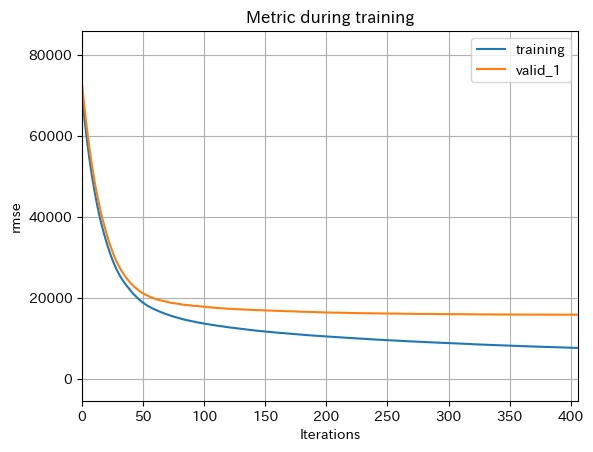

importance
面積               4.475731e+14
L                4.120296e+14
平均地価             2.092252e+14
最寄り駅             9.157513e+13
築年数              7.601341e+13
所在地              3.831284e+13
全体の階数            3.392870e+13
契約期間             1.861676e+13
所在階              9.916454e+12
所要時間             7.036154e+12
定期借家             2.609729e+12
部屋数              1.766328e+12
100m^2以上         1.438516e+12
D                4.966733e+11
75m^2以上100m^2未満  4.563392e+11
S                1.377809e+11

In [160]:
X_train = pd.concat([house_age, area_size, contract_span2, reg_rent, floor_scores2, Floor_scores2, stations, minits, land_aveprice, addresses, room_arrange[["部屋数","L","D",'S']], over100m2, bt75and100m2], axis=1)
y_train = pd.read_csv('../data/handmade_data/rent.csv')
y_train.loc[[5775], '賃料'] = y_train.loc[[5775], '賃料']/10
X_test = pd.concat([test_house_age, test_area_size, test_contract_span2, test_reg_rent, test_floor_scores2, test_Floor_scores2, test_stations, test_minits, test_land_aveprice, test_addresses, test_room_arrange[["部屋数","L","D","S"]], test_over100m2, test_bt75and100m2], axis=1)

category_lists = ['定期借家','最寄り駅', '所在地', 'L', 'D','S', '100m^2以上', '75m^2以上100m^2未満']

n_split = 5
cv = KFold(n_splits=n_split, shuffle=True, random_state=0)

for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index,:]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train.loc[train_index]
    y_val = y_train.loc[valid_index]

    evals_result = {} 
    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

    params = {
        'objective':'regression',
        'boosting_type':'gbdt',
        'metrics':'rmse',
        'learning_rate':0.05,
        'reg_lambda':  2.903886846508796e-05,
        'max_bin': 288,
        'num_leaves': 116,
    }

    print('Start training...')
    model = lgb.train(
                        params,
                        lgb_train, 
                        valid_sets=[lgb_train, lgb_eval], 
                        verbose_eval=10, 
                        num_boost_round=1000, 
                        early_stopping_rounds=10,
                        categorical_feature = category_lists,
                        evals_result=evals_result,
                        )

print('Start predicting...')
y_pred = model.predict(X_test, num_iteration=model.best_iteration)
print('Plot metrics during training...')
ax = lgb.plot_metric(evals_result, metric='rmse')
plt.show()
# feature importanceを表示
importance = pd.DataFrame(model.feature_importance(importance_type = "gain"), index=X_train.columns, columns=['importance'])
df_importance = pd.DataFrame(importance)
df_importance = df_importance.sort_values('importance', ascending=False) # 降順ソート
display(df_importance)